# Prise en main des données

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import math
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import networkx
import sys

warnings.filterwarnings("ignore")

In [2]:
print('python version:', sys.version, '\n')
print('pandas version:', pd.__version__, '\n')
print('numpy version:', np.__version__, '\n')
print('networkx version:', networkx.__version__)

python version: 3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)] 

pandas version: 0.20.1 

numpy version: 1.12.1 

networkx version: 1.11


Les dataframes sont chargées, concaténées et la variable 'Unnamed: 0' est retirée

In [3]:
df1 = pd.read_csv('datasets/df1.csv')
df2 = pd.read_csv('datasets/df2.csv')
df3 = pd.read_csv('datasets/df3.csv')
df4 = pd.read_csv('datasets/df4.csv')
df5 = pd.read_csv('datasets/df5.csv')
df6 = pd.read_csv('datasets/df6.csv')

data_frames = [df1, df2, df3, df4, df5, df6]

merged_df = pd.concat(data_frames)
merged_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [5]:
merged_df.head()

,id,lat,long,ts
0,66,48.846460,2.306055,1556661600
1,66,48.846442,2.306054,1556661640
2,66,48.846465,2.306093,1556661690
3,66,48.846485,2.306105,1556661740
4,66,48.846450,2.306070,1556661880


In [6]:
print('nombre de lignes:', merged_df.shape[0])

nombre de lignes: 1175842


Pour avoir une vue plus simple sur les timestamps, nous ajoutons une colonne représentant le datetime sous forme YYYY-MM-DD HH:MM:SS

In [297]:
merged_df['timestamp'] = (pd.to_datetime(merged_df['ts'], unit='s'))    


In [9]:
merged_df.head()

,id,lat,long,ts,timestamp
0,66,48.846460,2.306055,1556661600,2019-04-30 22:00:00
1,66,48.846442,2.306054,1556661640,2019-04-30 22:00:40
2,66,48.846465,2.306093,1556661690,2019-04-30 22:01:30
3,66,48.846485,2.306105,1556661740,2019-04-30 22:02:20
4,66,48.846450,2.306070,1556661880,2019-04-30 22:04:40


Il n'est pas précisé si l'enregistrement GPS est continue même si le moteur est à l'arret ou non, nous allons donc le déterminer si après en calculant la différence maximale entre 2 timestamps et pour chaque vehicule.

In [10]:
def max_diff_ts():
    
    max_diff_ts = {} # initialisation d'un dictionnaire à remplir

    for vehicule in merged_df['id'].unique(): # iteration sur les id des vehicules

        diff_ts = [] # initialisation d'une list à remplir

        df_vehicule_targeted = merged_df[merged_df['id'] == vehicule] # on extrait un dataframe contenant uniquement 
        df_vehicule_targeted.sort_values(by = 'ts', inplace = True)   # l'id courant, le dataframe est ensuite ordonnée
        df_vehicule_targeted.reset_index(inplace = True)              # par timestamp

        for row in range(df_vehicule_targeted.shape[0] - 1):
            
            # Calcule du temps en minutes séparant 2 timestamps consécutifs

            diff = (df_vehicule_targeted['ts'][row+1] - df_vehicule_targeted['ts'][row]) / 60
            diff_ts.append(diff)
            
        # L'écart maximum entre 2 timestamps est ensuite extrait
        
        max_diff_ts['{}'.format(vehicule)] = max(diff_ts)

    return max_diff_ts
    
    

In [12]:
max_value = max_diff_ts()

print('Temps maximum de la perte de signal GPS: {0:.2f} min'.format(max(max_value.values())))

Temps maximum de la perte de signal GPS: 11.33 min


Au maximum, un vehicule n'a émis aucun signal GPS pendant seulement 11 minutes, nous pouvons considérer que le tracking est donc fait en continue même si le moteur est éteint.

Remarque: Cette perte de signal GPS pourrait être dû au passage du véhicule dans un tunnel par exemple

# 1.       Quelles sont les étapes du trajet du véhicule n°78 lors de la journée du 2 mai?

Nous définissons un nouveau dataframe propre au vehicule 78 sur la journée du 2 mai ordonnée dans l'ordre chronologique.

En unix epoch, le 2 mai à minuit correspond à 1556755200
et le 3 mai à minuit correspond à 1556841600

Nous définissons le concept de "étape du trajet" comme un arrêt prolongé ou un mouvement prolongé de l'ordre de quelques minutes.

In [299]:
# Création d'un dataframe filtré sur le vehicule 78 pour le 2 mai

df_78_2_mai = merged_df[(merged_df['id'] == 78) 
                        & (merged_df['ts'] >= 1556755200) # timestamp du 2 mai à minuit
                        & (merged_df['ts'] < 1556841600)] # timestamp du 3 mai à minuit

df_78_2_mai.sort_values(by = 'ts', inplace = True)
df_78_2_mai.reset_index(inplace = True, drop = True)


Nous définissons ensuite une fonction qui donne la distance séparant deux plots GPS

In [4]:
# cette fonction n'est pas de moi


def distance(origin, destination):
    lat1, lon1 = origin[0], origin[1]
    lat2, lon2 = destination[0], destination[1]
    radius = 6371000 # metres

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d



Nous calculons ensuite la distance parcourue entre deux plots GPS, c'est-à-dire entre deux lignes consécutives donc, dans l'ordre chronolique mais avec un pas de temps irregulier à cause du tracking espacé de 10 secondes lorsque le véhicule est en mouvent et environ 40 secondes lorsqu'il est à l'arrêt.

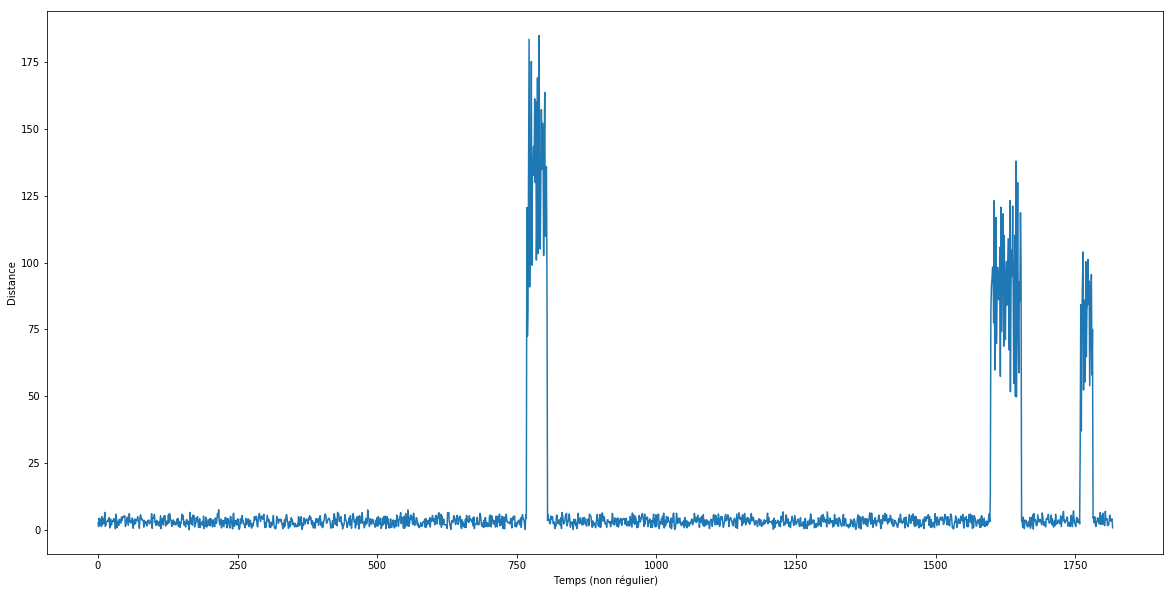

In [43]:
dist_array = []

for row in range(df_78_2_mai.shape[0] - 1):
        
    dist = distance([df_78_2_mai['lat'][row+1], df_78_2_mai['long'][row+1]], 
                    [df_78_2_mai['lat'][row], df_78_2_mai['long'][row]])
    
    dist_array.append(dist)    
        
plt.figure(figsize = (20,10))
plt.plot(dist_array)
plt.ylabel('Distance')
plt.xlabel('Temps (non régulier)')
plt.show();

Nous pouvons voir très clairement qu'il y a trois zones notables de mouvement du véhicule.

A noter un fort bruit sur le graph dû probablement à la précision du GPS.
Pour palier à ce bruit, nous allons espacer l'échelle de temps du calcul de la distance entre deux plots GPS, passant de 1 à 10 lignes, ce qui nous permettra de mieux distinguer un déplacement très lent ou une erreur dû à la précision à un arrêt.

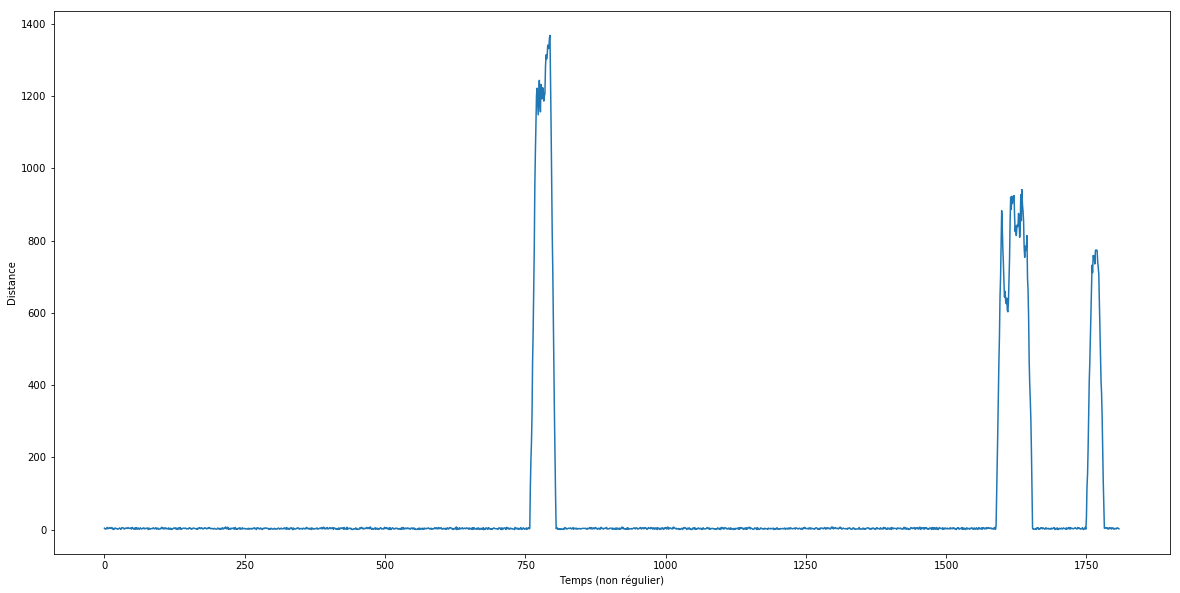

In [44]:
dist_array = []

for row in range(df_78_2_mai.shape[0] - 10):
        
    dist = distance([df_78_2_mai['lat'][row+10], df_78_2_mai['long'][row+10]], # Espacement de 10 lignes entre 2 timestamps
                    [df_78_2_mai['lat'][row], df_78_2_mai['long'][row]])       # afin de réduire le bruit
    
    dist_array.append(dist)    
        
plt.figure(figsize = (20,10))
plt.plot(dist_array)
plt.ylabel('Distance')
plt.xlabel('Temps (non régulier)')
plt.show();

La courbe est bien lissée.

Nous constatons que le véhicule est à l'arret du début du tracking du 2 mai (correspondant à la ligne zéro du dataframe filtré), c'est-à-dire 1h50 à la ligne 750 environ qui correspond à 10h15 environ.
Un check sur une carte permet de voir que la zone GPS correspond au 16ème arrondissement de Paris.

Ensuite, à partir de la 750ème ligne (10h15) le vehicule est en mouvement pendant 6 à 7 min juqu'à une localisation dans le 2ème arrondissement ce qui concorde avec le temps de trajet compte tenu de la distance.
Nous pouvons remarquer des pics et descentes sur le graph zoomé à cette période ce qui pourrait correspondre à des arrêts ponctuels à des stops ou des feux rouges par exemple.

Par la suite, à partir de la ligne 1590 correspondant à l'heure 21h25 environ, le véhicule se remet en mouvement pendant 6 à 7 minutes environ pour revenir au même endroit que le matin dans le 16ème arrondissement.

Un peu plus tard, à la ligne 1755 environ, soit 23h21 environ, le véhicule se remet en mouvement pendant 6 à 7 minutes environ. La destination atteinte correspond à une localisation dans le 7ème arrondissement.

Le véhicule ne bougera plus ensuite.


Déterminons tout cela de façon plus précise:


In [294]:
def nombre_stop_avec_index(data, epsilon):
    
    """
    Retourne les zones de stationnement sous la forme stop_i avec l'index de début et l'index de fin.
    
    data: dataframe
    epsilon: distance minimale entre 2 plots pour que l'on considère qu'il s'agisse bien d'un arret
    
    """
    

    res = [[]]             # initialisation d'une liste de liste vide
    i = 0                  # compteur de stop, permet d'ajouter une sous liste à res
    indexes_stop = {}      # initialisation d'un dictionnaire
    list_array_final = []  # initialisation d'une liste simple

    for index in range(0,(data.shape[0]-1)): # iteration sur les lignes du dataframe
        
        # check si la distance entre 2 plots GPS consécutifs dans le temps est inférieur à epsilon
        
            if distance([data['lat'][index+1], data['long'][index+1]], 
                        [data['lat'][index], data['long'][index]]) < epsilon:
                
                # Si oui, l'index est ajouté à la sous liste res[i]
                
                res[i].append(index)

            else:
                
                # Si non, une nouvelle sous liste est créee et l'index est ajouté à celle-ci

                i = i + 1

                res.append([index])

    for i in range(len(res)): # iteration sur les sous listes de res

        if len(res[i]) > 1: # si res contient plus d'une sous liste, elle est ajoutée à list_aray_final

            list_array_final.append(res[i])
            
    # Le nombre d'arrets total est ensuite donnée par le length de list_array_final

    print("nombre d'arrets comptabilisés:", len(list_array_final), '\n \n')

    for stop in range(len(list_array_final)): # iteration sur la liste des index correspondant à un arret
        
        # le premier et dernier index du stop est ensuite ajouté au dictionnaire indexes_stop avec en key stop_i
        # le stop + 1 ci-après permet une numérotation débutant à 1 et non pas 0
    
        indexes_stop['stop_{}'.format(stop + 1)] = [list_array_final[stop][0], list_array_final[stop][-1]]
                
    for key in indexes_stop.keys(): # iteration sur la liste des stop contenu dans indexes_stop
        
        first_ts = data['timestamp'].ix[indexes_stop[key][0]].time() # heure de début de stationnement
        last_ts = data['timestamp'].ix[indexes_stop[key][-1]].time() # heure de fin de stationnement
        
        # nous prenons ensuite un index situé à peu près au milieu du time frame de stationnement
        # pour une meilleur précision GPS
        
        index_loc = indexes_stop[key][0] + int((indexes_stop[key][-1] - indexes_stop[key][0]) / 2)
        
        # les coordonnées GPS sont ensuite extraites
        
        lat = data['lat'][index_loc]
        long = data['long'][index_loc]

        print(key, "de {} à {} environ à l'emplacement ({}, {})\n".format(first_ts, last_ts, lat, long))
            
    return(indexes_stop)



In [157]:
nombre_stop_avec_index(df_78_2_mai, epsilon = 10)

nombre d'arrets comptabilisés: 4 
 

stop_1 de 00:01:50 à 10:30:40 environ à l'emplacement (48.869078952198706, 2.2974078229861803)

stop_2 de 10:37:20 à 21:32:30 environ à l'emplacement (48.864813087701904, 2.3554860212742796)

stop_3 de 21:44:00 à 23:23:00 environ à l'emplacement (48.86908272698171, 2.29742979469383)

stop_4 de 23:27:50 à 23:59:10 environ à l'emplacement (48.8553630653042, 2.30371957996463)



{'stop_1': [0, 767],
 'stop_2': [804, 1597],
 'stop_3': [1653, 1758],
 'stop_4': [1781, 1817]}

Vérifions un à un ces arrets et mouvements par des méthodes graphiques.

'stop_1': [0, 767],
'stop_2': [804, 1597]

Donc il y a un premier mouvement entre l'index 767 et 804 environ.

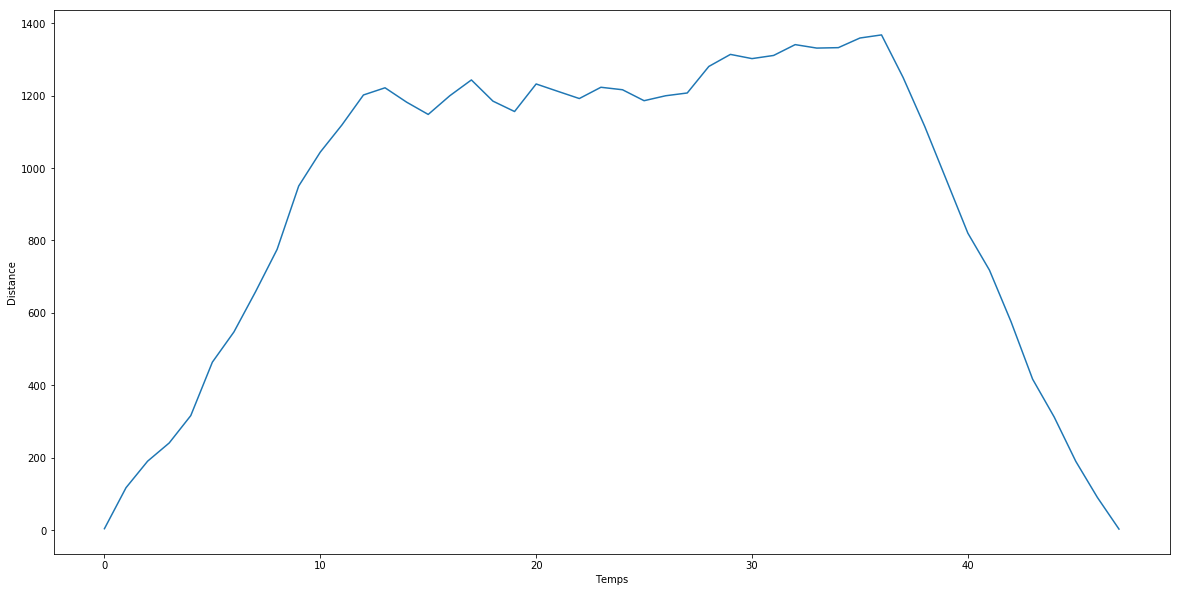

In [67]:
plt.figure(figsize = (20,10))
plt.plot(dist_array[758:806])
plt.ylabel('Distance')
plt.xlabel('Temps')
plt.show();

Graphiquement, le mouvement à lieu entre les indexs 758 et 806, l'erreur donnée par la fonction nombre_stop_avec_index est dû au choix d'epsilon, mais nous trouvons des index assez proches de la réalité tout de même.

In [66]:
print(' Début du mouvement 1:',str(df_78_2_mai['timestamp'].ix[758]), 
      '\n fin du mouvement 1:', str(df_78_2_mai['timestamp'].ix[806]))

 Début du mouvement 1: 2019-05-02 10:22:10 
 fin du mouvement 1: 2019-05-02 10:40:00


Les stops suivants sont:

'stop_2': [804, 1597], 'stop_3': [1653, 1758]

Donc le deuxième mouvement à lieu entre les indexs 1597 et 1653 environ.

Vérifions cela graphiquement.

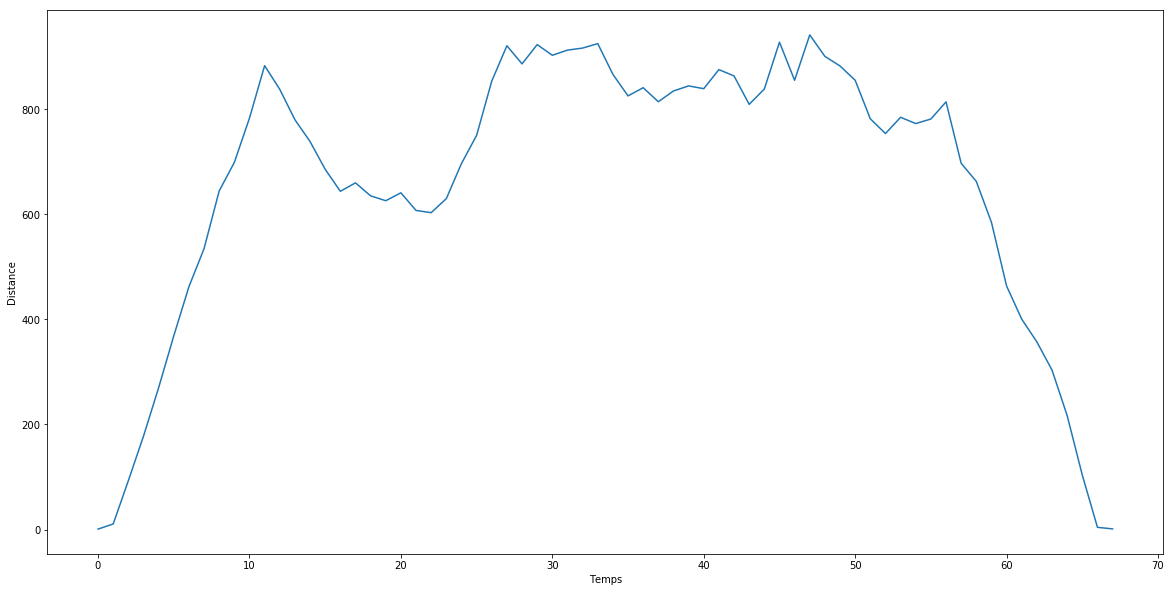

In [71]:
plt.figure(figsize = (20,10))
plt.plot(dist_array[1588:1656])
plt.ylabel('Distance')
plt.xlabel('Temps')
plt.show();

Graphiquement, le mouvement à lieu entre les indexs 1588 et 1656.

In [73]:
print(' Début du mouvement 2:',str(df_78_2_mai['timestamp'].ix[1588]), 
      '\n fin du mouvement 2:', str(df_78_2_mai['timestamp'].ix[1656]))

 Début du mouvement 2: 2019-05-02 21:23:50 
 fin du mouvement 2: 2019-05-02 21:47:40


Les stops suivants sont:
    
'stop_3': [1653, 1758],
'stop_4': [1781, 1817]

Donc le 3ème mouvement à lieu entre les indexs 1758 et 1781 environ.

Vérifions cela graphiquement.

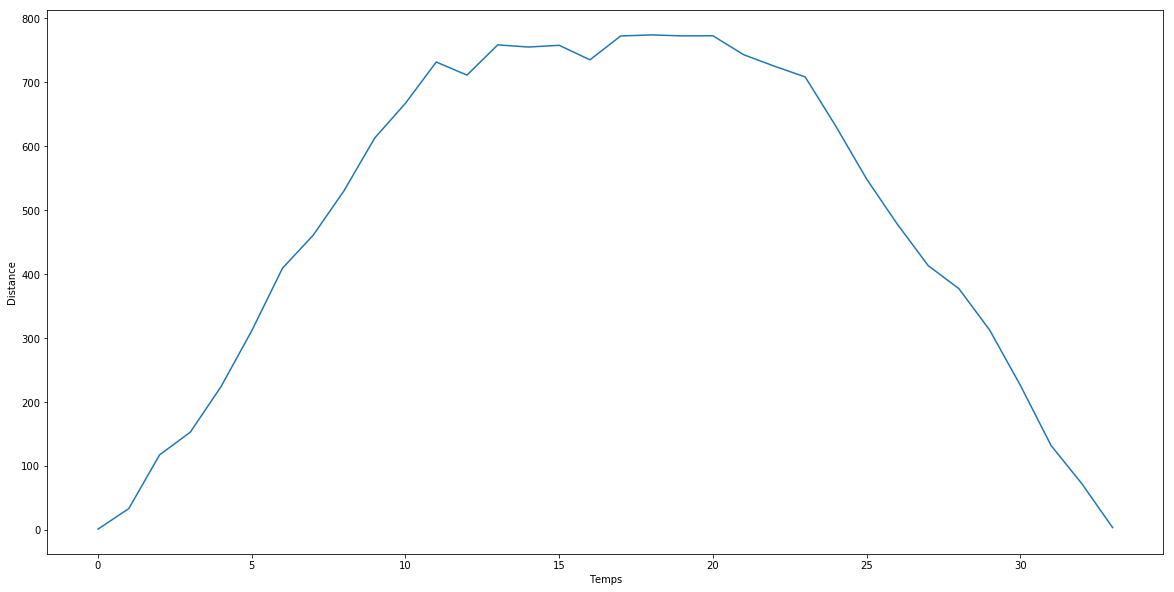

In [79]:
plt.figure(figsize = (20,10))
plt.plot(dist_array[1749:1783])
plt.ylabel('Distance')
plt.xlabel('Temps')
plt.show();

Graphiquement, le mouvement à lieu entre les indexs 1588 et 1656.

In [80]:
print(' Début du mouvement 3:',str(df_78_2_mai['timestamp'].ix[1749]), 
      '\n fin du mouvement 3:', str(df_78_2_mai['timestamp'].ix[1789]))

 Début du mouvement 3: 2019-05-02 23:16:00 
 fin du mouvement 3: 2019-05-02 23:33:40


Il nous reste à déterminer maintenant si les places de stationnement sont les mêmes ou non à partir des coordonnées GPS de chaque emplacements:

stop_1 de 00:01:50 à 10:30:40 environ à l'emplacement (48.869078952198706, 2.2974078229861803)

stop_2 de 10:37:20 à 21:32:30 environ à l'emplacement (48.864813087701904, 2.3554860212742796)

stop_3 de 21:44:00 à 23:23:00 environ à l'emplacement (48.86908272698171, 2.29742979469383)

stop_4 de 23:27:50 à 23:59:10 environ à l'emplacement (48.8553630653042, 2.30371957996463)

In [213]:
# Création d'un dictionnaire avec les stops et leurs coordonnées

stop = {}

stop['stop_1'] = [48.869078952198706, 2.2974078229861803]
stop['stop_2'] = [48.864813087701904, 2.3554860212742796]
stop['stop_3'] = [48.86908272698171, 2.29742979469383]
stop['stop_4'] = [48.8553630653042, 2.30371957996463]

name = ['stop_1', 'stop_2', 'stop_3', 'stop_4']
n = len(name)

# Calcul de la distance séparant tous les couples différents de stop

for iteration_1 in range(n - 1):
    
    for iteration_2 in range(iteration_1, n):
        
        stop_1 = name[iteration_1]
        lat_long_1 = [stop[stop_1][0], stop[stop_1][1]]

        if iteration_1 != iteration_2:
                      
            stop_2 = name[iteration_2]
            lat_long_2 = [stop[stop_2][0], stop[stop_2][1]]
            
            dist = distance(lat_long_1, lat_long_2)
        
            print('distance({}, {}) = {:.2f} mètres'.format(stop_1, stop_2, dist), '\n')

distance(stop_1, stop_2) = 4274.54 mètres 

distance(stop_1, stop_3) = 1.66 mètres 

distance(stop_1, stop_4) = 1593.50 mètres 

distance(stop_2, stop_3) = 4272.99 mètres 

distance(stop_2, stop_4) = 3930.06 mètres 

distance(stop_3, stop_4) = 1593.43 mètres 



Nous pouvons donc affirmer que les zones de stationnement 1 et 3 sont identiques, les autres non, il y a donc 3 emplacemenet de stationnement différents.


### En résumé:

1. De minuit à 10h30 environ, le véhicule stationne sur un emplacement que l'on appelera stop_1

2. De 10h30 à 10h37 environ, le véhicule est en mouvement vers un emplacement stop_2

3. De 10h37 à 21h30 environ, le véhicule stationne en un emplacement stop_2 (différent de stop_1)

4. De 21h30 à 21h44, le véhicule est en mouvement et retourne à l'emplacement stop_1

5. De 21h44 à 23h25, le véhicule stationne sur l'emplacement stop_1

6. De 23h23 à 23h27 environ, le véhicule se déplace vers un nouvel emplacement différent des 2 précedents

7. Enfin, de 23h30 environ à la fin, le véhicule stationne sur un nouvel emplacement (différent des 2 autres) et ne bougera plus.


# 2.       Quel est, à priori, le garage principal du véhicule n°57?

Nous définissions le "garage principal du vehicule" comme une zone de parking visitée plusieurs fois et ou la durée de stationnement est assez longue.

Nous créons un nouveau dataframe filtrant le véhicule 57 pendant toute la période, les lignes sont rangées dans l'ordre chronologique.

In [302]:
df_57 = merged_df[merged_df['id'] == 57]

df_57.sort_values(by = 'ts', inplace = True)
df_57.reset_index(inplace = True, drop = True)


De la même manière que précedement, nous calculons la distance parcourue entre deux plots GPS, c'est-à-dire entre deux lignes consécutives donc, dans l'ordre chronolique mais avec un pas de temps irregulier à cause du tracking espacé de 10 secondes lorsque le véhicule est en mouvent et d'environ 40 secondes lorsqu'il est à l'arrêt.

Nous prenons en compte un bruit dû à la précision du GPS et afin de lisser la courbe, nous prenons un pas de 10 lignes.

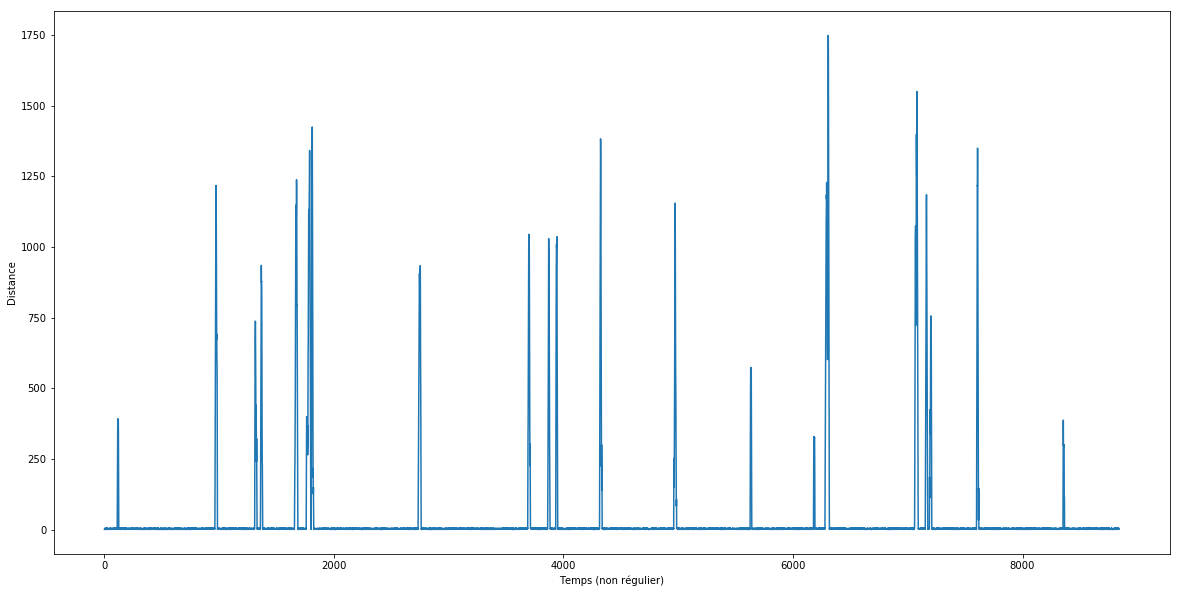

In [285]:
# Calcul de la distance séparant 2 plots GPS (séparés de 10 lignes)

dist_array_57 = []

for row in range(df_57.shape[0] - 10):
            
    dist = distance([df_57['lat'][row+10], df_57['long'][row+10]], 
                    [df_57['lat'][row], df_57['long'][row]])
    dist_array_57.append(dist)

           
plt.figure(figsize = (20,10))
plt.plot(dist_array_57)
plt.ylabel('Distance')
plt.xlabel('Temps (non régulier)')
plt.show();

Nous pouvons voir à l'oeil qu'il y a environ 21 arrêts plus ou moins long sur le graph.

Nous allons sortir les index correspondant suivant une distance entre 2 plots GPS inferieur à un epsilon à déterminer de sorte de se rapprocher des 21 arrêts sur le graph.

In [303]:
# un epsilon de 10 mètres semble donner un résultats cohérent avec le graph

indexes_stop = nombre_stop_avec_index(df_57, epsilon = 10)

nombre d'arrets comptabilisés: 23 
 

stop_1 de 22:01:00 à 23:43:00 environ à l'emplacement (43.59711956388221, 1.4433495756785801)

stop_2 de 23:44:10 à 11:38:20 environ à l'emplacement (43.5936141705153, 1.44389997440633)

stop_3 de 11:42:00 à 16:12:50 environ à l'emplacement (43.605320643606504, 1.4376105786296698)

stop_4 de 16:14:50 à 16:50:00 environ à l'emplacement (43.60893873313089, 1.4413114656887702)

stop_5 de 16:51:40 à 20:53:40 environ à l'emplacement (43.611199374872704, 1.4309194338532099)

stop_6 de 20:58:10 à 22:00:10 environ à l'emplacement (43.597129213711604, 1.44339187802992)

stop_7 de 22:02:10 à 22:05:00 environ à l'emplacement (43.5947211254854, 1.4450428313606598)

stop_8 de 22:10:40 à 22:22:20 environ à l'emplacement (43.6111352482026, 1.42937758144946)

stop_9 de 22:28:40 à 11:05:10 environ à l'emplacement (43.5997740972805, 1.4269365835140602)

stop_10 de 11:09:50 à 23:46:40 environ à l'emplacement (43.5971108482078, 1.44337710934376)

stop_11 de 23:49:00 à

En choisissant espsilon = 10 mètres nous avons environ le même nombre d'arrets que trouvé visuelement.

Nous avons les index de début et fin de chaque stationnement:

In [304]:
indexes_stop

{'stop_1': [0, 120],
 'stop_10': [2759, 3697],
 'stop_11': [3711, 3871],
 'stop_12': [3882, 3941],
 'stop_13': [3949, 4323],
 'stop_14': [4336, 4969],
 'stop_15': [4985, 5635],
 'stop_16': [5640, 6187],
 'stop_17': [6190, 6287],
 'stop_18': [6316, 7068],
 'stop_19': [7090, 7161],
 'stop_2': [124, 971],
 'stop_20': [7173, 7197],
 'stop_21': [7208, 7607],
 'stop_22': [7618, 8361],
 'stop_23': [8365, 8849],
 'stop_3': [984, 1318],
 'stop_4': [1328, 1368],
 'stop_5': [1377, 1664],
 'stop_6': [1685, 1767],
 'stop_7': [1773, 1779],
 'stop_8': [1798, 1810],
 'stop_9': [1822, 2742]}

A présent, nous créons un data frame de statistique sur ces arrêts qui donne l'heure d'arrivée et de départ, la durée en heures et les coordonnées GPS

In [340]:
def get_stat():

    resume_parking = pd.DataFrame() # Création d'un dataframe à remplir

    num_stop = 24 # + 1 à cause de l'indexation choisi
    
    # Création des columns

    resume_parking['time_of_arrival'] = [np.nan] * num_stop
    resume_parking['time_of_departure'] = [np.nan] * num_stop
    resume_parking['duration'] = [np.nan] * num_stop
    resume_parking['lat'] = [np.nan] * num_stop
    resume_parking['lon'] = [np.nan] * num_stop


    for parking in range(1,len(indexes_stop) + 1): # iteration sur chaque place de stationnement
        
        # Récupération des index d'arriver et départ

        index_arr = indexes_stop['stop_{}'.format(parking)][0]
        index_dep = indexes_stop['stop_{}'.format(parking)][1]
        
        # Remplissage du dataframe
        
        resume_parking['time_of_arrival'][parking] = df_57['timestamp'][index_arr]
        resume_parking['time_of_departure'][parking] = df_57['timestamp'][index_dep]
        
        # Temps resté sur l'emplacement en heure
        
        resume_parking['duration'][parking] = (df_57['ts'][index_dep] - df_57['ts'][index_arr]) / (60*60)

        # Extraction des coordonnées GPS
        
        index_stationnement_avg = index_arr + (index_dep - index_arr) / 2 


        resume_parking['lat'][parking] = df_57['lat'][int(index_stationnement_avg)]
        resume_parking['lon'][parking] = df_57['long'][int(index_stationnement_avg)]

    resume_parking.dropna(inplace = True)
    
    # Le dataframe est ordonnée par temps de stationnement
    
    resume_parking.sort_values(by = 'duration', ascending = False, inplace = True)
    resume_parking.reset_index(inplace = True, drop = True)

    return resume_parking

resume_parking = get_stat()

In [307]:
resume_parking

,time_of_arrival,time_of_departure,duration,lat,lon
0,2019-05-02 11:09:50,2019-05-02 23:46:40,12.613889,43.597111,1.443377
1,2019-05-01 22:28:40,2019-05-02 11:05:10,12.608333,43.599774,1.426937
2,2019-04-30 23:44:10,2019-05-01 11:38:20,11.902778,43.593614,1.443900
3,2019-05-04 11:07:00,2019-05-04 21:40:50,10.563889,43.612285,1.425223
4,2019-05-05 04:52:50,2019-05-05 15:04:40,10.197222,43.594740,1.445025
5,2019-05-03 16:53:10,2019-05-04 02:04:40,9.191667,43.597089,1.443326
6,2019-05-03 07:54:00,2019-05-03 16:49:50,8.930556,43.590477,1.436749
7,2019-05-04 02:06:10,2019-05-04 09:30:10,7.400000,43.592102,1.444642
8,2019-05-05 15:05:40,2019-05-05 21:57:30,6.863889,43.597106,1.443327
9,2019-05-04 23:27:50,2019-05-05 04:50:50,5.383333,43.603747,1.435952


Le dataframe ci-dessus nous donne les statistiques pour chaque arrets mais ne nous donne pas l'information si l'arret est identique à d'autres ou non.

Nous allons regarder cela dans la prochaine cellule.

In [328]:

def compute_distance_parking(resume_stationement):
    
    """
    Retourne un dictionnaire avec comme key XXX_YYY pour XXX_YYY, les numéros de parking et la valeur donnée est la 
    distance séparant XXX et YYY
    """    
    
    dist_parking = {} # Dictionnaire à remplir
    
    n = resume_stationement.shape[0]  # nombre de places de stationnement
    
    # calcul de la distance séparant chaque couple de place de parking

    for index_i in range(n - 1):
        
        lat_long_1 = [resume_stationement['lat'][index_i], resume_stationement['lon'][index_i]]
        
        for index_j in range(index_i + 1, n):
            
            lat_long_2 = [resume_stationement['lat'][index_j], resume_stationement['lon'][index_j]]            
        
            dist_parking['{:03d}_{:03d}'.format(index_i, index_j)] = distance(lat_long_1, lat_long_2)
            
    return dist_parking



def group_parking(dist_parking, epsilon):
    
    """
    Retourne les places de stationnement distant de moins de epsilon mètres sous forme d'un dictionnaire
    
    Note: le nom des keys est la première place de parking splittée
    """
    
    
    dico = {} # dictionnaire à remplir
    
    for i in dist_parking.keys(): # iteration sur les keys de dist_parking
        
        if dist_parking[i] < epsilon: # check si le couple de parking est distant de moins de epsilon mètres
            
            first, last = i.split('_')
            first = int(first)
            last = int(last)
            
            if first in dico: # si le premier parking (first) est présent dans la liste, on ajoute 
                              # l'autre emplacement (last) qui est distant de moins de epsilon
                
                dico[first].add(last)
                
            else: # sinon, on fait le même check avec last et on ajoute first dans la liste
                
                found = False
                
                for j in dico.keys():
                    
                    if last in dico[j]:
                        
                        found = True
                        dico[j].add(first)
                        
                if not found: # si aucun des 2 n'est trouvé, on les ajoute ensemble
                    
                    dico[first] = {first, last}
                    
    return dico

La fonction group_parking donne la liste de tous les emplacements identiques à partir du dataframe resume_parking, si cette liste contient qu'un seul item, elle n'est pas comptabilisée.
Nous considérons, compte tenu de la précision GPS, que 2 parkings sont les mêmes s'ils sont placés à au moins 10 mètres l'un de l'autre.

In [329]:
dist_parking = compute_distance_parking(resume_parking)
group_parking(dist_parking, epsilon = 10)

{0: {0, 5, 8, 14, 16, 17}, 4: {4, 22}}

Nous avons donc que les emplacements 4 et 22 sont identiques ainsi que les emplacements 0, 5, 8, 14, 16 et 17.

Les autres emplacements ne sont visités qu'une fois et donc ne nous interesse pas d'après la définition d'un garage que nous avons donné.

Nous reprenons donc le dataframe précedent filtré sur ces emplacements pour faire plus de statistiques.

In [344]:
parking_1 = resume_parking.loc[[0, 5, 8, 14, 16, 17]]
parking_2 = resume_parking.loc[[4,22]]


print('parking_1 \n')
print("nombre de stationnements sur l'emplacement:", parking_1.shape[0])
print("temps moyen passé sur l'emplacement: {:.2f} heures".format(parking_1['duration'].mean()))
print("temps total passé sur l'emplacement {:.2f} heures:".format(parking_1['duration'].sum()), '\n \n')

print('parking_2 \n')
print("nombre de stationnements sur l'emplacement:", parking_2.shape[0])
print("temps moyen passé sur l'emplacement: {:.2f} heures".format(parking_2['duration'].mean()))
print("temps total passé sur l'emplacement: {:.2f} heures".format(parking_2['duration'].sum()), '\n \n \n')

parking_1 = [0, 5, 8, 14, 16, 17]
parking_2 = [4, 22]

nb_stop = 23
resume_parking['parking'] = [np.nan] * nb_stop

resume_parking['parking'].loc[parking_1] = 'parking_1'
resume_parking['parking'].loc[parking_2] = 'parking_2'
resume_parking.dropna()

parking_1 

nombre de stationnements sur l'emplacement: 6
temps moyen passé sur l'emplacement: 5.41 heures
temps total passé sur l'emplacement 32.46 heures: 
 

parking_2 

nombre de stationnements sur l'emplacement: 2
temps moyen passé sur l'emplacement: 5.12 heures
temps total passé sur l'emplacement: 10.24 heures 
 
 



,time_of_arrival,time_of_departure,duration,lat,lon,parking
0,2019-05-02 11:09:50,2019-05-02 23:46:40,12.613889,43.597111,1.443377,parking_1
4,2019-05-05 04:52:50,2019-05-05 15:04:40,10.197222,43.594740,1.445025,parking_2
5,2019-05-03 16:53:10,2019-05-04 02:04:40,9.191667,43.597089,1.443326,parking_1
8,2019-05-05 15:05:40,2019-05-05 21:57:30,6.863889,43.597106,1.443327,parking_1
14,2019-04-30 22:01:00,2019-04-30 23:43:00,1.700000,43.597120,1.443350,parking_1
16,2019-05-04 21:45:00,2019-05-04 22:48:10,1.052778,43.597117,1.443355,parking_1
17,2019-05-01 20:58:10,2019-05-01 22:00:10,1.033333,43.597129,1.443392,parking_1
22,2019-05-01 22:02:10,2019-05-01 22:05:00,0.047222,43.594721,1.445043,parking_2


D'après ce qui precède, compte tenu du nombre de fois ou le vehicule a stationné sur l'emplacement et son temps passé dessus, nous pouvons affirmer que le parking_1 est le garage du vehicule 57 situé à l'emplacement GPS (43.597111,	1.443377)


# 3. Si N véhicules (N>1) se déplacent ensemble sur une distance plus ou moins longue la même journée, ils forment un convoi. Identifiez les convois de la journée du 4 mai.


Pour cette question, nous considérons qu'un groupe de véhicules forment un convoi s'ils se déplacent ensemble sur time range à choisir et distant de epsilon. 

Méthode utilisée:

1. Créer un dataframe (filtré sur le 4 mai) dont les lignes représentent les timestamps de manière unique où un déplacement est enregistré et les colonnes sont de la formes lat_i, long_i pour i dans l'ensembles des id des vehicules. Si le vehicule i est en mouvement au timestamp considéré lat_i et long_i sera affecté de sa latitude et longitude et s'il n'est pas en mouvement, lat_i et long_i sera affecté par un NaN.

2. Garder les timestamps de ce dataframe espacés d'une durée en minute de 5 minutes

3. Extraires la liste de vehicules en mouvement pour chaque timestamp

4. Créer un range (de 5 minutes) en utilisant la ligne i+1 et i et détecter les vehicules toujours en mouvement sur ces ranges, c'est-à-dire que si un ensemble de véhicule sont en mouvement au timestamp t et à t + 5 min, ils seront considérés comme en mouvement sur tout le range [t, t + 5 min]

5. Enfin, parmi chaque range, trouver chaque sous groupes de vehicules (s'il y en a plusieurs) en utilisant les distances les séparant, nous aurons les convois par range à la fin


##### Limitations:

1. Plus la flotte de véhicule est grande et plus la complexité de calcul de cette méthode sera grande puisque chaque vehicule est transposé en 2 colonnes

2. Si un vehicule A est en mouvement au timestamp t, qu'il s'arrete ensuite mais qu'il refait un mouvement au timestamp t + 5min, il sera considéré comme en mouvement durant tout le timerange de t à t+5min, pour y remédier, nous pouvons réduire l'intervalle de 5 minutes mais ceci augement la complexité de calcul.

3. Si des vehicules formes 2 convois sur des routes paralèlles différentes (par exemple, 2 routes paralèlles séparées par un batiment) mais que la distance séparant les 2 convois est de moins de epsilon mètres, ces 2 convois seront considérés comme un seul.



Pour commencer, nous prenons un time range de 5 minutes et un epsilon de 20 mètres, un autre exemple est donnée à la fin.


#### Nous aurons en sortie des time ranges avec la liste des vehicules en convoi.


La cellule suivante contient un jeu de test à ne pas prendre en compte.

In [191]:
# Filtration du dataframe sur le 4 mai uniquement

df_4_mai = merged_df[(merged_df['ts'] >= 1556928000)
                       & (merged_df['ts'] < 1557014400)]

df_4_mai.sort_values(by = 'ts', inplace = True)
df_4_mai.reset_index(inplace = True, drop = True)


In [178]:
# filtration des timestamps ou le vehicule considéré est en mouvement uniquement puis les dataframes sont concaténés


# epsilon est la distance minimum entre 2 ligne (donc 2 plot GPS) pour que le véhicule soit considéré en mouvement

def ts_where_vehicules_in_movement(data, epsilon):
    
    """
    Retourn un dataframe ou chaque ligne pour un vehicule donnée est espacée d'une distance epsilon impliquant
    que les vehicules sont en mouvement
    """

    dico = {} # Initialisation du dictionnaire à remplir
    
    # ce dictionnaire aura comme key l'id du vehicule et comme valeur le sous dataframe associé au vehicule

    for vehicule in data['id'].unique(): 

        key = 'vehicule_{}'.format(vehicule)
        
        # Extraction du dataframe propre à l'id considéré
        
        dico[key] = data[data['id'] == vehicule]
        dico[key].sort_values(by = 'ts', inplace = True)
        dico[key].reset_index(inplace = True, drop = True)

        res = []#dico[key].shape[0] - 1] 
        
        for index in range(dico[key].shape[0] - 1): 
            
            # Calcul de la distance entre 2 lignes (2 timestamps ordonnées)

            dist = distance([dico[key]['lat'][index + 1], 
                             dico[key]['long'][index + 1]], 
                            [dico[key]['lat'][index], 
                             dico[key]['long'][index]])
            
            if dist <= epsilon: # Les index ou la distance sont inférieur à epsilon sont gardés
                
                res.append(index)

        dico[key].drop(res, axis = 0, inplace = True) # Les index avec distance inférieur à epsilon sont retirés  
    
    # On merge tous les dataframes pour chaque vehicule en un seul
    
    df_merged = pd.concat(dico.values(), ignore_index=True)
    
    return df_merged


In [190]:
df_merged = ts_where_vehicules_in_movement(df_4_mai, epsilon = 3)


# Note: il ne s'agit pas du même epsilon que je mentionne en introduction.

In [192]:
df_merged.head()

,id,lat,long,ts
0,66,48.866968,2.358286,1556928010
1,66,48.866948,2.358230,1556928040
2,66,48.866989,2.358274,1556928190
3,66,48.866944,2.358286,1556928270
4,66,48.866952,2.358226,1556928350


Nous créons le dataframe timestamps en lignes et lat_i, long_i en columns

In [180]:
# Environ 30 min de calcul

def create_df_ts_in_function_gps(df_merged):
    
    """
    A partir d'un dataframe, retourne un dataframe avec en ligne les timestamps (de manière unique)
    et en column lat_i, long_i pour i, l'id du vehicule. Si le vehicule est en mouvement, une latitude et longitude
    est affecté sinon un NaN est affecté.
    """

    time_range = df_merged['ts'].unique() # extraction de tous les timestamps de manière unique

    df = pd.DataFrame() # Création du dataframe à remplir

    df['time_range'] = time_range # Les lignes sont remplis ici

    for id_ in df_merged['id'].unique(): # iteration sur les id des vehicules
        
        # Un sous dataframe propre à l'id est crée

        df_id = df_merged[df_merged['id'] == id_]
        
        print(id_) # verbose

        lat_array = [] # liste des latitude et longitude à remplir
        long_array = []

        for ts in time_range: # iteration sur les timestamps
            
            # remplissage des listes de latitude, longitude si présents

                try:
                    lat = float(df_id['lat'][df_id['ts'] == ts])
                    long = float(df_id['long'][df_id['ts'] == ts])

                    lat_array.append(lat)
                    long_array.append(long)

                except: 
                    
                    # sinon, un NaN est affecté

                    lat_array.append(np.nan)
                    long_array.append(np.nan)


        df['lat_{:04d}'.format(id_)] = lat_array
        df['long_{:04d}'.format(id_)] = long_array
        
        
    return df


df = create_df_ts_in_function_gps(df_merged)

In [193]:
df.head()

,time_range,lat_0066,long_0066,lat_0010,long_0010,lat_0070,long_0070,lat_0025,long_0025,lat_0021,...,lat_0092,long_0092,lat_0046,long_0046,lat_0090,long_0090,lat_1008,long_1008,lat_0074,long_0074
0,1556928010,48.866968,2.358286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1556928040,48.866948,2.358230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1556928190,48.866989,2.358274,NaN,NaN,48.860521,2.298667,48.886318,2.312619,48.865685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1556928270,48.866944,2.358286,NaN,NaN,NaN,NaN,48.886319,2.312667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1556928350,48.866952,2.358226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = pd.read_csv('datasets/df_quest_3_last.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

A présent, nous considérons que le temps minimum de mouvement pour qu'un convoi soit considéré comme tel est de 5 minutes.

Ce time range est choisis complêtement arbitrairement.

Nous filtrons donc à nouveau le data frame crée et nous gardons les timestamps espacé d'au moins 5 minutes.

In [10]:
# Nous créons un array contenant les timestamps séparés de 5 min

def get_index_x_min_range(df, x = 5):
    
    """
    Retourne les index (timestamps) distant de x minutes à partir du plus petit timestamp 
    du dataframe donnée
    """

    min_ = df['time_range'].min()
    max_ = df['time_range'].max()

    range_x_min = []
    range_x_min.append(min_)

    i = min_

    while i <= max_:

        i = i + x*60

        if i > max_:

            break

        else:

            range_x_min.append(i)
            
    return range_x_min

range_5_min = get_index_x_min_range(df, x = 5)


In [11]:
range_5_min[0:10]

[1556928000,
 1556928300,
 1556928600,
 1556928900,
 1556929200,
 1556929500,
 1556929800,
 1556930100,
 1556930400,
 1556930700]

In [9]:
# Création du nouveau data frame avec des timestamps toutes les 5 min suivant le range_5_min crée précedement
# le dataframe est ensuite ordonnée


df.sort_values(by = 'time_range', inplace = True)
df.reset_index(drop = True, inplace = True)


#### Remarque importante: si le timestamp de la liste range_5_min n'existe pas dans le dataframe fourni, le time range entre les 2 lignes sera supérieur à 5 min

In [11]:
df.head()

# Espacement de 300 secondes entre chaque ligne soit 5 minutes

,time_range,lat_0066,long_0066,lat_0010,long_0010,lat_0070,long_0070,lat_0025,long_0025,lat_0021,...,lat_0092,long_0092,lat_0046,long_0046,lat_0090,long_0090,lat_1008,long_1008,lat_0074,long_0074
0,1556928000,NaN,NaN,48.849827,2.295001,NaN,NaN,NaN,NaN,48.865701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1556928010,48.866968,2.358286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1556928020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1556928030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1556928040,48.866948,2.358230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Création d'un dictionnaire contenant la liste de tous les vehicules en mouvement par timestamp et distant d'au moins 20 mètres.

#### ATTENTION:

Une étape de splitting est nécessaire. 
En effet, la fonction qui suit ne fait pas de séparation par rapport au groupe de vehicules extrait, ex:

pour un timestamp t, nous pouvons avoir la liste de véhicules [A, B, C, D] tels que les vehicules A et B sont distants de moins de 20 mètres, les véhicules C et D sont distants de moins de 20 mètres mais les groupes de véhicules [A, B] et [C, D] sont dans 2 villes différentes, c'est pourquoi une étape de split est ajouté par la suite.



In [181]:

def get_list_vehicules_per_ts(df_final_range_5_min, epsilon):
    
    """
    Retourne une liste des groupes de vehicules en mouvement par timestamp et distant de moins de epsilon mètres
    """

    list_vehicules_per_time_frame = {} # dictionnaire à remplir

    for ts in df_final_range_5_min['time_range']: # iteration sur les timestamps

        current_dico = {} # dictionnaire crée pour le timestamp courant, à remplir
        
        # extraction de la ligne correspondante au timestamp

        df_cur = df_final_range_5_min[df_final_range_5_min['time_range'] == ts]
        
        # les columns vident sont retirées

        df_not_nan = df_cur.dropna(axis = 'columns')

        # la liste des vehicules en mouvement par timestamp sont extrait
        
        list_vehicules = [x[-4:] for x in df_not_nan.columns]
        list_vehicules = np.unique(list_vehicules[1:-1])

        for index_1 in range(len(list_vehicules) - 1): # calcul de la distance entre chaque couple de vehicule

            T = [] # initialisation d'une liste à remplir

            vehicule_1 = list_vehicules[index_1] # extraction du premier vehicule
            
            # extraction des coordonnées GPS du premier vehicule

            lat_v_1 = df_not_nan['lat_{}'.format(vehicule_1)]
            long_v_1 = df_not_nan['long_{}'.format(vehicule_1)]

            for index_2 in range(index_1, len(list_vehicules)):

                if index_1 != index_2:

                    vehicule_2 = list_vehicules[index_2] # extraction du second vehicule
                    
                    # extraction des coordonnées GPS du second vehicule

                    lat_v_2 = df_not_nan['lat_{}'.format(vehicule_2)]
                    long_v_2 = df_not_nan['long_{}'.format(vehicule_2)]
                    
                    # calcul de la distance séparant le vehicule 1 et 2

                    dist = distance([lat_v_1, long_v_1], [lat_v_2, long_v_2])

                    if dist < epsilon: # si la distance entre les 2 vehicules est inférieur à epsilon mètres
                                       # on garde le couple

                        current_dico['{}_{}'.format(vehicule_1, vehicule_2)] = dist


        if len(current_dico) > 0: # check si au moins 2 vehicules sont distants de moins d'epsilon mètres

            for key in current_dico.keys(): # iteration sur les keys du dictionnaire du timestamp courant

                first, last = key.split('_') # les id des vehicules sous la forme XXX_YYY sont splités

                T.append(first)              # et ajoutés à la liste courante
                T.append(last)


            T_unique = np.unique(T)  # nous gardons uniquement les valeurs uniques de cette liste
        
        #print(ts)
            print(T_unique)

            list_vehicules_per_time_frame[ts] = T_unique # la liste des vehicules à proximiter pour le timestamp courant
                                                     # sont ajoutés au dictionnaire    
    return list_vehicules_per_time_frame
    
    
list_vehicules_per_time_frame = get_list_vehicules_per_ts(df, epsilon = 20)

In [14]:
def add_range_name(dico):
    
    """ 
    Créer les range names de la forme range_t_delta_t
    """
    
    n = len(dico)
    keys = sorted(dico.keys())
    
    new_dico = {}
    
    for it in range(n-1):
        
        inf = keys[it]
        sup = keys[it+1]
        
        new_dico['range_{}_{}'.format(inf, sup)] = dico[keys[it]]
        
    return new_dico

final_dico_range_vehicule = add_range_name(list_vehicules_per_time_frame)

In [16]:
# exemple de range

final_dico_range_vehicule['range_1556940300_1556940310']

# il nous faut encore regarder si ces vehicules sont tous ensembles ou par sous groupes
# à des position éloignées

array(['0000', '0007', '0021', '0025', '0026', '0031', '0032', '0040',
       '0041', '0049', '0050', '0054', '0055', '0062', '0080', '0082',
       '0090', '0092', '0099', '0102', '0111', '1000', '1014'], 
      dtype='<U4')

Maintenant, nous considérons uniquement les vehicules présents dans 2 timestamps consécutifs, c'est-à-dire que seuls les véhicules en mouvement pendant un time range de 5 minutes (au moins) sont pris en compte, pour cela nous plusieurs nouvelles fonction.

La limitation 2. rentre en jeux ici:

###### Si un vehicule A est en mouvement au timestamp t, qu'il s'arrete ensuite mais qu'il refait un mouvement au timestamp t + 5min, il sera considéré comme en mouvement durant tout le timerange de t à t+5min, pour y remédier, nous pouvons réduire l'intervalle de 5 minutes mais ceci augement la complexité de calcul.


In [17]:
# Permet de retourner tous les couples différents d'une liste de listes (en respectant l'appartenance à une sous liste
#ou une autre)

def get_couple_for_one_range(list_convoy):
    
    n = len(list_convoy)
        
    couples = []
    
    for i in range(n):
        
        convoy = list_convoy[i]
        n_conv = len(convoy)
        
        for first in range(n_conv-1):
            
            for second in range(first+1, n_conv):
                
                couples.append([convoy[first],convoy[second]])
        
    return(couples)


# exemple:

list_exemple = [[1,2,3],[4,5]]

print('exemple:', list_exemple, '\n')
print('sortie:',get_couple_for_one_range(list_exemple))
             

exemple: [[1, 2, 3], [4, 5]] 

sortie: [[1, 2], [1, 3], [2, 3], [4, 5]]


Dans l'exemple ci-dessus, le couple [4, 5] n'est pas mélangé au combinaison de l'autre sous liste

In [18]:
# Applique la fonction précédente sur un dictionnaire de ranges

def get_couples_for_all_range(dico):
    
    new_dico = {}
    
    for key in dico.keys():
        
        new_dico[key] = get_couple_for_one_range(dico[key])
        
    return new_dico

In [19]:
# Retourne l'intersection de 2 listes de listes

def segmentation_presence(segments_1, segments_2):
    
    """
    Retourne une la liste de couples apparaissant sur deux liste différentes
    """
    
    segments = []
    
    for segment in segments_1:       
        if segment in segments_2:
            if not (segment in segments): 
                segments.append(segment)
            
    return list(segments)

segments_1 = [[1,2], [3,4]]
segments_2 = [[1,2], [5,6]]


print('exemple:')
print('segments_1 =', segments_1)
print('segments_2 =', segments_2)


print('sortie:', segmentation_presence(segments_1, segments_2))

exemple:
segments_1 = [[1, 2], [3, 4]]
segments_2 = [[1, 2], [5, 6]]
sortie: [[1, 2]]


In [20]:
# Applique la fonction précédente pour sur les keys ordonnées d'un dictionnnaire 

def segments_per_slice(dico):
    
    """
    Extraction des couples présents sur deux ranges consécutifs 
    """
    
    res = {}
    list_ts = sorted(dico.keys())
    nb_ts = len(list_ts)
    
    for t0 in range(nb_ts - 1):
        
        seg = segmentation_presence(dico[list_ts[t0]], dico[list_ts[t0 + 1]])
        
        if len(seg) > 0:
        
            res[list_ts[t0]] = seg
    
    return res

In [21]:
# Permet de reformer les sous listes de vehicules formant un convoi une fois que
# le check de présence sur deux timestamps consécutifs est effectués


def compute_convoys(dico):

    conv = {}

    for key in dico.keys():

        g = networkx.Graph(dico[key]) # creation du graph

        final_set = [] # list à remplir

        for subgraph in networkx.connected_component_subgraphs(g): # les groupes de vehicules sont ajoutés ici
            final_set.append(sorted(list(subgraph.nodes())))
        conv[key] = final_set # l

    return conv

In [30]:
def get_convoy_per_time_range(df_final_range_5_min, final_dico_range_vehicule):
    
    """
    Retourne un dictionnaire avec comme key, les ranges et comme valeurs les groupes ou sous groupes de 
    vehicules formant des convois
    """

    convoy_completed_per_tr = {} # dictionnaire à remplir

    for key in final_dico_range_vehicule.keys(): # iteration sur les ranges du dictionnaire précédent

        print(key)
        
        ts = key[6:16] # récupération du premier timestamp du range courant

        list_vehicules = list(final_dico_range_vehicule[key]) # récupération de la liste de véhicules

        n = len(list_vehicules) # nombre de vehicule sur le range courant

        res = [] # list à remplir

        # calcul des distances entre chaque couple de vehicules de la liste courante

        for index_1 in range(n-1):

            vehicule_1 = list_vehicules[index_1]

            lat_1 = float(df_final_range_5_min['lat_{}'.format(vehicule_1)][df_final_range_5_min['time_range'] == int(ts)])
            long_1 = float(df_final_range_5_min['long_{}'.format(vehicule_1)][df_final_range_5_min['time_range'] == int(ts)])

            for index_2 in range(index_1, n):

                vehicule_2 = list_vehicules[index_2]

                if index_1 != index_2:

                    lat_2 = float(df_final_range_5_min['lat_{}'.format(vehicule_2)][df_final_range_5_min['time_range'] == int(ts)])
                    long_2 = float(df_final_range_5_min['long_{}'.format(vehicule_2)][df_final_range_5_min['time_range'] == int(ts)])            

                    dist = distance([lat_1, long_1], [lat_2, long_2])


                    # nous considérons qu'une distance de 30 mètres entre les vehicules
                    # permet de considérer qu'ils forment un seul convoi
                    # en prenant en compte le vehicule de tête et celui du bout de la chaine

                    # ATTENTION: cette valeur choisi arbitrairement peut s'avérer fausse 
                    # si les vehicules sont sur autoroutes, en ville ou dans des bouchons
                    # mais je pense que 30 mètres est un bon compromis parmi tous ces cas

                    if dist < 30:

                        # si le couple de vehicule est à moins de 30 mètres, ils sont en convoi
                        # et on les ajoute à la liste courante

                        res.append(sorted([vehicule_1, vehicule_2]))

                        # res contient finalement des sous listes de couple de vehicules à proximités
                        # mais à ce stade nous ne voyons pas avec quel autres couples ils sont connectés
                        # nous allons donc utiliser une méthode de graph pour recombiner les groupes de vehicules
                        # voisins                          

        g = networkx.Graph(res) # creation du graph
            
        final_set = [] # list à remplir
    
        for subgraph in networkx.connected_component_subgraphs(g): # les groupes de vehicules sont ajoutés ici
            final_set.append(sorted(list(subgraph.nodes())))
        convoy_completed_per_tr[key] = final_set # la liste de convoi(s) est finalement ajouté au range correspondant
        
        
    #for key in convoy_completed_per_tr.keys()
    conv_1 = get_couples_for_all_range(convoy_completed_per_tr)
    conv = segments_per_slice(conv_1)
    dico_final = compute_convoys(conv)


    return dico_final

convoy_completed_per_tr = get_convoy_per_time_range(df, final_dico_range_vehicule)

#couples_per_ts = get_couples_for_all_range(convoy_completed_per_tr)



range_1556928050_1556928090
range_1556928090_1556928100
range_1556928100_1556928130
range_1556928130_1556928140
range_1556928140_1556928150
range_1556928150_1556928160
range_1556928160_1556928200
range_1556928200_1556928220
range_1556928220_1556928260
range_1556928260_1556928320
range_1556928320_1556928350
range_1556928350_1556928370
range_1556928370_1556928380
range_1556928380_1556928420
range_1556928420_1556928460
range_1556928460_1556928490
range_1556928490_1556928510
range_1556928510_1556928640
range_1556928640_1556928680
range_1556928680_1556928690
range_1556928690_1556928700
range_1556928700_1556928710
range_1556928710_1556928790
range_1556928790_1556928800
range_1556928800_1556928840
range_1556928840_1556928880
range_1556928880_1556928900
range_1556928900_1556928920
range_1556928920_1556929010
range_1556929010_1556929020
range_1556929020_1556929040
range_1556929040_1556929090
range_1556929090_1556929100
range_1556929100_1556929120
range_1556929120_1556929140
range_1556929140_155

range_1556935810_1556935830
range_1556935830_1556935860
range_1556935860_1556935880
range_1556935880_1556935900
range_1556935900_1556935920
range_1556935920_1556935940
range_1556935940_1556935950
range_1556935950_1556935960
range_1556935960_1556935990
range_1556935990_1556936000
range_1556936000_1556936020
range_1556936020_1556936050
range_1556936050_1556936060
range_1556936060_1556936070
range_1556936070_1556936080
range_1556936080_1556936090
range_1556936090_1556936110
range_1556936110_1556936120
range_1556936120_1556936140
range_1556936140_1556936170
range_1556936170_1556936180
range_1556936180_1556936200
range_1556936200_1556936210
range_1556936210_1556936220
range_1556936220_1556936230
range_1556936230_1556936240
range_1556936240_1556936250
range_1556936250_1556936280
range_1556936280_1556936290
range_1556936290_1556936310
range_1556936310_1556936320
range_1556936320_1556936330
range_1556936330_1556936340
range_1556936340_1556936350
range_1556936350_1556936360
range_1556936360_155

range_1556940000_1556940010
range_1556940010_1556940020
range_1556940020_1556940030
range_1556940030_1556940040
range_1556940040_1556940050
range_1556940050_1556940060
range_1556940060_1556940070
range_1556940070_1556940080
range_1556940080_1556940090
range_1556940090_1556940100
range_1556940100_1556940110
range_1556940110_1556940120
range_1556940120_1556940130
range_1556940130_1556940140
range_1556940140_1556940150
range_1556940150_1556940160
range_1556940160_1556940170
range_1556940170_1556940180
range_1556940180_1556940190
range_1556940190_1556940200
range_1556940200_1556940210
range_1556940210_1556940220
range_1556940220_1556940230
range_1556940230_1556940240
range_1556940240_1556940250
range_1556940250_1556940260
range_1556940260_1556940270
range_1556940270_1556940280
range_1556940280_1556940290
range_1556940290_1556940300
range_1556940300_1556940310
range_1556940310_1556940320
range_1556940320_1556940330
range_1556940330_1556940340
range_1556940340_1556940350
range_1556940350_155

range_1556943810_1556943830
range_1556943830_1556943840
range_1556943840_1556943850
range_1556943850_1556943870
range_1556943870_1556943880
range_1556943880_1556943890
range_1556943890_1556943930
range_1556943930_1556943940
range_1556943940_1556943950
range_1556943950_1556943970
range_1556943970_1556943980
range_1556943980_1556943990
range_1556943990_1556944010
range_1556944010_1556944020
range_1556944020_1556944040
range_1556944040_1556944060
range_1556944060_1556944070
range_1556944070_1556944080
range_1556944080_1556944090
range_1556944090_1556944100
range_1556944100_1556944110
range_1556944110_1556944120
range_1556944120_1556944170
range_1556944170_1556944180
range_1556944180_1556944200
range_1556944200_1556944210
range_1556944210_1556944230
range_1556944230_1556944240
range_1556944240_1556944250
range_1556944250_1556944260
range_1556944260_1556944270
range_1556944270_1556944280
range_1556944280_1556944300
range_1556944300_1556944310
range_1556944310_1556944340
range_1556944340_155

range_1556947830_1556947860
range_1556947860_1556947870
range_1556947870_1556947880
range_1556947880_1556947890
range_1556947890_1556947900
range_1556947900_1556947910
range_1556947910_1556947920
range_1556947920_1556947930
range_1556947930_1556947940
range_1556947940_1556947960
range_1556947960_1556947970
range_1556947970_1556947980
range_1556947980_1556948000
range_1556948000_1556948010
range_1556948010_1556948020
range_1556948020_1556948030
range_1556948030_1556948040
range_1556948040_1556948050
range_1556948050_1556948060
range_1556948060_1556948070
range_1556948070_1556948090
range_1556948090_1556948120
range_1556948120_1556948130
range_1556948130_1556948160
range_1556948160_1556948170
range_1556948170_1556948180
range_1556948180_1556948200
range_1556948200_1556948220
range_1556948220_1556948230
range_1556948230_1556948250
range_1556948250_1556948260
range_1556948260_1556948270
range_1556948270_1556948280
range_1556948280_1556948300
range_1556948300_1556948330
range_1556948330_155

range_1556952070_1556952080
range_1556952080_1556952110
range_1556952110_1556952120
range_1556952120_1556952130
range_1556952130_1556952140
range_1556952140_1556952150
range_1556952150_1556952160
range_1556952160_1556952170
range_1556952170_1556952190
range_1556952190_1556952220
range_1556952220_1556952230
range_1556952230_1556952240
range_1556952240_1556952250
range_1556952250_1556952260
range_1556952260_1556952270
range_1556952270_1556952280
range_1556952280_1556952290
range_1556952290_1556952300
range_1556952300_1556952310
range_1556952310_1556952320
range_1556952320_1556952330
range_1556952330_1556952350
range_1556952350_1556952370
range_1556952370_1556952380
range_1556952380_1556952390
range_1556952390_1556952400
range_1556952400_1556952420
range_1556952420_1556952430
range_1556952430_1556952440
range_1556952440_1556952450
range_1556952450_1556952460
range_1556952460_1556952470
range_1556952470_1556952480
range_1556952480_1556952490
range_1556952490_1556952500
range_1556952500_155

range_1556956170_1556956180
range_1556956180_1556956190
range_1556956190_1556956200
range_1556956200_1556956260
range_1556956260_1556956270
range_1556956270_1556956280
range_1556956280_1556956290
range_1556956290_1556956300
range_1556956300_1556956320
range_1556956320_1556956340
range_1556956340_1556956350
range_1556956350_1556956360
range_1556956360_1556956370
range_1556956370_1556956380
range_1556956380_1556956390
range_1556956390_1556956400
range_1556956400_1556956410
range_1556956410_1556956430
range_1556956430_1556956440
range_1556956440_1556956450
range_1556956450_1556956460
range_1556956460_1556956470
range_1556956470_1556956480
range_1556956480_1556956500
range_1556956500_1556956510
range_1556956510_1556956520
range_1556956520_1556956540
range_1556956540_1556956550
range_1556956550_1556956560
range_1556956560_1556956570
range_1556956570_1556956580
range_1556956580_1556956590
range_1556956590_1556956600
range_1556956600_1556956620
range_1556956620_1556956630
range_1556956630_155

range_1556960590_1556960600
range_1556960600_1556960610
range_1556960610_1556960620
range_1556960620_1556960640
range_1556960640_1556960650
range_1556960650_1556960670
range_1556960670_1556960680
range_1556960680_1556960690
range_1556960690_1556960720
range_1556960720_1556960730
range_1556960730_1556960740
range_1556960740_1556960750
range_1556960750_1556960760
range_1556960760_1556960770
range_1556960770_1556960790
range_1556960790_1556960800
range_1556960800_1556960810
range_1556960810_1556960820
range_1556960820_1556960830
range_1556960830_1556960840
range_1556960840_1556960850
range_1556960850_1556960870
range_1556960870_1556960900
range_1556960900_1556960910
range_1556960910_1556960920
range_1556960920_1556960940
range_1556960940_1556960950
range_1556960950_1556961010
range_1556961010_1556961040
range_1556961040_1556961050
range_1556961050_1556961060
range_1556961060_1556961070
range_1556961070_1556961080
range_1556961080_1556961090
range_1556961090_1556961110
range_1556961110_155

range_1556964980_1556964990
range_1556964990_1556965000
range_1556965000_1556965010
range_1556965010_1556965020
range_1556965020_1556965050
range_1556965050_1556965060
range_1556965060_1556965070
range_1556965070_1556965080
range_1556965080_1556965090
range_1556965090_1556965110
range_1556965110_1556965120
range_1556965120_1556965130
range_1556965130_1556965140
range_1556965140_1556965150
range_1556965150_1556965160
range_1556965160_1556965170
range_1556965170_1556965180
range_1556965180_1556965190
range_1556965190_1556965210
range_1556965210_1556965230
range_1556965230_1556965240
range_1556965240_1556965270
range_1556965270_1556965290
range_1556965290_1556965300
range_1556965300_1556965310
range_1556965310_1556965320
range_1556965320_1556965330
range_1556965330_1556965340
range_1556965340_1556965370
range_1556965370_1556965380
range_1556965380_1556965400
range_1556965400_1556965420
range_1556965420_1556965440
range_1556965440_1556965460
range_1556965460_1556965470
range_1556965470_155

range_1556968940_1556968950
range_1556968950_1556968970
range_1556968970_1556968980
range_1556968980_1556968990
range_1556968990_1556969010
range_1556969010_1556969020
range_1556969020_1556969030
range_1556969030_1556969060
range_1556969060_1556969070
range_1556969070_1556969090
range_1556969090_1556969100
range_1556969100_1556969110
range_1556969110_1556969130
range_1556969130_1556969140
range_1556969140_1556969180
range_1556969180_1556969190
range_1556969190_1556969200
range_1556969200_1556969210
range_1556969210_1556969220
range_1556969220_1556969230
range_1556969230_1556969240
range_1556969240_1556969250
range_1556969250_1556969310
range_1556969310_1556969320
range_1556969320_1556969330
range_1556969330_1556969350
range_1556969350_1556969360
range_1556969360_1556969380
range_1556969380_1556969390
range_1556969390_1556969400
range_1556969400_1556969410
range_1556969410_1556969440
range_1556969440_1556969450
range_1556969450_1556969470
range_1556969470_1556969480
range_1556969480_155

range_1556973510_1556973520
range_1556973520_1556973530
range_1556973530_1556973540
range_1556973540_1556973550
range_1556973550_1556973560
range_1556973560_1556973580
range_1556973580_1556973590
range_1556973590_1556973600
range_1556973600_1556973610
range_1556973610_1556973620
range_1556973620_1556973630
range_1556973630_1556973640
range_1556973640_1556973650
range_1556973650_1556973660
range_1556973660_1556973680
range_1556973680_1556973700
range_1556973700_1556973710
range_1556973710_1556973720
range_1556973720_1556973730
range_1556973730_1556973740
range_1556973740_1556973750
range_1556973750_1556973760
range_1556973760_1556973770
range_1556973770_1556973780
range_1556973780_1556973800
range_1556973800_1556973810
range_1556973810_1556973820
range_1556973820_1556973830
range_1556973830_1556973840
range_1556973840_1556973860
range_1556973860_1556973880
range_1556973880_1556973890
range_1556973890_1556973900
range_1556973900_1556973930
range_1556973930_1556973940
range_1556973940_155

range_1556977820_1556977830
range_1556977830_1556977850
range_1556977850_1556977870
range_1556977870_1556977880
range_1556977880_1556977910
range_1556977910_1556977920
range_1556977920_1556977930
range_1556977930_1556977940
range_1556977940_1556977950
range_1556977950_1556977960
range_1556977960_1556977970
range_1556977970_1556977990
range_1556977990_1556978020
range_1556978020_1556978040
range_1556978040_1556978050
range_1556978050_1556978070
range_1556978070_1556978080
range_1556978080_1556978090
range_1556978090_1556978100
range_1556978100_1556978110
range_1556978110_1556978120
range_1556978120_1556978130
range_1556978130_1556978140
range_1556978140_1556978150
range_1556978150_1556978180
range_1556978180_1556978190
range_1556978190_1556978200
range_1556978200_1556978210
range_1556978210_1556978230
range_1556978230_1556978240
range_1556978240_1556978250
range_1556978250_1556978290
range_1556978290_1556978330
range_1556978330_1556978340
range_1556978340_1556978350
range_1556978350_155

range_1556983430_1556983470
range_1556983470_1556983480
range_1556983480_1556983490
range_1556983490_1556983520
range_1556983520_1556983530
range_1556983530_1556983570
range_1556983570_1556983580
range_1556983580_1556983630
range_1556983630_1556983640
range_1556983640_1556983690
range_1556983690_1556983720
range_1556983720_1556983780
range_1556983780_1556983830
range_1556983830_1556983840
range_1556983840_1556983850
range_1556983850_1556983880
range_1556983880_1556983890
range_1556983890_1556983910
range_1556983910_1556983960
range_1556983960_1556984000
range_1556984000_1556984070
range_1556984070_1556984100
range_1556984100_1556984140
range_1556984140_1556984160
range_1556984160_1556984170
range_1556984170_1556984190
range_1556984190_1556984200
range_1556984200_1556984230
range_1556984230_1556984260
range_1556984260_1556984270
range_1556984270_1556984280
range_1556984280_1556984290
range_1556984290_1556984320
range_1556984320_1556984340
range_1556984340_1556984380
range_1556984380_155

range_1556996450_1556996470
range_1556996470_1556996480
range_1556996480_1556996780
range_1556996780_1556996840
range_1556996840_1556996890
range_1556996890_1556996900
range_1556996900_1556996940
range_1556996940_1556997040
range_1556997040_1556997130
range_1556997130_1556997240
range_1556997240_1556997250
range_1556997250_1556997290
range_1556997290_1556997410
range_1556997410_1556997600
range_1556997600_1556997630
range_1556997630_1556997780
range_1556997780_1556997810
range_1556997810_1556997830
range_1556997830_1556997850
range_1556997850_1556998110
range_1556998110_1556998270
range_1556998270_1556998310
range_1556998310_1556998330
range_1556998330_1556998340
range_1556998340_1556998470
range_1556998470_1556998500
range_1556998500_1556998710
range_1556998710_1556998830
range_1556998830_1556998940
range_1556998940_1556999070
range_1556999070_1556999270
range_1556999270_1556999330
range_1556999330_1556999510
range_1556999510_1556999560
range_1556999560_1556999730
range_1556999730_155

In [120]:
def get_max_time_convoy(convoy_completed_per_tr):

    list_range = sorted(convoy_completed_per_tr.keys())

    T = []
    for i in range(len(list_range) - 1):

        ts_1 = int(list_range[i][17:27])
        ts_2 = int(list_range[i+1][6:16])

        current_convoy = convoy_completed_per_tr[list_range[i]]

        if ts_1 == ts_2 and convoy_completed_per_tr[list_range[i]] == convoy_completed_per_tr[list_range[i+1]]:

            #print(list_range[i], convoy_completed_per_tr[list_range[i]])

            T.append(list_range[i])
            T.append(list_range[i+1])


    final_range = np.unique(sorted(T))

    l = [[]]

    j = 0

    for i in range(len(T) - 1):

        #print(i)

        if convoy_completed_per_tr[T[i]] == convoy_completed_per_tr[T[i+1]]:

            l[j].append(T[i])

        else:

            l.append([])
            j = 1

    dico = {}

    convoy_per_long_range = [x for x in l if x != []]


    convoy_time = {}

    for i in range(len(convoy_per_long_range)):

        convoys = convoy_completed_per_tr[convoy_per_long_range[i][0]]

        n = len(convoy_per_long_range[i])


        first = int(convoy_per_long_range[i][0][6:16])
        last = int(convoy_per_long_range[i][-1][17:27])

        convoy_time['{}'.format(convoys)] = [first, last]
        
    return convoy_time
    

In [122]:
convoy_time = get_max_time_convoy(convoy_completed_per_tr)


In [135]:
convoy_time

{"[['0000', '0007', '0021', '0025', '0026', '0031', '0032', '0040', '0041', '0049', '0050', '0054', '0055', '0062', '0080', '0082', '0090', '0092', '0099', '0102', '0111', '1000', '1014']]": [1556939720,
  1556940340],
 "[['0008', '0017', '0059', '0107', '1018']]": [1556966150, 1557013120]}

In [162]:
def print_convoy_time(dico):
    
    fmt = "%H:%M"
    
    for convoy in dico.keys():
        
        inf = dico[convoy][0]
        sup = dico[convoy][-1]
        
        time_spent = (sup - inf) / 60
        

        t_utc_inf = datetime.datetime.utcfromtimestamp(float(inf))
        t_utc_sup = datetime.datetime.utcfromtimestamp(float(sup))
        
        print('Le convoi composé des vehicules: \n \n', convoy , '\n')
        print('a roulé de {} à {}, soit {:.2f} min \n \n \n'.format(t_utc_inf.strftime(fmt), 
                                                              t_utc_sup.strftime(fmt), time_spent))
        
print_convoy_time(convoy_time)

Le convoi composé des vehicules: 
 
 [['0000', '0007', '0021', '0025', '0026', '0031', '0032', '0040', '0041', '0049', '0050', '0054', '0055', '0062', '0080', '0082', '0090', '0092', '0099', '0102', '0111', '1000', '1014']] 

a roulé de 03:15 à 03:25, soit 10.33 min 
 
 

Le convoi composé des vehicules: 
 
 [['0008', '0017', '0059', '0107', '1018']] 

a roulé de 10:35 à 23:38, soit 782.83 min 
 
 



### Essai avec un time range de 5 min et distance minimale de 10 mètres

In [192]:
# permet de faire toutes les étapes précédentes en une seule fois


def pipeline_refinement(df, epsilon = 10):
    
    
    df = ts_where_vehicules_in_movement(df, epsilon = 3)
    df = create_df_ts_in_function_gps(df)


    df.sort_values(by = 'time_range', inplace = True)

    df.reset_index(drop = True, inplace = True)

   

    list_vehicules_per_time_frame = get_list_vehicules_per_ts(df, epsilon = epsilon)

    final_dico_range_vehicule = add_range_name(list_vehicules_per_time_frame)

    convoy = get_convoy_per_time_range(df, final_dico_range_vehicule)
  

    return(convoy)

    
convoy_10metres = pipeline_refinement(df_4_mai, epsilon = 10)   

66
10
70
25
21
78
80
20
12
56
1003
22
73
119
106
118
1023
11
77
13
109
1022
82
2
63
42
32
1009
23
39
114
86
111
14
35
45
85
17
64
53
1017
112
59
54
1
51
1007
79
113
0
1019
67
5
49
76
38
99
30
48
115
84
105
41
37
97
108
18
72
110
36
91
87
33
75
57
95
94
107
96
40
89
6
9
62
7
58
98
29
1016
88
117
60
55
27
24
4
50
1018
100
93
3
52
116
1014
1000
31
1024
44
43
19
81
8
28
26
103
16
102
65
104
1013
47
1004
1020
92
46
90
1008
74
['0007' '0055']
['0019' '0031' '0050' '0055' '0099']
['0049' '0051']
['0019' '0099']
['0042' '0048']
['0055' '0092' '1014']
['0050' '0092']
['0067' '0081']
['0014' '0067']
['0031' '0050']
['0007' '0050']
['0050' '1014']
['0014' '0067']
['0016' '0046']
['0007' '0055']
['0031' '0055']
['0007' '0090']
['0013' '0014' '0081' '0098']
['0007' '0032']
['0050' '0055']
['0007' '0053' '0090' '0092' '0105']
['0006' '0029' '0050' '0092']
['0031' '0090']
['0032' '0055']
['0022' '0088']
['0032' '0055' '1014']
['0007' '0092']
['0053' '0105']
['0042' '0048']
['0032' '0050' '0055']
['00

['0031' '0040' '0055']
['0031' '0082']
['0032' '0041' '0042' '0048' '0055']
['0000' '0007' '0040']
['0000' '0026' '0090' '0099']
['0040' '0055']
['0031' '0055' '0082']
['0026' '0032']
['0007' '0032' '0050' '0055']
['0016' '0026' '0058' '0092' '0099']
['0050' '0080']
['0026' '0041' '0055' '0090']
['0021' '0031' '0055']
['0007' '0031']
['0016' '0031' '0082' '0099' '1003']
['0007' '0021']
['0070' '0098']
['0000' '0007' '0031' '0041']
['0040' '1000']
['0000' '0021']
['0007' '0025']
['0016' '0032' '0090' '1003']
['0007' '0040']
['0007' '0031' '1000']
['0025' '0040' '0050']
['0082' '0099']
['0026' '0040' '0099' '1000']
['0000' '0021' '0099' '1014']
['0007' '0025' '0041' '0080']
['0016' '0026' '0041' '0080' '1003']
['0014' '0021' '0067' '0080']
['0032' '0040' '1000']
['0025' '1014']
['0026' '0040' '0090']
['0000' '0007']
['0040' '0050']
['0099' '1014']
['0021' '1000']
['0055' '0082' '0092']
['0025' '0032' '0042' '0048']
['0016' '1003']
['0040' '0041']
['0040' '0050']
['0025' '0080' '1000']
['

['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
['0000' '0007' '0016' '0021' '0025' '0026' '0031' '0032' '0040' '0041'
 '0049' '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099'
 '0102' '0111' '1000' '1003' '1014']
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '101

['0055' '0102']
['0041' '0054' '0055' '0099']
['0026' '0040' '0102']
['0040' '0054' '0062' '0090']
['0000' '0041' '0082' '1014']
['0000' '0026' '0049' '0111']
['0040' '0055' '0090']
['0007' '0025' '0062' '0092']
['0000' '0040' '0050']
['0021' '0082' '1000']
['0025' '0062' '0080']
['0021' '0049' '0054' '0111']
['0025' '1014']
['0040' '0090']
['0025' '0041' '0054' '0111']
['0007' '0021' '0102']
['0031' '0032' '0040' '0082' '0099']
['0041' '1000' '1014']
['0049' '0055' '1014']
['0040' '0082' '0090' '0092' '0099' '0102']
['0025' '0049']
['0002' '0077' '0090' '0092' '0102' '1000']
['0000' '0102']
['0040' '0082']
['0031' '0032' '0041' '1014']
['0054' '1000']
['0000' '0053' '0082' '0105']
['0021' '0099']
['0007' '0041' '0099']
['0021' '0090']
['0075' '1008']
['0041' '0058' '0084' '0090']
['0000' '0031' '0032' '0054' '0082']
['0025' '0031' '0080' '0090' '0111' '1014']
['0049' '0054' '0082' '1014']
['0021' '0054']
['0007' '0032']
['0049' '0102']
['0032' '0090' '1000' '1014']
['0000' '0007' '005

['0021' '0050']
['0000' '0032' '0054' '0092' '1014']
['0007' '0026' '0075' '0090' '0102' '1008']
['0013' '0084']
['0054' '0080']
['0012' '0014' '0025' '0102']
['0032' '0050' '0062' '1000']
['0012' '0049' '0067' '0111']
['0014' '0053' '0067' '0105']
['0026' '0062' '0070' '0082' '0098']
['0016' '1003']
['0026' '0040' '0080' '0084' '1003']
['0016' '0026' '0050' '0058' '0102']
['0016' '0058' '0092' '0111']
['0000' '0007']
['0016' '0040' '0054' '0084']
['0007' '0021' '0102' '1014']
['0031' '0062']
['0050' '1014']
['0058' '0084']
['0016' '0026' '0082' '0084' '0092' '1000']
['0025' '0026' '0032' '0082']
['0012' '0014' '0041' '0082']
['0058' '0076' '0084' '0087']
['0007' '0041' '0062' '0080' '0082' '0092']
['0026' '0075' '0092' '1008']
['0016' '1003']
['0007' '0049' '0099']
['0031' '1000']
['0016' '0041' '0084' '0102']
['0076' '0087']
['0099' '1014']
['0025' '0092' '0111']
['0032' '0080' '0090' '1000']
['0092' '1014']
['0012' '0014' '0032' '0049' '0075' '0082' '1008']
['0040' '0092']
['0090' '

['0021' '0092']
['0016' '0065' '0089' '1003']
['0000' '0002' '0007' '0077']
['0013' '0031' '0032' '0058' '0084' '0102']
['0049' '0082' '1000']
['0014' '0026' '0031' '0040' '0049' '0054' '0067']
['0049' '0053' '0090' '0105']
['0080' '0111']
['0016' '0080' '0084' '0111']
['0080' '0092']
['0021' '0026' '0092' '0111']
['0082' '0111']
['0026' '0082' '0092' '0099']
['0016' '0058']
['0041' '0054' '0090']
['0026' '0045' '0092' '0102' '0110']
['0058' '0087']
['0007' '0041' '0054']
['0062' '0065' '0066' '0080' '0086' '0089']
['0025' '0054']
['0007' '0099']
['0053' '0105']
['0007' '1000']
['0031' '0049' '0062']
['0021' '0054']
['0013' '0087']
['0021' '0031' '0054' '0090' '1000']
['0032' '0045' '0080' '0110']
['0017' '0032' '0054' '0059' '1000']
['0007' '0021' '0026' '0040' '0090']
['0041' '0082']
['0013' '0016' '0021' '0025' '0087' '0092']
['0021' '0026' '0102']
['0021' '0040' '0041' '0102']
['0058' '0087']
['0082' '0099' '1000']
['0049' '0062' '0090' '0102']
['0014' '0025' '0067' '0090']
['0026'

['0031' '0080' '0111']
['0021' '0111']
['0049' '0062' '0092']
['0059' '1018']
['0082' '1000']
['0026' '0092']
['0040' '0082' '1000']
['0026' '0032']
['0026' '0102']
['0025' '0062' '0102']
['0107' '1018']
['0021' '0032']
['0021' '0049' '1000']
['0075' '1008']
['0021' '0082' '1000']
['0054' '0099']
['0013' '0058']
['0041' '0111']
['0092' '0111']
['0017' '0021' '0026' '1018']
['0082' '0090' '0099']
['0080' '0099']
['0021' '0102']
['0012' '0014' '0070' '0084' '0087']
['0031' '0099']
['0031' '0080' '1000']
['0025' '1000']
['0017' '0059' '0107' '1018']
['0013' '0070']
['0032' '0102' '1000']
['0026' '0049' '0075' '1008']
['0016' '0070']
['0041' '0102']
['0025' '0054']
['0040' '0058' '0062' '0084' '1003']
['0090' '0092']
['0013' '0084']
['0013' '0084' '0092' '1000']
['0090' '0102']
['0013' '0025' '0032' '0087' '1003']
['0032' '0049' '0080' '0090']
['0025' '0031' '0058' '1003']
['0032' '0080']
['0045' '0058' '0070' '0110']
['0021' '0062' '0080']
['0021' '0082' '0092' '0111' '1000']
['0070' '008

['0016' '0070']
['0013' '0070' '0092' '0099']
['0008' '0017' '0025' '0049' '0111']
['0008' '0054' '0059' '0080' '1018']
['0026' '0063' '0088' '0092']
['0008' '1018']
['0038' '0113']
['0013' '0016' '0084']
['0040' '0082']
['0008' '0017']
['0107' '1018']
['0021' '0026' '0082' '0099']
['0049' '0054' '0063' '0088']
['0031' '0045' '0082' '0110']
['0092' '0111']
['0013' '0031' '0040' '0041' '0049' '0054' '1003']
['0064' '0105']
['0026' '0049' '0063' '0088']
['0032' '0049']
['0041' '0049']
['0058' '0062' '0084' '0092']
['0072' '0073' '0092' '0102' '0111']
['0041' '0049']
['0058' '0070']
['0056' '0085']
['0064' '0099' '0102' '0105' '0111']
['0054' '0072' '0073' '0082' '0099' '0111']
['0021' '0040']
['0026' '0041' '0054' '0062' '0099']
['0007' '0075']
['0025' '0111']
['0031' '0092']
['0054' '0080' '0111']
['0041' '0099']
['0025' '0049' '0054' '0082' '0111']
['0012' '0014' '0058' '0070']
['0058' '0084']
['0021' '0031' '0049' '0084' '0087']
['0041' '0111']
['0040' '0092']
['0021' '0064' '0087' '0

['0032' '0082']
['0013' '0054' '0058' '0092' '0111']
['0042' '0049' '0091' '1003']
['0021' '0022' '0045' '0111']
['0059' '1018']
['0021' '0080']
['0003' '0041']
['0031' '0032' '0062' '0099']
['0025' '0032' '0040' '0041' '0054']
['0031' '0032' '0056' '0085']
['0013' '0016' '0022' '0110']
['0003' '0013' '0021' '0022' '0057' '0084']
['0058' '0097' '0102' '0111']
['0016' '0084']
['0003' '0032' '0040' '0111']
['0003' '0054' '0080' '0099']
['0070' '0091']
['0058' '0070' '0097']
['0013' '0097']
['0025' '0040']
['0021' '0058' '0070' '0084' '0097' '0099' '1003']
['0031' '0080']
['0003' '0031']
['0003' '0022' '0031' '0040' '0054' '0080' '0110']
['0022' '0110']
['0025' '0032' '0054' '0102']
['0021' '0092']
['0092' '0099' '0111']
['0031' '0080' '0082']
['0026' '0040' '0080']
['0040' '0045' '0057' '0082' '0099']
['0016' '0025' '0031' '0045' '0084' '0110']
['0031' '0058' '0062' '0070' '0084']
['0012' '0014' '0025' '0032' '0040' '0041' '0092']
['0021' '0040' '0058' '0082' '0097']
['0080' '0082']
['00

['0022' '0045' '0057' '0110']
['0003' '0006' '0013' '0022' '0025' '0038' '0042' '0045' '0057' '0058'
 '0091' '0110' '0113']
['0021' '0022' '0025' '0045' '0057' '0110']
['0022' '0040' '0041' '0045' '0057' '0077' '0082' '0097' '0110']
['0008' '0022' '0040' '0045' '0057' '0092' '0107' '0110']
['0022' '0045' '0110']
['0022' '0045' '0110']
['0022' '0045' '0110']
['0022' '0045' '0080' '0092' '0110']
['0080' '0099']
['0013' '0058' '0077']
['0054' '0099']
['0058' '0062' '0080' '0097']
['0040' '0054' '0059' '0082' '0107']
['0016' '0070' '0077' '0091']
['0003' '0040' '0062' '0080']
['0026' '0054' '0099']
['0013' '0041' '0062' '0084']
['0021' '0041' '0070' '0087']
['0084' '0097' '1003']
['0016' '0077']
['0058' '0087']
['0025' '0054']
['0017' '1018']
['0026' '0041' '0054']
['0003' '0054' '0059' '0107']
['0040' '0041']
['0022' '0054' '0082' '0110']
['0012' '0014' '0025' '0062' '0080']
['0008' '0017']
['0022' '0070' '0080' '0092' '0110' '1003']
['0026' '0080' '0081' '0098']
['0025' '0080' '0091' '10

['0013' '0070']
['0016' '0040' '0054' '0058' '0077' '0091']
['0059' '0107']
['0003' '0099']
['0018' '0038' '0043' '0058' '0070' '0087']
['0042' '0077' '0091']
['0013' '0016' '0054' '0062' '0077' '1003']
['0013' '0040' '0092' '0097']
['0006' '0058' '0084' '0091']
['0091' '1004']
['0042' '0084']
['0025' '0040' '0080']
['0016' '0042' '0070' '1003']
['0006' '0097']
['0082' '0099']
['0013' '0016' '0026' '0058' '0084' '0099']
['0021' '0062']
['0016' '0091']
['0016' '0025' '0040' '0058' '0091' '0092' '1003']
['0070' '0084' '0087' '1004']
['0070' '0077' '0091']
['0017' '0107']
['0016' '0070']
['0006' '0070']
['0043' '0070']
['0003' '0082' '0087' '1004']
['0025' '0082']
['0013' '0016' '1004']
['0042' '0097']
['0025' '0099']
['0012' '0014' '0025' '0026' '0062']
['0006' '0043' '0087']
['0021' '0026']
['0059' '0107']
['0013' '0054' '0070' '0092']
['0058' '0097' '1003']
['0091' '0119']
['0003' '0025']
['0008' '0042' '0076' '0107' '0118' '1004']
['0021' '0026' '0054']
['0081' '0098']
['0042' '0091' 

['0043' '0087']
['0029' '0044' '0087' '1004']
['0013' '0021' '0026' '0042' '0092' '0113']
['0013' '0070' '0081' '0087' '0098' '0113']
['0013' '0119' '1004']
['0008' '0013' '0017' '0081' '0098' '0107' '1003']
['0013' '0017' '0042' '0097' '0107' '1003']
['0082' '0099']
['0081' '0098']
['0025' '0062']
['0021' '0043' '0054' '0091' '0097' '0119']
['0097' '0113']
['0003' '0074' '0080' '0085']
['0082' '0084' '0091' '0099']
['0081' '0098']
['0021' '0040' '0052' '0058' '0087' '0099' '0119']
['0013' '0077']
['0058' '1003']
['0013' '0016']
['0016' '0087' '0113']
['0042' '0043' '0058' '0084']
['0026' '0062' '0082']
['0087' '0097']
['0077' '1003']
['0006' '0016' '0042' '0119']
['0040' '0052' '0070' '0081']
['0016' '0025' '0026' '0040' '0052' '0058']
['0020' '0078']
['0081' '0098']
['0025' '0062']
['0025' '0042' '0091' '0092']
['0021' '0043' '0080' '0113' '1003']
['0082' '0099']
['0029' '0044' '0058' '0077' '0097']
['0006' '0016']
['0042' '0113']
['0012' '0014']
['0058' '0097' '1004']
['0062' '0080'

['0006' '0077']
['0021' '0082' '0099']
['0025' '0026']
['0006' '0043' '0077' '0084' '0113']
['0004' '0078']
['0003' '0021']
['0006' '0091']
['0077' '0091' '0119']
['0081' '0098']
['0087' '0091']
['0006' '0026' '0082' '0087' '0097' '0113' '1004']
['0003' '0004' '0062' '0078']
['0013' '0119' '1004']
['0006' '0013']
['0003' '0026' '0062']
['0097' '0119']
['0091' '0097']
['0004' '0078']
['0043' '0059' '0077' '0107']
['0077' '0119']
['0006' '0084']
['0006' '0026' '0077' '0082']
['0004' '0025' '0078' '0084' '0099' '0113']
['0091' '0119']
['0062' '0092']
['0038' '0095']
['0062' '0080' '0082' '0084' '0113']
['0021' '0080']
['0077' '0097']
['0002' '0042' '0084' '0087']
['0080' '0081' '0082' '0098']
['0008' '0059']
['0091' '0097']
['0026' '0092']
['0077' '1004']
['0077' '0084' '0087' '0097']
['0002' '0042']
['0087' '0097' '1004']
['0018' '0095']
['0006' '0119']
['0077' '0091']
['0084' '0087']
['0003' '0025' '0026']
['0091' '0119']
['0080' '0082' '0092']
['0018' '0038' '0095']
['0113' '1004']
['0

['0048' '0049']
['0022' '0107']
['0007' '0055']
['0007' '0055']
['0042' '0049']
['0029' '0044']
['0062' '0099']
['0007' '0055']
['0022' '0107']
['0062' '0099']
['0042' '0048']
['0042' '0049']
['0042' '0049']
['0018' '0038']
['0018' '0038']
['0018' '0038']
['0062' '0099']
['0018' '0038']
['0042' '0049' '0064' '0079']
['0042' '0048']
['0022' '0107']
['0048' '0049']
['0098' '0112']
['0042' '0049']
['0029' '0044']
['0018' '0038']
['0029' '0044']
['0007' '0055']
['0014' '0029' '0044' '1023']
['0064' '0079']
['0048' '0049']
['0042' '0049']
['0064' '0079']
['0064' '0079']
['0042' '0048']
['0031' '1007']
['0042' '0049']
['0042' '0049']
['0022' '0088']
['0062' '0099']
['0062' '0099']
['0014' '1023']
['0062' '0099']
['0042' '0048']
['0064' '0079']
['0042' '0049']
['0029' '0044']
['0042' '0049']
['0029' '0044']
['0014' '1023']
['0064' '0079']
['0029' '0044']
['0042' '0048' '0049']
['0018' '0038']
['0048' '0049']
['0029' '0044']
['0042' '0049']
['0064' '0079']
['0064' '0079']
['0042' '0048']
['004

range_1556932820_1556932840
range_1556932840_1556932890
range_1556932890_1556932900
range_1556932900_1556932910
range_1556932910_1556932960
range_1556932960_1556932970
range_1556932970_1556932990
range_1556932990_1556933010
range_1556933010_1556933060
range_1556933060_1556933110
range_1556933110_1556933130
range_1556933130_1556933190
range_1556933190_1556933230
range_1556933230_1556933250
range_1556933250_1556933260
range_1556933260_1556933320
range_1556933320_1556933350
range_1556933350_1556933400
range_1556933400_1556933410
range_1556933410_1556933420
range_1556933420_1556933440
range_1556933440_1556933460
range_1556933460_1556933470
range_1556933470_1556933500
range_1556933500_1556933510
range_1556933510_1556933520
range_1556933520_1556933530
range_1556933530_1556933550
range_1556933550_1556933560
range_1556933560_1556933590
range_1556933590_1556933610
range_1556933610_1556933670
range_1556933670_1556933700
range_1556933700_1556933740
range_1556933740_1556933750
range_1556933750_155

range_1556938250_1556938260
range_1556938260_1556938270
range_1556938270_1556938280
range_1556938280_1556938300
range_1556938300_1556938320
range_1556938320_1556938330
range_1556938330_1556938340
range_1556938340_1556938350
range_1556938350_1556938390
range_1556938390_1556938400
range_1556938400_1556938410
range_1556938410_1556938420
range_1556938420_1556938450
range_1556938450_1556938470
range_1556938470_1556938490
range_1556938490_1556938510
range_1556938510_1556938520
range_1556938520_1556938550
range_1556938550_1556938560
range_1556938560_1556938570
range_1556938570_1556938590
range_1556938590_1556938600
range_1556938600_1556938610
range_1556938610_1556938620
range_1556938620_1556938630
range_1556938630_1556938640
range_1556938640_1556938650
range_1556938650_1556938660
range_1556938660_1556938700
range_1556938700_1556938710
range_1556938710_1556938720
range_1556938720_1556938730
range_1556938730_1556938740
range_1556938740_1556938750
range_1556938750_1556938760
range_1556938760_155

range_1556942090_1556942100
range_1556942100_1556942120
range_1556942120_1556942140
range_1556942140_1556942160
range_1556942160_1556942170
range_1556942170_1556942180
range_1556942180_1556942190
range_1556942190_1556942200
range_1556942200_1556942210
range_1556942210_1556942220
range_1556942220_1556942230
range_1556942230_1556942240
range_1556942240_1556942250
range_1556942250_1556942270
range_1556942270_1556942280
range_1556942280_1556942320
range_1556942320_1556942340
range_1556942340_1556942350
range_1556942350_1556942370
range_1556942370_1556942380
range_1556942380_1556942390
range_1556942390_1556942400
range_1556942400_1556942410
range_1556942410_1556942420
range_1556942420_1556942440
range_1556942440_1556942450
range_1556942450_1556942460
range_1556942460_1556942470
range_1556942470_1556942490
range_1556942490_1556942500
range_1556942500_1556942520
range_1556942520_1556942530
range_1556942530_1556942550
range_1556942550_1556942580
range_1556942580_1556942590
range_1556942590_155

range_1556946090_1556946100
range_1556946100_1556946110
range_1556946110_1556946130
range_1556946130_1556946140
range_1556946140_1556946150
range_1556946150_1556946160
range_1556946160_1556946170
range_1556946170_1556946180
range_1556946180_1556946190
range_1556946190_1556946200
range_1556946200_1556946210
range_1556946210_1556946220
range_1556946220_1556946240
range_1556946240_1556946250
range_1556946250_1556946270
range_1556946270_1556946280
range_1556946280_1556946290
range_1556946290_1556946300
range_1556946300_1556946310
range_1556946310_1556946320
range_1556946320_1556946330
range_1556946330_1556946340
range_1556946340_1556946360
range_1556946360_1556946370
range_1556946370_1556946390
range_1556946390_1556946400
range_1556946400_1556946410
range_1556946410_1556946420
range_1556946420_1556946440
range_1556946440_1556946450
range_1556946450_1556946460
range_1556946460_1556946480
range_1556946480_1556946490
range_1556946490_1556946500
range_1556946500_1556946510
range_1556946510_155

range_1556950390_1556950400
range_1556950400_1556950420
range_1556950420_1556950430
range_1556950430_1556950440
range_1556950440_1556950450
range_1556950450_1556950460
range_1556950460_1556950470
range_1556950470_1556950520
range_1556950520_1556950540
range_1556950540_1556950550
range_1556950550_1556950560
range_1556950560_1556950570
range_1556950570_1556950580
range_1556950580_1556950590
range_1556950590_1556950600
range_1556950600_1556950610
range_1556950610_1556950640
range_1556950640_1556950650
range_1556950650_1556950660
range_1556950660_1556950680
range_1556950680_1556950690
range_1556950690_1556950700
range_1556950700_1556950730
range_1556950730_1556950750
range_1556950750_1556950760
range_1556950760_1556950770
range_1556950770_1556950780
range_1556950780_1556950790
range_1556950790_1556950800
range_1556950800_1556950810
range_1556950810_1556950820
range_1556950820_1556950840
range_1556950840_1556950850
range_1556950850_1556950860
range_1556950860_1556950870
range_1556950870_155

range_1556954250_1556954270
range_1556954270_1556954280
range_1556954280_1556954290
range_1556954290_1556954310
range_1556954310_1556954320
range_1556954320_1556954340
range_1556954340_1556954360
range_1556954360_1556954370
range_1556954370_1556954380
range_1556954380_1556954390
range_1556954390_1556954400
range_1556954400_1556954410
range_1556954410_1556954420
range_1556954420_1556954430
range_1556954430_1556954440
range_1556954440_1556954450
range_1556954450_1556954470
range_1556954470_1556954490
range_1556954490_1556954500
range_1556954500_1556954510
range_1556954510_1556954520
range_1556954520_1556954530
range_1556954530_1556954550
range_1556954550_1556954560
range_1556954560_1556954570
range_1556954570_1556954580
range_1556954580_1556954590
range_1556954590_1556954620
range_1556954620_1556954630
range_1556954630_1556954640
range_1556954640_1556954650
range_1556954650_1556954670
range_1556954670_1556954680
range_1556954680_1556954690
range_1556954690_1556954710
range_1556954710_155

range_1556958690_1556958700
range_1556958700_1556958710
range_1556958710_1556958720
range_1556958720_1556958730
range_1556958730_1556958740
range_1556958740_1556958750
range_1556958750_1556958760
range_1556958760_1556958770
range_1556958770_1556958780
range_1556958780_1556958790
range_1556958790_1556958800
range_1556958800_1556958820
range_1556958820_1556958830
range_1556958830_1556958840
range_1556958840_1556958850
range_1556958850_1556958860
range_1556958860_1556958870
range_1556958870_1556958880
range_1556958880_1556958890
range_1556958890_1556958900
range_1556958900_1556958920
range_1556958920_1556958950
range_1556958950_1556958980
range_1556958980_1556958990
range_1556958990_1556959000
range_1556959000_1556959030
range_1556959030_1556959040
range_1556959040_1556959050
range_1556959050_1556959060
range_1556959060_1556959070
range_1556959070_1556959080
range_1556959080_1556959090
range_1556959090_1556959110
range_1556959110_1556959120
range_1556959120_1556959140
range_1556959140_155

range_1556963130_1556963140
range_1556963140_1556963150
range_1556963150_1556963160
range_1556963160_1556963170
range_1556963170_1556963180
range_1556963180_1556963200
range_1556963200_1556963210
range_1556963210_1556963220
range_1556963220_1556963250
range_1556963250_1556963270
range_1556963270_1556963280
range_1556963280_1556963290
range_1556963290_1556963320
range_1556963320_1556963350
range_1556963350_1556963360
range_1556963360_1556963370
range_1556963370_1556963380
range_1556963380_1556963390
range_1556963390_1556963430
range_1556963430_1556963440
range_1556963440_1556963450
range_1556963450_1556963460
range_1556963460_1556963470
range_1556963470_1556963480
range_1556963480_1556963490
range_1556963490_1556963500
range_1556963500_1556963510
range_1556963510_1556963520
range_1556963520_1556963530
range_1556963530_1556963540
range_1556963540_1556963550
range_1556963550_1556963560
range_1556963560_1556963580
range_1556963580_1556963590
range_1556963590_1556963620
range_1556963620_155

range_1556967490_1556967500
range_1556967500_1556967510
range_1556967510_1556967520
range_1556967520_1556967530
range_1556967530_1556967550
range_1556967550_1556967570
range_1556967570_1556967590
range_1556967590_1556967600
range_1556967600_1556967610
range_1556967610_1556967630
range_1556967630_1556967640
range_1556967640_1556967660
range_1556967660_1556967670
range_1556967670_1556967680
range_1556967680_1556967690
range_1556967690_1556967710
range_1556967710_1556967720
range_1556967720_1556967730
range_1556967730_1556967740
range_1556967740_1556967750
range_1556967750_1556967760
range_1556967760_1556967770
range_1556967770_1556967780
range_1556967780_1556967790
range_1556967790_1556967800
range_1556967800_1556967810
range_1556967810_1556967820
range_1556967820_1556967830
range_1556967830_1556967840
range_1556967840_1556967850
range_1556967850_1556967860
range_1556967860_1556967870
range_1556967870_1556967880
range_1556967880_1556967890
range_1556967890_1556967900
range_1556967900_155

range_1556971810_1556971820
range_1556971820_1556971830
range_1556971830_1556971850
range_1556971850_1556971860
range_1556971860_1556971870
range_1556971870_1556971890
range_1556971890_1556971900
range_1556971900_1556971910
range_1556971910_1556971930
range_1556971930_1556971940
range_1556971940_1556971950
range_1556971950_1556971960
range_1556971960_1556971970
range_1556971970_1556971980
range_1556971980_1556971990
range_1556971990_1556972010
range_1556972010_1556972020
range_1556972020_1556972030
range_1556972030_1556972040
range_1556972040_1556972050
range_1556972050_1556972070
range_1556972070_1556972080
range_1556972080_1556972110
range_1556972110_1556972120
range_1556972120_1556972140
range_1556972140_1556972150
range_1556972150_1556972160
range_1556972160_1556972170
range_1556972170_1556972210
range_1556972210_1556972220
range_1556972220_1556972230
range_1556972230_1556972240
range_1556972240_1556972250
range_1556972250_1556972260
range_1556972260_1556972280
range_1556972280_155

range_1556976190_1556976200
range_1556976200_1556976220
range_1556976220_1556976230
range_1556976230_1556976240
range_1556976240_1556976250
range_1556976250_1556976260
range_1556976260_1556976270
range_1556976270_1556976280
range_1556976280_1556976290
range_1556976290_1556976300
range_1556976300_1556976320
range_1556976320_1556976340
range_1556976340_1556976350
range_1556976350_1556976370
range_1556976370_1556976380
range_1556976380_1556976400
range_1556976400_1556976430
range_1556976430_1556976440
range_1556976440_1556976450
range_1556976450_1556976460
range_1556976460_1556976480
range_1556976480_1556976490
range_1556976490_1556976500
range_1556976500_1556976520
range_1556976520_1556976540
range_1556976540_1556976550
range_1556976550_1556976560
range_1556976560_1556976590
range_1556976590_1556976600
range_1556976600_1556976610
range_1556976610_1556976620
range_1556976620_1556976630
range_1556976630_1556976640
range_1556976640_1556976650
range_1556976650_1556976660
range_1556976660_155

range_1556981360_1556981370
range_1556981370_1556981380
range_1556981380_1556981390
range_1556981390_1556981400
range_1556981400_1556981410
range_1556981410_1556981420
range_1556981420_1556981440
range_1556981440_1556981460
range_1556981460_1556981490
range_1556981490_1556981500
range_1556981500_1556981510
range_1556981510_1556981550
range_1556981550_1556981560
range_1556981560_1556981600
range_1556981600_1556981610
range_1556981610_1556981630
range_1556981630_1556981670
range_1556981670_1556981720
range_1556981720_1556981730
range_1556981730_1556981740
range_1556981740_1556981750
range_1556981750_1556981770
range_1556981770_1556981800
range_1556981800_1556981830
range_1556981830_1556981840
range_1556981840_1556981860
range_1556981860_1556981880
range_1556981880_1556981900
range_1556981900_1556981910
range_1556981910_1556981930
range_1556981930_1556981940
range_1556981940_1556981950
range_1556981950_1556981960
range_1556981960_1556981970
range_1556981970_1556981990
range_1556981990_155

range_1556988670_1556988680
range_1556988680_1556988700
range_1556988700_1556988720
range_1556988720_1556988780
range_1556988780_1556988810
range_1556988810_1556988840
range_1556988840_1556988880
range_1556988880_1556988890
range_1556988890_1556988940
range_1556988940_1556988950
range_1556988950_1556988960
range_1556988960_1556988970
range_1556988970_1556988990
range_1556988990_1556989050
range_1556989050_1556989070
range_1556989070_1556989090
range_1556989090_1556989120
range_1556989120_1556989150
range_1556989150_1556989160
range_1556989160_1556989200
range_1556989200_1556989290
range_1556989290_1556989310
range_1556989310_1556989340
range_1556989340_1556989440
range_1556989440_1556989490
range_1556989490_1556989540
range_1556989540_1556989550
range_1556989550_1556989580
range_1556989580_1556989590
range_1556989590_1556989650
range_1556989650_1556989660
range_1556989660_1556989680
range_1556989680_1556989840
range_1556989840_1556990010
range_1556990010_1556990030
range_1556990030_155

range_1557010750_1557010770
range_1557010770_1557010780
range_1557010780_1557010920
range_1557010920_1557011010
range_1557011010_1557011050
range_1557011050_1557011130
range_1557011130_1557011160
range_1557011160_1557011170
range_1557011170_1557011240
range_1557011240_1557011250
range_1557011250_1557011270
range_1557011270_1557011290
range_1557011290_1557011350
range_1557011350_1557011670
range_1557011670_1557011730
range_1557011730_1557011770
range_1557011770_1557011780
range_1557011780_1557011790
range_1557011790_1557011820
range_1557011820_1557011900
range_1557011900_1557011920
range_1557011920_1557011930
range_1557011930_1557012120
range_1557012120_1557012150
range_1557012150_1557012170
range_1557012170_1557012220
range_1557012220_1557012260
range_1557012260_1557012280
range_1557012280_1557012290
range_1557012290_1557012370
range_1557012370_1557012380
range_1557012380_1557012390
range_1557012390_1557012400
range_1557012400_1557012410
range_1557012410_1557012420
range_1557012420_155

In [193]:
convoy_time_10metres = get_max_time_convoy(convoy_10metres)

In [194]:
convoy_time_10metres

{"[['0000', '0007', '0021', '0025', '0026', '0031', '0032', '0040', '0041', '0049', '0050', '0054', '0055', '0062', '0080', '0082', '0090', '0092', '0099', '0102', '0111', '1000', '1014']]": [1556939720,
  1556940340],
 "[['0008', '0017', '0059', '0107', '1018']]": [1556966150, 1557013120]}

In [195]:
def print_convoy_time(dico):
    
    fmt = "%H:%M"
    
    for convoy in dico.keys():
        
        inf = dico[convoy][0]
        sup = dico[convoy][-1]
        
        time_spent = (sup - inf) / 60
        

        t_utc_inf = datetime.datetime.utcfromtimestamp(float(inf))
        t_utc_sup = datetime.datetime.utcfromtimestamp(float(sup))
        
        print('Le convoi composé des vehicules: \n \n', convoy , '\n')
        print('a roulé de {} à {}, soit {:.2f} min \n \n \n'.format(t_utc_inf.strftime(fmt), 
                                                              t_utc_sup.strftime(fmt), time_spent))
        


print_convoy_time(convoy_time_10metres)

Le convoi composé des vehicules: 
 
 [['0000', '0007', '0021', '0025', '0026', '0031', '0032', '0040', '0041', '0049', '0050', '0054', '0055', '0062', '0080', '0082', '0090', '0092', '0099', '0102', '0111', '1000', '1014']] 

a roulé de 03:15 à 03:25, soit 10.33 min 
 
 

Le convoi composé des vehicules: 
 
 [['0008', '0017', '0059', '0107', '1018']] 

a roulé de 10:35 à 23:38, soit 782.83 min 
 
 



# 4. Identifiez le couple de véhicules formant le plus souvent un convoi entre le 1er et le 5 mai.

Pour cette question, nous reprenons en parti les fonctions de la question précédentes.

La dernière étape consistera à sortir seulement les couples de vehicules au lieu de tous les groupes.



In [46]:
# Nous réutilisons le dataframe de départ

merged_df.sort_values(by = 'ts', inplace = True)
merged_df.reset_index(inplace = True, drop = True)


In [47]:
# Création du dataframe dont les lignes sont les timestamps
# et les columns sont de la forme lat_i, long_i rempli par NaN
# si le vehicule n'est pas en mouvement au timestamp considéré

df_merged_couple = ts_where_vehicules_in_movement(merged_df, epsilon = 3)
df_couple = create_df_ts_in_function_gps(df_merged_couple)


66
38
42
1023
0
98
87
1016
4
50
94
17
1024
1000
21
1013
77
1008
100
76
105
114
1019
108
1014
1022
75
54
39
41
97
58
11
104
7
20
1004
1003
1
81
92
29
116
55
43
56
35
32
16
10
113
6
52
1017
28
67
72
48
13
99
24
60
84
90
40
45
19
103
36
1009
53
117
47
12
70
51
106
119
89
118
37
44
111
95
96
1020
31
1007
88
91
30
57
62
86
115
14
109
82
33
23
3
110
25
1018
18
73
63
80
49
65
26
74
79
22
102
64
112
85
93
8
46
27
107
2
78
5
59
9


In [200]:
df_couple = pd.read_csv('df_couple_2.csv')
df_couple.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [201]:
# extraction des timestamp espacés de 5 minutes au minimum

#range_5_min_couple = get_index_x_min_range(df_couple, x = 5)

#df_range_5_min_couple = df_couple.copy()

#df_final_range_5_min_couple = df_range_5_min_couple[df_range_5_min_couple['time_range'].isin(range_5_min_couple)]
df_couple.sort_values(by = 'time_range', inplace = True)
df_couple.reset_index(drop = True, inplace = True)


In [203]:
# création des timeranges avec les groupes de vehicules en convoi

list_vehicules_per_time_frame_couple_v2 = get_list_vehicules_per_ts(df_couple, epsilon = 20)



['0007' '0055']
['0042' '0049']
['0042' '0048' '0093' '1000']
['0042' '0048']
['0000' '0041']
['0019' '0099']
['0019' '0099']
['0048' '0049']
['0093' '1000']
['0000' '0041']
['0019' '0099']
['0007' '0021']
['0042' '0048']
['0042' '0048']
['0073' '0106']
['0016' '0095']
['0019' '0099']
['0007' '0055']
['0006' '0029']
['0078' '0087']
['0097' '1003']
['0019' '0099']
['0007' '0055']
['0006' '0029']
['0000' '0041']
['0018' '0038' '0093' '1000']
['0042' '0049']
['0000' '0041']
['0014' '0081']
['0093' '1000']
['0016' '0095']
['0018' '0038']
['0016' '0095']
['0093' '1000']
['0000' '0041']
['0073' '0106']
['0021' '0074']
['0022' '0088']
['0073' '0106']
['0016' '0095']
['0000' '0041']
['0022' '0088']
['0073' '0106']
['0014' '0081']
['0004' '0108']
['0042' '0049']
['0016' '0095']
['0016' '0095']
['0022' '0088']
['0073' '0106']
['0093' '0105' '1000' '1003']
['0006' '0029']
['0042' '0048']
['0064' '0073' '0106' '1003']
['0016' '0095']
['0064' '0084' '0105']
['0042' '0049']
['0105' '1003']
['0042' '

['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
['0002' '0016' '0031' '0036' '0043' '0044' '0054' '0064' '0077' '0084'
 '0103' '0104' '0105' '0108' '0111' '0113' '0119' '1003' '1024']
['0002' '0016' '0031' '0036' '0043' '0044' '0054

['0036' '0064']
['0031' '0103']
['0104' '0108']
['0031' '0104']
['0103' '0108']
['0022' '0088']
['0002' '0043' '0084']
['0031' '0108' '1024']
['0042' '0044' '0048' '0049' '0108']
['0042' '0044' '0048' '0105']
['0031' '1003']
['0016' '0036']
['0108' '1003']
['0022' '0077' '0088' '0119']
['0064' '0119']
['0044' '0105' '1003']
['0064' '0077']
['0002' '0113']
['0054' '0077' '0113']
['0044' '0104']
['0031' '0119']
['0064' '1003']
['0044' '0054']
['0016' '0036' '0105' '0108']
['0103' '0113']
['0054' '0077' '0113']
['0054' '0104' '0113']
['0002' '1003']
['0016' '0031' '0054' '0113']
['0002' '0077' '0113']
['0002' '0104' '0119']
['0093' '1000']
['0048' '0049' '0103' '0104']
['0002' '0044' '0077']
['0002' '1024']
['0093' '0103' '0119' '1000']
['0048' '0049']
['0031' '1024']
['0044' '0077']
['0002' '0043']
['0000' '0041' '0044' '0108']
['0057' '0110']
['0002' '0103']
['0002' '0104']
['0002' '0104' '0119']
['0002' '0104']
['0043' '0103' '0105']
['0016' '0103' '0105']
['0103' '0104']
['0054' '1003

['0002' '0064' '0119' '1003']
['0002' '0064' '0105']
['0048' '0049']
['0002' '0052' '0100' '1003' '1024']
['0054' '0119']
['0002' '0044' '0104' '0119']
['0048' '0049']
['0031' '0119']
['0002' '0036']
['0031' '0036']
['0054' '0104']
['0002' '0077' '0104']
['0002' '0031' '0054' '0077']
['0016' '0031']
['0016' '0020' '0054' '1004']
['0093' '1000']
['0078' '0087']
['0104' '0105']
['0016' '0054' '0057' '1016']
['0041' '0046' '0110' '1016']
['0016' '0064']
['0054' '0113' '1003']
['0044' '0054']
['0036' '0077']
['0113' '0119' '1024']
['0110' '1016']
['0036' '1024']
['0036' '0078' '0087' '0104']
['0093' '1000']
['0016' '0105' '0113']
['0036' '0105' '1024']
['0044' '0064' '0105']
['0002' '0036' '0104']
['0044' '0093' '0104' '0119' '1000']
['0036' '0054']
['0016' '0077']
['0006' '0009' '0027' '0029' '0077' '1003']
['0002' '0044']
['0041' '0046' '0113' '1003']
['0078' '0087']
['0077' '0105']
['0002' '0016' '0036' '0077' '1024']
['0036' '0044' '0113' '0119']
['0058' '0064']
['0031' '1003']
['0044'

['0077' '0104']
['0043' '0096']
['0016' '0104' '1003']
['0044' '0077']
['0043' '0057' '0096' '1016']
['0002' '0016' '0054']
['0080' '0085']
['0043' '0096']
['0057' '0110']
['0041' '0046']
['0043' '0057' '0096' '0110']
['0002' '0104' '1003']
['0020' '1004']
['0054' '0077']
['0057' '1016']
['0110' '1016']
['0062' '0077' '1003' '1017']
['0078' '0087']
['0032' '0080']
['0110' '1016']
['0109' '0113']
['0009' '0027']
['0018' '0031']
['0048' '0049']
['0016' '1003']
['0002' '0036' '0044']
['0063' '1016']
['0063' '1016']
['0016' '0054']
['0020' '0048' '0049' '1004']
['0002' '0036' '0077' '0104']
['0002' '0016' '0036']
['0063' '0110']
['0002' '0036']
['0044' '0054' '1003']
['0057' '1016']
['0073' '0106']
['0016' '0044']
['0016' '0044']
['0073' '0106']
['0008' '0036' '0059' '0077']
['0080' '0085']
['0036' '0054' '1003' '1008' '1013']
['0036' '1003']
['0078' '0087']
['0016' '0077']
['0032' '0063' '0085' '1016']
['0036' '0044' '0078' '0087']
['0044' '0077']
['0044' '0054']
['0078' '0087']
['0016' '

['0018' '0031']
['0008' '0059']
['0022' '1016']
['0098' '1007']
['0032' '0036' '0067' '0085' '0092']
['0000' '0048' '0056' '0085']
['0017' '0063' '1016']
['0039' '1022']
['0017' '0063']
['0040' '0095']
['0045' '1016']
['0022' '0045']
['0022' '0025' '0032' '0057']
['0109' '0113']
['0039' '1022']
['0000' '0067']
['0043' '0096']
['0043' '0062' '0096' '1017']
['0000' '0025']
['0000' '0025']
['0000' '0032' '0067']
['0025' '0080' '0085']
['0067' '0080']
['0044' '0104']
['0048' '0056']
['0032' '0067']
['1008' '1013']
['0002' '0016' '0040' '0044' '0095']
['0080' '0085']
['0002' '0044']
['0022' '1016']
['0017' '1016']
['0042' '0049']
['0057' '0110']
['0036' '0092']
['0057' '1016']
['0028' '0033' '0063' '1016']
['0042' '0049']
['0025' '0080']
['0080' '0085']
['0039' '0063' '0110' '1022']
['0000' '0080']
['0017' '0057']
['0036' '0092']
['0000' '0025']
['0025' '0080']
['0063' '0110']
['0008' '0059']
['0017' '0045']
['0017' '1016']
['0057' '0063']
['0044' '0104']
['0002' '0104']
['0016' '0044']
['0

['0032' '0080' '0085' '1004']
['0032' '0085']
['0045' '0110']
['0022' '0110' '1016']
['0002' '0044']
['0003' '0040']
['0022' '1016']
['0000' '0025' '0067']
['0025' '0085']
['0022' '1016']
['0090' '0091']
['0000' '0085']
['0016' '0044']
['0017' '0062' '0063' '1017']
['0022' '0110']
['0002' '0044']
['0062' '1017']
['0045' '0110' '1016']
['0072' '0097']
['0016' '0044']
['0017' '0057' '0063']
['0003' '0022' '0057' '0095']
['0017' '0045' '1016']
['0032' '0067']
['0025' '0080' '0085']
['0025' '0032']
['0110' '1016']
['0022' '0045']
['0000' '0036' '0092' '1004']
['0018' '0031']
['0003' '0025' '0032' '0095' '1004']
['0002' '0044']
['0017' '0040' '0067' '0080' '0095' '0110']
['0032' '0062' '0063' '0085' '1016' '1017']
['0067' '0080']
['0110' '1016']
['0002' '0032' '0044' '0067' '0085']
['0062' '1017']
['0067' '0080']
['0008' '0059']
['0022' '0063']
['0040' '0095']
['0022' '0025' '0045' '0080']
['1008' '1013']
['0025' '0032' '0045' '1016']
['0022' '0057' '0110']
['0045' '1018']
['0000' '0067']
[

['0003' '0018']
['0062' '1017']
['0017' '0057']
['0031' '0065' '0078' '0086']
['0022' '0057' '0085' '1004']
['0085' '1004']
['0017' '1016']
['0102' '1004']
['0085' '1004']
['0002' '0003' '0016' '0018' '0043' '0096']
['0000' '0067']
['0084' '0114']
['0025' '1004']
['0025' '0032']
['0000' '0025']
['0018' '0040' '0095']
['0025' '0032' '0085']
['0022' '1016']
['0017' '0057']
['0017' '0022']
['1008' '1013']
['0025' '0032' '0080' '0085']
['0084' '0114']
['0018' '0095']
['0000' '0025']
['0057' '1016']
['0040' '0067' '0095' '0102']
['0008' '0059']
['0000' '0085']
['0017' '0057' '0080' '0085']
['0067' '0085' '0102']
['0032' '0080' '0085']
['0067' '0080']
['0017' '0057']
['0000' '0080']
['0022' '1016']
['0031' '0036' '0065' '0092' '1003' '1007']
['0022' '0025' '0057' '0080' '0102']
['0085' '0102']
['0000' '0032' '0102' '1004']
['0032' '0067']
['0067' '0102']
['0018' '0040' '0095']
['0057' '1016']
['0016' '0044']
['0067' '0080']
['0025' '1014']
['0085' '1014']
['0022' '0057']
['0040' '0095']
['00

['0007' '0032' '0080']
['0080' '0102']
['0085' '0102']
['0007' '1022']
['0032' '0102']
['0032' '0080' '0102' '1004' '1014']
['0085' '0102' '1022']
['0043' '0096']
['0007' '0025' '1014']
['0022' '0043' '0096' '1016']
['0007' '0025']
['0043' '0096']
['0098' '0105']
['0067' '0102']
['0032' '1022']
['0003' '0095']
['0018' '0031' '0032' '0067' '1022']
['0000' '0025']
['0003' '0040' '0095']
['0036' '0092']
['0017' '1016']
['0000' '0003' '0025' '0040' '1014']
['0020' '0097']
['0006' '0029']
['0017' '0022' '0080' '1022']
['0022' '0032' '0070' '1016']
['0007' '0025' '0070']
['0070' '0085']
['0032' '1014']
['0025' '0067']
['0007' '0032' '0070' '1014']
['0007' '0070' '0085' '0098' '0105']
['0000' '0007' '0025' '0102' '1022']
['0032' '0102']
['0025' '0070' '0080' '1014']
['0070' '0080' '1014' '1022']
['0000' '0070' '0085']
['0006' '0029']
['0070' '1004']
['0003' '0018' '0031' '0095']
['0070' '0102']
['0000' '0085']
['0025' '0080']
['0000' '0102']
['0085' '1004']
['0007' '0070' '1022']
['0098' '010

['0070' '0118']
['0037' '0118' '1022']
['0000' '0067' '0080']
['0025' '0085' '1014']
['0098' '0105']
['0040' '0095']
['0025' '0037']
['0025' '0070' '1014']
['0097' '0102']
['0040' '0095']
['0007' '0070' '0078' '0087' '0102' '1022']
['0025' '0070']
['0102' '0118']
['0067' '1014' '1022']
['1003' '1007']
['0097' '1004']
['0006' '1013']
['0006' '0080' '0085' '1004' '1013']
['0102' '0118']
['0079' '0084']
['0031' '0038']
['0102' '1014']
['0000' '0118' '1014']
['0007' '0067']
['0006' '0085']
['0007' '0085' '1013' '1022']
['0000' '1013']
['0000' '0018' '0038' '0042' '0048' '0080' '1004']
['0000' '0007']
['0003' '0032' '0040' '0095' '1013']
['0032' '0041' '0056' '0102']
['0007' '0118']
['0006' '0007' '1022']
['0041' '0056']
['0032' '0080' '0097']
['0018' '0025' '0031' '0067' '0097' '1013' '1014']
['0007' '0032']
['0032' '0118']
['0070' '0102' '1022']
['0070' '0085']
['0025' '0085' '0099']
['0022' '1016']
['0097' '0118' '1004']
['0000' '0018' '0031' '0037' '0102' '1014']
['0000' '0102' '1004']


['0070' '0097' '1013' '1014']
['0025' '1004']
['0000' '0006' '0007' '0025' '0032' '0037' '0067' '0070' '0080' '0085'
 '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
['0000' '0006' '0007' '0025' '0032' '0037' '0067' '0070' '0080' '0085'
 '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
['0000' '0006' '0007' '0025' '0032' '0037' '0067' '0070' '0080' '0085'
 '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
['0000' '0006' '0007' '0025' '0032' '0037' '0067' '0070' '0080' '0085'
 '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
['0000' '0006' '0007' '0025' '0032' '0036' '0037' '0067' '0070' '0080'
 '0085' '0092' '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
['0000' '0006' '0007' '0025' '0032' '0037' '0067' '0070' '0080' '0085'
 '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
['0000' '0006' '0007' '0025' '0032' '0037' '0067' '0070' '0080' '0085'
 '0097' '0099' '0102' '0118' '1004' '1013' '1014' '1022']
['0000' '0006' '0007' '0025' '0032' '

['0008' '0057' '0088']
['0008' '0057' '0088']
['0008' '0057' '0088']
['0008' '0042' '0049' '0057' '0088']
['0008' '0057' '0088']
['0008' '0057' '0088']
['0008' '0088']
['0057' '0088']
['0059' '0110']
['0019' '0099']
['0017' '0063']
['0045' '0063']
['0018' '0038']
['0093' '1000']
['0017' '0059']
['0000' '0017' '0041' '0042' '0049' '0110']
['0057' '0088']
['0057' '0088']
['0018' '0038']
['0059' '0110']
['0018' '0031']
['0017' '0045']
['0017' '0093' '0110' '1000']
['0008' '0088']
['0042' '0049' '0063' '0110']
['0017' '0059']
['0063' '0110']
['0045' '0059' '0063']
['0008' '0088']
['0045' '0063']
['0045' '0063' '0110']
['0108' '1008']
['0059' '0063']
['0017' '0045']
['0017' '0063']
['0063' '0110']
['0019' '0099']
['0019' '0099']
['0078' '0087']
['0014' '0029' '0077' '0081']
['0045' '0063']
['0029' '0077']
['0042' '0049']
['0008' '0059' '0088' '0110']
['0029' '0077']
['0029' '0077']
['0017' '0045' '0063']
['0014' '0081']
['0036' '0092']
['0036' '0092']
['0019' '0099']
['0042' '0049']
['0017'

['0018' '1007']
['0031' '0038']
['0008' '0018' '0088' '1007']
['0008' '0057' '0088']
['0029' '0077']
['0046' '0056']
['0017' '0045' '0063']
['0029' '0077']
['0045' '0059']
['0019' '0099']
['0057' '0088']
['0037' '0087']
['0019' '0099']
['0016' '0018']
['1014' '1024']
['0007' '0018' '0113' '1014']
['0045' '0063']
['0029' '0077']
['0016' '0065']
['0017' '0063' '1014' '1024']
['0059' '0063']
['0019' '0099']
['0078' '0087']
['0018' '1007']
['0018' '1007']
['0045' '0063']
['0016' '0113']
['0016' '0113']
['0046' '0056']
['0017' '0045' '0059']
['0065' '0113']
['0016' '1007']
['0056' '1019']
['0017' '0045']
['0016' '0113']
['0037' '0078']
['0007' '1014']
['0016' '0113']
['0018' '0065']
['0065' '0113']
['0008' '0088']
['0007' '1014']
['0046' '0056']
['1014' '1024']
['0007' '1014' '1024']
['0046' '1019']
['0016' '1007']
['0018' '0065']
['0056' '1019']
['0065' '0113']
['0031' '0038']
['0016' '0018']
['0078' '0087']
['0018' '0113']
['0059' '0063']
['0018' '1007']
['0029' '0077']
['0017' '0059']
['

['0057' '0088']
['0018' '0065']
['0016' '1004']
['0007' '0102' '1024']
['0008' '0057']
['0047' '1009']
['0007' '0102']
['0018' '0113']
['0065' '1007']
['0007' '0102']
['0000' '1014' '1024']
['0013' '0056' '0091' '0099']
['0065' '1007']
['0008' '0088' '0102' '1024']
['0033' '0116']
['0046' '1019']
['0016' '0018' '0029' '0077']
['0007' '1014']
['0000' '0029' '0077' '0102']
['0028' '0074']
['1004' '1007']
['0000' '0016' '0113' '1014']
['0031' '1007']
['0113' '1004' '1007']
['0007' '1024']
['0048' '0114']
['0027' '0049']
['0046' '0065' '1004' '1019']
['0003' '0113']
['0007' '0102' '1014']
['0017' '0063']
['0018' '0113']
['0031' '1007']
['0003' '0016']
['0080' '0100']
['0007' '1024']
['0065' '1007']
['0016' '0102' '1007' '1014']
['0080' '0100']
['0020' '0051']
['0008' '0057']
['0046' '1019']
['0000' '0007' '1014']
['0018' '1004' '1007']
['0003' '0031' '0065']
['0046' '1019']
['0080' '0100']
['0018' '1004']
['0003' '0057' '0065' '0088']
['0003' '0016']
['0000' '0007']
['0003' '0065']
['0007'

['0114' '1004']
['0016' '0114']
['0003' '0016' '0031' '0113' '1007']
['0113' '0114']
['0007' '0018' '1000' '1024']
['0013' '0056' '0065' '0113' '1000']
['0065' '0077' '1003']
['0091' '1003' '1004']
['0003' '0114']
['0113' '0114']
['0113' '1000' '1007']
['0003' '1000']
['0031' '0077']
['0013' '0056']
['0102' '1014']
['0007' '0014' '0072' '1024']
['0031' '0084' '0091' '0113' '0114' '1000']
['0003' '0016' '0084' '1004']
['0027' '0031' '0049' '0084' '0113']
['0003' '0113' '1003']
['0013' '0056']
['0000' '0003' '0031' '0033' '0077' '0116' '1024']
['0018' '0078' '0087' '1007']
['0003' '0016']
['0114' '1004']
['0013' '0056']
['0084' '0114' '1004']
['0065' '0114' '1003']
['0007' '0016' '0031' '0102']
['0016' '0113']
['0028' '0057' '0074' '0077' '0088' '1004']
['0113' '1007']
['0003' '0065' '0077']
['0018' '1004']
['0018' '1004']
['0003' '0113']
['0077' '0084']
['0084' '0091']
['0018' '0113']
['0033' '0116']
['0114' '1000']
['0000' '0002' '0007']
['0114' '1003' '1007']
['0077' '0091' '1000']
['

['1000' '1007']
['0003' '0091']
['0113' '1000']
['0027' '0031' '0041' '0091']
['0018' '0114']
['0000' '0043' '0084' '0102' '1003' '1007']
['0016' '0035' '0077' '1008']
['0018' '0114' '1003' '1007']
['0000' '0091' '1003' '1004' '1007' '1014' '1024']
['0018' '0027' '0041' '0091' '1003']
['0065' '1000']
['0018' '0031' '0077' '0084' '0091' '1003' '1022']
['0002' '0007']
['0065' '0114' '1004']
['0003' '1004']
['0003' '0065' '0113']
['0046' '1019']
['0099' '1017']
['0000' '0018' '1004' '1007' '1024']
['0043' '1000']
['0000' '0025' '0077' '0113' '1000']
['0025' '1024']
['0043' '0065' '0084' '1000']
['0031' '1003']
['0002' '0025']
['0052' '0078']
['0027' '0041']
['0016' '0031']
['0025' '1014']
['0025' '1014']
['0031' '0043' '0113' '1000']
['0043' '0114']
['0065' '0077' '0084' '0114' '1000']
['0018' '0025' '0065' '0114' '1014']
['0018' '0043' '1022']
['0031' '0065' '0084' '0091' '0113' '1022']
['0003' '0016']
['0031' '1004']
['0031' '0091' '1003']
['0025' '0102' '0114' '1000']
['0043' '1022']
[

['0043' '0114']
['0077' '1000' '1007']
['0007' '0025' '0031' '0065']
['0114' '1022']
['0087' '0091' '0113' '0114']
['0003' '0043' '0052' '0078' '0087']
['0016' '0087']
['0003' '0035' '1008' '1022']
['0003' '0114']
['0020' '0051']
['0031' '0114' '1000' '1022']
['0007' '0025' '0031' '0096' '0102' '1007']
['0043' '0065' '0111' '1022']
['0025' '0065' '1000' '1024']
['0000' '1024']
['0023' '0037' '0114' '1003' '1007']
['0096' '1024']
['0043' '0114']
['0016' '0052' '0078' '1022']
['0016' '0023' '0031' '0037' '1007' '1022']
['0018' '0111' '1003' '1004']
['0018' '0087' '0113' '0114' '1007']
['0043' '0084' '0113']
['0016' '0077' '0114' '1007']
['0002' '0003' '0113' '1014']
['0007' '1014']
['0000' '0007']
['0084' '0087' '0114' '1004']
['0031' '0038' '0070' '0077' '0113']
['0018' '0087']
['0087' '0111']
['0003' '0113' '0114' '1007']
['0003' '0091' '1000' '1022']
['0087' '1007' '1022']
['0091' '0111']
['0043' '1007']
['0025' '0031' '0087' '0096' '1000' '1004']
['0002' '0054']
['0000' '0025']
['000

['0000' '0031' '0062' '0091' '0102' '0114' '1000' '1004' '1014']
['0018' '0019' '1004']
['0062' '0084']
['0019' '0065' '0097']
['0065' '0097']
['0062' '0113' '1004' '1022']
['0016' '0091']
['0003' '1022']
['0065' '0087']
['0065' '0087' '1004']
['0000' '0002' '0003' '0074' '0077' '0102']
['0003' '0016' '0111']
['0003' '0025' '0084' '0102']
['0003' '0019' '0111']
['0018' '1000']
['0077' '0097']
['0074' '1014']
['0091' '0113' '1022']
['0000' '0007' '0043' '0062' '0091' '0114']
['0077' '0111' '0114' '1003']
['0002' '0003' '0018' '0096' '0097' '1014']
['0036' '0091']
['0031' '0043' '0062' '0065' '0077' '0097' '0114' '1007']
['0016' '0031' '0036' '0113' '1000']
['0018' '0084' '0114' '1004' '1022']
['0087' '0097']
['0003' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065' '0077'
 '0084' '0087' '0091' '0097' '0111' '0113' '0114' '1000' '1003' '1004'
 '1007' '1022']
['0003' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065' '0077'
 '0084' '0087' '0091' '0097' '0111' '0113' '0114' '100

['0002' '0003' '0007' '0016' '0018' '0019' '0031' '0036' '0043' '0062'
 '0065' '0077' '0084' '0087' '0091' '0097' '0111' '0113' '0114' '1000'
 '1003' '1004' '1007' '1022']
['0003' '0007' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065'
 '0077' '0084' '0087' '0091' '0097' '0102' '0111' '0113' '0114' '1000'
 '1003' '1004' '1007' '1022' '1024']
['0002' '0003' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065'
 '0077' '0084' '0087' '0091' '0097' '0102' '0111' '0113' '0114' '1000'
 '1003' '1004' '1007' '1022']
['0000' '0003' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065'
 '0077' '0084' '0087' '0091' '0096' '0097' '0111' '0113' '0114' '1000'
 '1003' '1004' '1007' '1022']
['0003' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065' '0077'
 '0084' '0087' '0091' '0097' '0111' '0113' '0114' '1000' '1003' '1004'
 '1007' '1022']
['0003' '0016' '0018' '0019' '0031' '0036' '0043' '0062' '0065' '0077'
 '0084' '0087' '0091' '0097' '0111' '0113' '0114' '1000' '1003' '1004'
 '100

['0002' '0007' '0099' '1017' '1024']
['0003' '0007' '1007' '1024']
['0002' '0003' '0065' '0087' '0097' '1000' '1003' '1024']
['0091' '0097' '0113' '1004']
['0025' '0074' '1014']
['0114' '1004' '1022']
['0062' '1000']
['0016' '0018']
['0024' '0085']
['0087' '0091' '0113' '1007']
['0054' '0062' '0084' '0096']
['0018' '0019' '0087']
['0007' '0019' '0036' '0074' '0087' '0113']
['0007' '0016' '0043' '0096' '0111' '0113' '1014']
['0018' '0084' '0091']
['0025' '1024']
['0054' '0096']
['1000' '1004']
['0031' '0065' '0084']
['0091' '0097' '1003']
['0002' '0031' '0036' '0084' '0096' '0102']
['0000' '0054' '0102']
['0000' '0003' '0065' '0102' '1004' '1014']
['0016' '0018' '0043' '0065' '0096' '0102' '1022']
['0084' '0111' '0114' '1003']
['0016' '0097' '1000' '1007']
['0025' '0054' '1024']
['0018' '0019' '0084']
['0016' '0031' '0062' '0114' '1003' '1004']
['0043' '0084' '0087' '1000']
['0019' '1004']
['0019' '0065']
['0018' '0065' '0091']
['0000' '1014']
['0065' '0091' '1004' '1007']
['0003' '0043

['0065' '0097' '0102' '0108' '1004']
['0003' '0062' '0074' '0096' '0114' '1007']
['0002' '0055' '0093' '1024']
['0043' '0111']
['0052' '0062' '0077' '0078']
['0019' '0097' '1000']
['0007' '0025' '0054']
['0002' '0007']
['0062' '0065']
['0084' '0097']
['0003' '0031' '1000']
['0002' '0096' '0117']
['0000' '0002' '0007']
['0011' '0019' '0038' '0077' '1000']
['0000' '0007' '0087' '0111']
['0062' '0074' '0096' '0108' '1000']
['0019' '0025' '0054' '0065' '0102' '1014']
['0019' '0077']
['0003' '0019' '0097' '1000']
['0007' '0025']
['0002' '0074' '1014']
['0031' '1004']
['0025' '0031' '0087' '0102' '0108' '0111']
['0031' '0062' '0111']
['0102' '1024']
['0019' '0025' '0031' '0062' '1014']
['0007' '0096' '0108' '0117']
['0003' '0103' '0111' '0117']
['0065' '0074' '0111' '0114' '1007' '1024']
['0003' '0031' '0065']
['0043' '0062' '0111' '1004']
['0007' '0077' '0084' '0102' '0111']
['0019' '0074' '0084' '0087' '0117']
['0102' '0103' '0117']
['0074' '0087' '0102' '0114' '0117']
['0000' '0019' '0031

['0025' '0054']
['0074' '0117']
['0000' '0007' '0103' '0108' '1014']
['0000' '1014']
['0032' '0054']
['0074' '0103']
['0025' '0102']
['0002' '0054']
['0025' '1014']
['0052' '0078' '0103' '0108']
['0074' '0108' '1014']
['0002' '0108']
['0108' '0117']
['0103' '0114' '1000' '1024']
['0000' '0108' '1014']
['0002' '0043' '1007' '1014']
['0000' '0074' '1014']
['0029' '0043']
['0002' '0099']
['0000' '0002' '0117']
['0099' '1014']
['0018' '0038' '0087' '0114']
['0096' '0102' '0111' '0114']
['0025' '0032' '0117']
['0052' '0113']
['0096' '0108' '1014']
['0000' '0103']
['0097' '1007']
['0087' '0111' '1000']
['0007' '0074' '0103']
['0000' '0103' '1014']
['0054' '0074' '0102' '1014']
['0007' '0096']
['0025' '1014']
['0002' '0054' '0108' '1014' '1024']
['0000' '0025' '0096' '1014']
['0000' '1024']
['0002' '0025' '0054' '0097' '0099' '0102' '0103' '0114']
['0007' '0054']
['0054' '0103']
['0096' '1014']
['0002' '0096' '0108']
['0003' '0114']
['0062' '0103' '0108' '0117' '0119']
['0074' '0102']
['0096'

['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0099' '0102' '0103' '0108' '0117' '1014' '1024']
['0000' '0002' '0006' '0007' '0009' '0025' '0032' '0054' '0074' '0080'
 '0096' '0097' '0099' '010

['0006' '0108' '1014']
['0000' '0002' '0102']
['0096' '0108']
['0000' '0006' '0102']
['0018' '0038']
['0002' '0087' '0096' '0097']
['0002' '0054']
['0018' '0031']
['0103' '1019']
['0000' '0108']
['0006' '0108']
['0032' '0054']
['0002' '0006']
['0031' '0038']
['0018' '0031']
['0031' '0038']
['0006' '0108']
['0006' '0087' '0097' '0102']
['0007' '0055']
['0041' '0092']
['0000' '0108']
['0006' '0099']
['0000' '0099']
['0000' '0108']
['0000' '0096']
['0002' '0006' '0102']
['0018' '0031' '0102' '0108']
['0018' '0038']
['0007' '0055']
['0006' '0108']
['0096' '0102']
['0052' '0078']
['0096' '0099']
['0006' '0096' '0099']
['0002' '0108']
['0052' '0078']
['0031' '0038' '0099' '0102']
['0000' '0054' '0099' '1013']
['0054' '1013']
['0018' '0031']
['0014' '0081']
['0007' '0055']
['0002' '0108']
['0054' '1013']
['0049' '1014']
['0040' '0087']
['0018' '0038']
['0000' '0002']
['0099' '0108']
['0002' '0096']
['0000' '0002']
['0002' '0096']
['0099' '0102']
['0040' '0087']
['0006' '0096']
['0000' '0006' 

['0031' '0038']
['0012' '0016' '0065']
['0077' '0090' '1007']
['0018' '0031' '0070' '0114']
['0012' '0039' '0077' '0090' '1017']
['0035' '0065' '0070']
['0090' '0111' '0114' '1024']
['0097' '0111']
['0012' '0026' '0055' '0077' '0097']
['0019' '0041' '0090' '0097' '0098' '0099']
['0070' '0074' '1000']
['1000' '1024']
['0006' '0012' '0029' '0048']
['0016' '0055']
['0012' '0065' '0114']
['0114' '1007']
['0016' '0055' '0070' '0111']
['0049' '0055' '0087' '0097' '1007']
['0006' '0026' '0029' '0090' '1007']
['0012' '0035' '0049' '0119']
['0016' '0018' '0117' '0119']
['0055' '0070' '0090' '0111']
['0003' '0026' '0035' '0051' '0074']
['0026' '0077' '0119']
['0026' '0090' '0097' '0111' '1007']
['0049' '0074' '0087' '0119' '1007']
['0022' '0048' '0049' '0088']
['0012' '0087']
['0048' '0055' '0090' '0114']
['0012' '0087' '0114']
['0055' '0065' '0074' '0077' '0090' '0119']
['0048' '0090' '0097' '0114']
['0026' '0042' '0117' '0119']
['0074' '0114']
['0016' '0077' '0091' '1007']
['0049' '0065' '0091

['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0065' '0070' '0074'
 '0077' '0087' '0091' '0097' '0111' '0113' '0114' '0119' '1000' '1003'
 '1007' '1024']
['0012' '0016' '0026' '0035' '0048' '0049' '0055' '0

['0048' '0050' '0055' '0091' '0113']
['0074' '0087']
['0026' '0041' '0048' '0065' '0082' '0113']
['0012' '0022' '0035' '0088']
['0026' '1024']
['0035' '0055']
['0055' '0074']
['0036' '0048' '0065' '0074']
['1007' '1024']
['0026' '0048' '0074']
['0077' '0119']
['0055' '1000']
['0048' '0114']
['0048' '0055' '0070' '1000' '1007']
['0091' '0114' '0119' '1000']
['0026' '0055']
['0006' '0018' '0029' '0031' '0038' '0077' '0087' '0091' '0114' '1003']
['0087' '0091' '0097']
['0070' '1007' '1024']
['0048' '0051' '0055' '0082' '0113' '0119' '1003']
['0049' '0074' '1003']
['0012' '0055' '0077']
['0049' '0055' '0097']
['0048' '0055' '0091']
['0022' '0088']
['0060' '1023']
['0055' '0113']
['0035' '0049' '0070' '0114']
['0091' '0113' '1003']
['0004' '0048' '0049' '0091' '1014']
['0016' '0074' '0119' '1024']
['0055' '0113' '0114']
['0048' '0087' '1024']
['0031' '0038' '0087' '0119']
['0012' '0049' '0074' '1007']
['0016' '0055']
['0012' '0035' '0097']
['0004' '0082']
['0091' '0113' '1024']
['0097' '100

['0016' '0091' '0113' '0114' '1024']
['0074' '1000']
['0012' '0074' '0097' '1003']
['0047' '0049' '0095' '0113']
['0004' '0016' '0035' '0041' '0050' '0113' '0114' '1003']
['0012' '0074' '0082' '0095' '0119']
['0055' '0091']
['0074' '0114']
['0035' '1003']
['0035' '0055' '1024']
['0049' '0119' '1007']
['0048' '1007']
['0032' '0035' '0047' '0077' '0082' '0114' '0119' '1007' '1014']
['0049' '0055' '0077' '0097']
['0074' '1007']
['0032' '0051']
['0035' '0070' '1024']
['0045' '0057']
['0119' '1003']
['0026' '1007']
['0012' '0048' '1000']
['0016' '0048' '0055']
['0004' '0050' '1014']
['0049' '0077' '0097' '0119' '1003']
['0017' '0032' '0057' '0097' '1000' '1003' '1007' '1014']
['0074' '1000']
['0025' '0032' '0102' '1019']
['0041' '0047']
['0018' '0038']
['0049' '0054' '0082' '0091']
['0004' '0016' '0082' '0095' '1024']
['0047' '0051' '0082']
['0012' '0016' '0050' '0051' '0054' '0113']
['0026' '0033' '0048' '0076' '0091' '0113']
['0016' '0026' '0032' '0051']
['0017' '0045' '0047' '0051']
['00

['0000' '0004' '0007' '0025' '0032' '0037' '0041' '0043' '0047' '0050'
 '0051' '0054' '0076' '0082' '0095' '0099' '0102' '1004' '1014']
['0000' '0004' '0007' '0025' '0032' '0037' '0039' '0041' '0043' '0047'
 '0050' '0051' '0054' '0070' '0076' '0077' '0082' '0095' '0097' '0099'
 '0102' '0109' '1004' '1014' '1024']
['0000' '0004' '0007' '0025' '0032' '0037' '0041' '0043' '0047' '0050'
 '0051' '0054' '0076' '0082' '0095' '0099' '0102' '1004' '1014']
['0000' '0004' '0007' '0025' '0032' '0037' '0041' '0043' '0047' '0050'
 '0051' '0054' '0076' '0082' '0095' '0097' '0099' '0102' '1003' '1004'
 '1007' '1014']
['0000' '0004' '0007' '0012' '0025' '0032' '0037' '0041' '0043' '0047'
 '0050' '0051' '0054' '0076' '0082' '0095' '0099' '0102' '1004' '1007'
 '1014']
['0000' '0004' '0007' '0012' '0025' '0032' '0037' '0041' '0043' '0047'
 '0050' '0051' '0054' '0076' '0082' '0095' '0099' '0102' '1004' '1014'
 '1024']
['0000' '0004' '0007' '0025' '0032' '0037' '0041' '0043' '0047' '0050'
 '0051' '0054' '00

['0024' '0044' '0049' '0077']
['0041' '0047' '0050' '0097' '0114']
['0012' '0025' '0082' '0097' '0119']
['0000' '0032' '0047' '0082' '1004']
['0035' '0077' '1000']
['0026' '0035']
['0000' '0041' '0047' '0055' '0077']
['0007' '0037' '0054' '1014']
['0007' '0074' '0076' '1003']
['0000' '0045' '0059' '1014']
['0000' '0024' '0026' '0044' '0047' '0054' '1000']
['0004' '0007' '0099' '1004']
['0091' '1000']
['0032' '0041' '0099' '1000' '1024']
['0047' '0049' '0051' '0054' '0082' '0097' '1007']
['0000' '0032']
['0004' '0012' '0026' '0041' '0051' '0114' '1007']
['0012' '0026']
['0000' '0004' '0037' '0047' '0095']
['0005' '0032' '0050' '0057' '0059']
['0005' '0057']
['0007' '0076' '1014']
['0026' '0049' '1000']
['0007' '0054' '0119' '1003']
['0037' '0048' '0050' '0114']
['0017' '0057']
['0032' '0037' '0047' '0050' '0054' '0102']
['1000' '1007']
['0049' '0091' '1000']
['0004' '0102']
['0004' '0032' '0051' '0074' '0095' '0113']
['0025' '0047' '0077' '0114']
['0007' '0077' '0113' '1000' '1003' '101

['0026' '1024']
['0091' '0097']
['0048' '0097']
['0005' '0045']
['0025' '0051']
['0026' '1000' '1007']
['0004' '0032' '0041' '1014']
['0032' '0047' '0099']
['0000' '0037']
['0026' '0048']
['0004' '0025' '0035' '0041' '1000']
['0035' '0037' '0047' '0114']
['0025' '0026' '1004' '1024']
['0007' '0025' '0041' '0051' '1004']
['0007' '0037' '0102']
['0024' '0044']
['0025' '0026' '0037' '0041' '0048' '0049']
['0004' '0032']
['0000' '0036' '0041' '0047' '0092' '0097' '1000']
['0049' '0074']
['0000' '0032' '0048' '0055' '0076' '0095' '0099' '0111' '0114']
['0022' '0032' '0041' '0051' '0088']
['0007' '0099' '1014']
['0016' '0074']
['0004' '0035' '0048' '0051' '0074' '0119' '1004']
['0026' '0035' '0074' '0113']
['0049' '0113' '0114']
['0114' '1000']
['0026' '0037' '0048' '0091' '0095']
['0014' '0042']
['0005' '0045' '0048' '0119' '1000']
['0047' '0051' '0095' '0119' '1000' '1003']
['0000' '0037' '0050']
['0007' '0012' '0047' '1000' '1007']
['0012' '0016' '1000']
['0004' '0012' '0016' '0025' '0047

['0032' '0076' '0095']
['0076' '0102']
['0057' '0059' '0074' '1000' '1003']
['0005' '0007' '0057' '0102']
['0119' '1000' '1024']
['0036' '0037' '0055' '0091' '0092' '0097' '0099' '0111']
['0050' '0051']
['0016' '1000']
['0026' '0035' '0037' '0041' '0099']
['0035' '1003']
['0007' '0026' '0035' '0037' '0050' '0097' '0099' '1007']
['0049' '1003']
['0099' '0102' '1004' '1014']
['0000' '0016' '0041' '0051' '1007' '1024']
['0004' '0074' '0076' '0095' '0097' '0119']
['0007' '0035' '0076' '0099' '0119' '1024']
['0016' '0074' '0114' '1007']
['0114' '1000']
['0007' '0041' '0051']
['0016' '1007']
['0004' '0076']
['0004' '0057' '0059' '0076']
['0000' '0024' '0044' '0099' '1014']
['0032' '0037' '0114' '1007']
['0016' '0026' '1000']
['0000' '0026' '0037' '1007']
['0091' '0119' '1000']
['0000' '0022' '0051' '0088' '0091' '0097']
['0000' '0004' '1004']
['0055' '0111']
['0007' '0024' '0025' '0044' '0047' '0095']
['0036' '0092']
['1000' '1007']
['0114' '1024']
['0047' '1004']
['0091' '0119' '1003']
['00

['0016' '1007']
['0074' '0114']
['0091' '0114']
['0050' '0076' '0095']
['0047' '0076' '0102' '1004']
['0004' '1004']
['0076' '0099']
['0057' '0059']
['1000' '1024']
['0026' '0035']
['0035' '0045' '0049' '0050' '0057' '0091' '1014']
['0047' '0050' '0076' '1004']
['0051' '1014']
['0045' '0051' '0057' '1004']
['0049' '0074' '1000']
['1004' '1014']
['0005' '0026' '0057' '0091' '0114' '1007' '1024']
['0050' '0099']
['0091' '0114' '1000' '1007']
['0051' '0076' '0102']
['0097' '1007']
['0005' '0059' '0091' '1007']
['0026' '0035' '0047' '0076' '1000']
['0041' '0095' '1004']
['0004' '0051']
['0016' '0036' '0091' '0092' '1003' '1004' '1014']
['0041' '0076' '1004' '1014']
['0000' '0051']
['0035' '0049' '0074' '0091']
['0000' '0025' '0035' '0045' '0051' '0059' '0091' '1003' '1004']
['0000' '0099' '0102']
['0041' '0047' '0102']
['0004' '0041' '0095']
['0074' '0091' '0099' '1003' '1014']
['0057' '0059']
['0050' '1004']
['0004' '0102']
['0114' '1003']
['0045' '0059']
['0097' '1007']
['0016' '0035' '0

['0047' '0076' '0095' '0097' '1003']
['0050' '0051' '0076']
['0004' '0041']
['0091' '0114']
['0005' '0045' '0049' '1024']
['0025' '0051' '0076']
['0005' '0014' '0042' '0045' '0050' '0095']
['0004' '0050']
['0091' '0114' '1003']
['0049' '0097']
['0076' '0095']
['0091' '1003' '1007']
['0000' '0004' '0050' '0095']
['0047' '0050']
['0000' '0004' '0026' '0050' '0076' '0091' '1004' '1024']
['0091' '1007']
['0047' '0049' '0051' '0074' '0114']
['0000' '0047' '0050' '0095' '1004']
['0040' '0049' '0089' '1003']
['0016' '0026']
['0026' '0074' '1003']
['0000' '1004']
['0005' '0045']
['0041' '0050']
['0000' '0041' '0074' '1024']
['0051' '1004']
['0026' '0049']
['0076' '1004']
['0051' '0095']
['0050' '0095']
['0091' '0097']
['0025' '0095']
['0004' '0025' '0026' '0041' '0091']
['0026' '0050' '0076' '0095' '1024']
['0000' '0004']
['0004' '0014' '0026' '0042' '0050' '0074' '0076' '1024']
['0045' '0059']
['0016' '0091' '0097' '1024']
['0045' '0047' '0050' '0051' '0059']
['0016' '0051' '0076' '0095' '011

['0004' '0025']
['0097' '0114']
['0019' '0099']
['0040' '0051' '0076' '0089']
['0050' '0051' '1004']
['0000' '1004']
['0036' '0092']
['0004' '0016' '0025' '0047' '0114' '1007']
['0004' '0076' '1014']
['0008' '0107']
['0000' '0004' '0041' '0051']
['0041' '1014']
['0078' '0087']
['0025' '1014']
['0050' '1004']
['0000' '1014']
['0000' '0050' '1014']
['0026' '1003']
['0025' '0051']
['0004' '0047' '0114' '1007']
['0050' '0051']
['0051' '1014']
['0050' '1014']
['0035' '0078' '0087' '1019']
['0026' '0095' '0097' '1004']
['0050' '1014']
['0010' '0031' '0041' '1004']
['0050' '0076' '1014']
['0004' '0076']
['0078' '0087' '1004' '1014']
['0050' '1004']
['0114' '1007']
['0047' '0051']
['0049' '0072' '0114' '0119']
['0095' '0097' '0114' '1004']
['0000' '0050' '0114' '1007']
['0051' '0095']
['0025' '0047' '0076']
['0016' '0097']
['0097' '1003']
['1004' '1014']
['0114' '1003']
['0004' '0095']
['0004' '0051']
['0004' '0047']
['0004' '0095' '1004']
['0000' '0070' '0090' '1014']
['1003' '1007']
['0008' 

['0047' '1003' '1004' '1007']
['0050' '0105']
['0025' '0105']
['0025' '0026' '1007' '1014']
['0025' '0047']
['0023' '0038']
['0016' '0026']
['0039' '0050' '0095' '0109']
['0047' '1004']
['0026' '0114']
['0105' '1004']
['0105' '1004']
['0041' '0072' '0105' '0118']
['0016' '0040' '0049' '0089']
['0004' '1014']
['0042' '1017']
['0000' '0004' '0050']
['0000' '0004' '0105']
['0010' '0031']
['0041' '0047' '1014']
['0041' '0047']
['0000' '1004']
['0047' '1014']
['0072' '0118']
['0000' '0025']
['0050' '1014']
['0023' '0038']
['0000' '0025' '0050' '1014']
['0000' '0041' '1014']
['0016' '0026' '0114']
['0019' '0099']
['0000' '0025' '0026' '1003']
['0000' '0006' '0050' '0056']
['0000' '1004']
['0041' '0095']
['0016' '0114']
['0078' '0087']
['0072' '0118']
['0004' '0050']
['0016' '0026']
['0041' '0105']
['0072' '0118']
['0036' '0092']
['0114' '1007']
['0072' '0118']
['0050' '1004']
['0026' '1003']
['0026' '0114']
['0025' '1004']
['0016' '1003']
['0019' '0026' '0050' '0099' '1004' '1007']
['0050' '

['0078' '0087']
['0014' '0036']
['0006' '0056']
['0019' '0099']
['0006' '0056']
['0041' '0050']
['0078' '0087']
['0050' '0095']
['0007' '0055']
['0093' '1000']
['0093' '1000']
['0041' '0050']
['0000' '0050']
['0039' '0040' '0089' '0109']
['0023' '0038']
['0112' '1023']
['0041' '0095']
['0002' '0081']
['0078' '0087']
['0093' '1000']
['0007' '0055']
['0007' '0055']
['0078' '0087']
['0040' '0089']
['0112' '1023']
['0000' '0095']
['0078' '0087']
['0006' '0056']
['0002' '0081']
['0006' '0056']
['0041' '0050']
['0000' '0050']
['0112' '1023']
['0000' '0041']
['0000' '0050']
['0041' '0050']
['0014' '0036']
['0010' '0031']
['0014' '0036' '0042' '0049']
['0007' '0055']
['0050' '0095']
['0078' '0087']
['0006' '0056']
['0050' '0095']
['0002' '0081']
['0039' '0109']
['0039' '0109']
['0019' '0099']
['0040' '0089']
['0007' '0055']
['0000' '0095']
['0000' '0095']
['0041' '0095']
['0002' '0006' '0056' '0081']
['0039' '0109']
['0014' '0036']
['0093' '1000']
['0040' '0042' '0049' '0089']
['0000' '0041']


['0050' '0055' '1014']
['0050' '0092']
['0019' '0099']
['0031' '0055']
['0031' '0032' '0055']
['0050' '0092']
['0042' '0048']
['0090' '0092']
['0014' '0081']
['0013' '0098']
['0007' '0031' '0032']
['0019' '0099']
['0014' '0067']
['0016' '0019' '0046' '0092' '0099' '1014']
['0014' '0067']
['0007' '0031' '0055' '0067' '0081']
['0031' '0090']
['0065' '0089']
['0050' '1014']
['0022' '0088']
['0007' '0014' '0067' '0092']
['0032' '0082']
['0022' '0088']
['0042' '0048']
['0032' '0092']
['0009' '0104']
['0014' '0067']
['0067' '0081']
['0031' '0032' '0082' '0090']
['0040' '0090']
['0050' '0055' '1014']
['0007' '0031']
['0007' '0092' '1014']
['0082' '0092']
['0009' '0104']
['0090' '0094']
['0050' '0055']
['0067' '0081']
['0067' '0081']
['0009' '0104']
['0040' '0090']
['0019' '0099']
['0032' '0050' '0055' '1014']
['0007' '0055' '0082']
['0007' '0031']
['0040' '0042' '0048' '0055' '0090']
['0031' '0055']
['0040' '0082']
['0019' '0099']
['0050' '0055' '1014']
['0007' '0031' '0032' '0040' '0050' '00

['0007' '0021' '0031' '0080']
['0021' '0040' '0090']
['0016' '0041' '0092' '1003']
['0031' '0092']
['0031' '0041']
['0000' '0055']
['0041' '0080']
['0041' '0080' '1000']
['0000' '0025' '0092']
['0010' '0065' '0084' '0089']
['0016' '0026' '0031' '0040' '0082' '1003']
['0032' '0080' '0099' '1000']
['0021' '0025' '0082']
['0025' '0099']
['0050' '0055']
['0021' '0050' '0055' '0082' '0090' '1014']
['0025' '0055']
['0025' '0040' '0099']
['0040' '0055' '0099']
['0025' '0040' '0092']
['0041' '1000']
['0050' '0099']
['0007' '0092']
['0025' '1000']
['0032' '0050' '0080']
['0075' '1008']
['0075' '1008']
['0025' '0032']
['0014' '0021' '0055' '0067' '0090']
['0021' '0099']
['0021' '0026' '0080']
['0041' '0099']
['0032' '0082' '0099']
['0000' '0007' '0021']
['0021' '0031' '0032' '0040' '0092']
['0026' '0040']
['0031' '1000']
['0000' '0007' '0053' '0105']
['0040' '0041' '0050']
['0031' '0040']
['0055' '0082' '0090']
['0041' '0050' '0055']
['0040' '0055' '0092' '1014']
['0026' '0032' '0092']
['0031' '

['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014']
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0053' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099'
 '0102' '0105' '0111' '1000' '1014']
['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '101

['0013' '0016' '0031' '0049' '0058' '0062' '0099' '0102']
['0058' '0084']
['0053' '0105']
['0007' '0050' '0099']
['0062' '0090']
['0021' '0031' '0090']
['0000' '0025' '0080']
['0002' '0032' '0077' '0082' '0102']
['0080' '0099']
['0013' '0021' '0026' '0065' '0080' '0084' '0089']
['0021' '0025' '0065' '0089' '0099' '0111']
['0082' '0099']
['0014' '0031' '0062' '0067' '0092']
['0016' '1003']
['0007' '0021' '0102' '0111']
['0025' '0026' '0032' '0040' '0041' '0111']
['0007' '0021' '0031']
['0021' '0092']
['0014' '0021' '0031' '0040' '0067']
['0040' '0062' '0080']
['0084' '1003']
['0055' '0102']
['0041' '0049' '0054' '0099' '1000']
['0002' '0013' '0025' '0054' '0077' '1003']
['0000' '0014' '0050' '0067']
['0016' '0049' '0084' '0111']
['0021' '0040' '0050']
['0041' '0050' '0099']
['0054' '0080' '0090']
['0050' '0111']
['0041' '0054' '0090' '0099' '1014']
['0040' '0055' '0080']
['0007' '0050' '0090' '0099']
['0040' '0055' '0080' '0099']
['0032' '0055' '0062' '0099']
['0040' '0062' '1014']
['00

['0000' '0007' '0021']
['0049' '0054' '0080']
['0031' '0080' '0092']
['0027' '0029' '0080' '0090']
['0031' '0041' '0080' '0102']
['0026' '0062' '0090']
['0090' '1000']
['0041' '0099']
['0007' '0082' '1000' '1014']
['0007' '0026' '0062' '0092' '0099' '0102' '1000']
['0013' '0084']
['0032' '0065' '0082' '0089']
['0041' '0090' '0102' '1014']
['0031' '0054']
['0007' '0026' '0049' '0092']
['0012' '0014']
['0062' '0090']
['0016' '0032' '0054' '0084' '0102']
['0054' '0062' '1000']
['0049' '0065' '0080' '0089' '0102']
['0031' '0041' '0111']
['0026' '0040' '0054' '1014']
['0070' '0098']
['0026' '0062' '0080' '0090' '1000']
['0022' '0080' '0088' '1014']
['0075' '1008']
['0025' '0049' '0111' '1014']
['0041' '0049' '0099']
['0002' '0026' '0077' '0080' '0082' '0102']
['0032' '1000']
['0000' '0007' '0049' '0054']
['0000' '0041']
['0002' '0025' '0077' '0080' '0111']
['0013' '0016']
['0000' '0032']
['0026' '0054' '0070' '0098' '1000']
['0041' '0090' '0111' '1000']
['0025' '0049']
['0054' '0080' '0092'

['0002' '0007' '0062' '0077']
['0012' '0014']
['0041' '0062']
['0021' '0090' '0092']
['0013' '1003']
['0045' '0110']
['0017' '0059']
['0025' '0040' '0090']
['0031' '0062' '1000']
['0021' '0102']
['0062' '0092']
['0016' '0084']
['0025' '0032' '0082']
['0000' '0031' '0041' '0054' '0070' '0098' '0106']
['0040' '0054' '0058' '0087']
['0026' '0080' '0082' '0111']
['0007' '0102']
['0017' '0025' '0031' '0059' '0102']
['0021' '0062' '0090']
['0054' '1000']
['0007' '0012' '0014' '0026']
['0002' '0077']
['0040' '0066' '0086' '0092']
['0013' '0087']
['0007' '0054' '0092']
['0041' '0062' '0102']
['0031' '0041' '0062' '0070' '0092' '0098']
['0084' '0087']
['0016' '1003']
['0007' '0025']
['0078' '1013']
['0007' '0032' '0040' '0062']
['0025' '0032' '0080']
['0080' '0082']
['0013' '1003']
['0054' '0080' '0090']
['0012' '0014']
['0021' '0041' '0090']
['0099' '0102']
['0054' '0058' '0062' '0080' '0084']
['0013' '0049' '0058' '0080' '1000']
['0021' '0049']
['0032' '0111']
['0016' '0084']
['0031' '0062' '

['0017' '0059']
['0026' '0080' '0092']
['0058' '0075' '0084' '1008']
['0007' '1008']
['0021' '0026' '0049' '1000']
['0031' '0054']
['0025' '0082']
['0026' '0049']
['0031' '0054']
['0062' '0102']
['0026' '0111' '1000']
['0031' '1000']
['0040' '0054' '0082' '0090']
['0041' '0102']
['0065' '0089']
['0026' '0080']
['0040' '0090']
['0045' '0049' '0062' '0064' '0070' '0084' '0105' '0110']
['0054' '0058' '0070' '0080' '0099']
['0013' '1003']
['0049' '0064' '0105' '0111']
['0031' '0082' '0111']
['0054' '0062']
['0007' '0041' '0082' '1008']
['0025' '0040' '0080' '0092']
['0049' '0062']
['0040' '0054' '0082']
['0017' '0059' '0082' '0111' '1000']
['0062' '0111' '1000']
['0031' '0111']
['0102' '1000']
['0080' '1000']
['0021' '0025' '0031']
['0049' '0080']
['0025' '0040' '0054' '0090']
['0026' '0041' '0084' '0087' '0099']
['0026' '0054' '0102']
['0025' '0080' '0099' '0102']
['0007' '0075']
['0098' '1024']
['0025' '0026' '0062' '0092']
['0092' '0111' '1000']
['0025' '0032' '0049' '0062' '0070' '0087

['0041' '0084' '0111' '1003']
['0017' '0040' '0059' '0062']
['0041' '0099']
['0013' '0022' '0070' '0080' '0087' '0102' '0110' '1003']
['0062' '0092']
['0008' '0059']
['0032' '0049']
['0059' '1018']
['0013' '0048' '0091' '1003']
['0008' '1018']
['0032' '0038' '0040' '0056' '0080' '0085' '0113']
['0016' '1003']
['0062' '0080' '0082']
['0013' '0021' '0070' '0080']
['0042' '0090']
['0021' '0082']
['0062' '0102']
['0026' '0049']
['0031' '0040']
['0041' '0080' '0092' '0099']
['0049' '0054' '0102']
['0032' '0040' '0082']
['0026' '0031' '0040']
['0054' '0080' '0099']
['0062' '0082']
['0041' '0062']
['0016' '0021' '0026' '0041' '0084']
['0049' '0111']
['0054' '0102' '0111']
['0031' '0102']
['0082' '0099']
['0008' '0017' '0041' '0054' '0092']
['0025' '0062']
['0008' '0107']
['0021' '0032' '0049' '0059' '0099' '1018']
['0026' '0032' '0040']
['0018' '0031' '0054' '0098']
['0026' '0041' '0099']
['0038' '0058' '0084' '0113']
['0025' '0040']
['0012' '0014']
['0013' '0021' '0062' '0087' '0102']
['0054

['0020' '0070' '0078' '0097']
['0021' '0032' '0092']
['0018' '0113']
['0087' '1003']
['0013' '0091']
['0021' '0038' '0041' '0054' '0084' '0091' '0113']
['0070' '0097']
['0041' '0102']
['0003' '0021' '0031' '0076' '0080' '0082' '0118']
['0087' '0091' '0097']
['0025' '0041' '0058' '0062' '0084']
['0017' '1018']
['0003' '0031']
['0008' '1018']
['0025' '0031']
['0025' '0041']
['0031' '0099']
['0003' '0082']
['0016' '0091' '0107' '1018']
['0040' '0041' '0080']
['0003' '0013' '0021' '0058' '0087']
['0054' '0082' '0092' '0099' '0102']
['0031' '0041' '0054']
['0041' '0111']
['0054' '0092']
['0003' '0021' '0092']
['0003' '0025' '0031' '0041' '0045' '0057' '0081' '0084' '0098' '0110'
 '1003']
['0013' '0031' '0032' '0041' '0070']
['0008' '0016' '0058' '0062' '0099' '0107']
['0006' '0032' '0054' '0070' '0099']
['0026' '0080' '0092']
['0025' '0041' '0111']
['0040' '0087' '0092' '0097']
['0062' '0082']
['0003' '0021' '0092']
['0008' '0017']
['0021' '0026']
['0003' '0008' '0017' '0026' '0054' '0077' 

['0006' '0021' '0025' '0040' '0077']
['0062' '0080']
['0021' '0025' '0082']
['0026' '0041' '0058' '0062' '0087']
['0006' '0070']
['0003' '0092' '0099']
['0076' '0118']
['0077' '0082' '0092' '0097' '1003']
['0042' '1003']
['0042' '0092' '0097' '0099']
['0013' '0070']
['0029' '0041' '0044' '0092']
['0017' '1018']
['0022' '0041' '0080' '0110']
['0017' '1018']
['0041' '0054']
['0017' '0107']
['0003' '0016' '0021' '0040' '0042' '0087']
['0016' '0041' '0058' '0087' '0099']
['0013' '0026' '0058' '0062']
['0077' '0091' '1003']
['0025' '0041' '0080']
['0038' '0054' '0099' '0113']
['0022' '0110']
['0013' '0041' '0070' '0082' '0084' '1003']
['0025' '0040']
['0003' '0040' '0082']
['0012' '0014']
['0058' '0087']
['0016' '0021' '0040' '0058']
['0087' '0091' '1003']
['0013' '0077' '0091']
['0003' '0021' '0026' '0041' '0092']
['0041' '0070' '0080' '0087']
['0013' '0016']
['0003' '0008' '0013' '0017' '0021' '0077' '0099' '1004']
['0022' '0110']
['0013' '0021' '0026' '0091' '1004']
['0070' '1004']
['002

['0081' '0098']
['0042' '0091' '0097']
['0026' '0054' '0097' '0099' '0119']
['0003' '0006' '0042' '0058' '0062']
['0003' '0012' '0013' '0014' '0021' '0091' '0097' '0099']
['0043' '0097']
['0006' '0013' '0021' '0062' '0077' '0097']
['0043' '0084' '1003']
['0091' '1003']
['0059' '0107']
['0013' '0084' '0087']
['0012' '0014']
['0008' '0081' '0098' '0107']
['0016' '0058' '0080' '0084' '0087' '0092' '0097']
['0008' '0016' '0017' '0042' '0087']
['0042' '0119']
['0025' '0062' '0097' '1004']
['0026' '0054' '0092']
['0077' '0091']
['0040' '0052']
['0042' '0097' '1004']
['0058' '0070' '0077' '0084' '0087']
['0059' '0107']
['0042' '0043' '0058']
['0043' '1004']
['0013' '0016' '0097' '1003']
['0025' '0054' '0087' '0119' '1003']
['0058' '0097' '0119']
['0006' '0042' '0058' '0113']
['0043' '0070' '0084' '1003']
['0025' '0026' '0070' '0097' '1004']
['0062' '0082']
['0021' '0025' '0058' '0091' '0097' '0099']
['0058' '0084']
['0077' '1004']
['0003' '0070' '0082' '0087' '0092' '0097']
['0006' '0113']
['

['0006' '0020' '0077' '0078' '0087' '0097']
['0074' '0085']
['0006' '0091']
['0003' '0054' '0074' '0085' '0099']
['0113' '1003']
['0016' '0042' '0087' '1004']
['0021' '0025' '0091' '1003']
['0082' '0092']
['0042' '0091' '0097' '0113']
['0084' '0091' '1004']
['0006' '0058']
['0008' '0016' '0084' '0107']
['0018' '0038']
['0012' '0014' '0062' '0070' '0077' '0080' '0082' '0098' '0099' '1004']
['0003' '0021' '0099']
['0003' '0062' '0099']
['0016' '0077' '0091']
['0016' '0097' '1003']
['0084' '1004']
['0020' '0078']
['0054' '0080']
['0021' '0080']
['0058' '0077']
['0043' '0058']
['0087' '0097']
['0070' '0084' '0091' '0098' '0119' '1003']
['0003' '0018' '0026' '0038' '0092']
['0026' '0042' '0091' '0099' '1004']
['0026' '0099']
['0091' '1004']
['0016' '0091']
['0021' '0025' '0054' '0062' '0080']
['0021' '0092' '0119' '1004']
['0017' '0107']
['0021' '0026']
['0084' '0113']
['0054' '0062' '0084' '0097']
['0006' '0042']
['0008' '0018' '0038' '0059']
['0074' '0085']
['0084' '0091']
['0006' '0077' 

['0091' '0119']
['0080' '0082' '0092']
['0018' '0038' '0095']
['0113' '1004']
['0026' '0082' '0087' '0091' '0099' '0113']
['0018' '0038']
['0082' '0092']
['0006' '0025' '0077' '0082' '0084' '0097']
['0091' '0097']
['0006' '0084']
['0026' '0092']
['0082' '0091' '0097' '0099']
['0006' '0087' '0091']
['0006' '0025' '0077' '0087' '0099']
['0008' '0059']
['0029' '0044']
['0038' '0095']
['0084' '0091' '0119']
['0006' '0084' '0091']
['0003' '0021' '0099']
['0082' '0099']
['0006' '0091' '0119']
['0026' '0029' '0044' '0099']
['0084' '0097' '0119']
['0003' '0026']
['0062' '0091' '0099' '1004']
['0006' '0077' '0119']
['0021' '0025']
['0003' '0062' '0092']
['0006' '0040' '0052' '0087']
['0097' '0113']
['0021' '0084' '0099' '0119']
['0002' '0042']
['0021' '0062']
['0087' '0097' '0113']
['0040' '0052']
['0097' '0113']
['0091' '1004']
['0080' '0092' '0099']
['0006' '1004']
['0029' '0044']
['0084' '0097']
['0003' '0006' '0025' '0062' '0091' '0099' '0119']
['0008' '0107']
['0004' '0078']
['0025' '0062'

['0029' '0044']
['0042' '0048' '0049']
['0018' '0038']
['0048' '0049']
['0029' '0044']
['0042' '0049']
['0064' '0079']
['0064' '0079']
['0042' '0048']
['0048' '0049']
['0064' '0079']
['0064' '0079']
['0048' '0049']
['0064' '0079']
['0042' '0049']
['0064' '0079']
['0042' '0049']
['0007' '0055']
['0022' '0064' '0079' '0088']
['0036' '0092']
['0064' '0079']
['0042' '0048']
['0031' '0038']
['0007' '0055']
['0007' '0055']
['0019' '0099']
['0036' '0092']
['0019' '0042' '0048' '0099']
['0036' '0092']
['0048' '0049']
['0019' '0036' '0092' '0099']
['0064' '0079']
['0022' '0088']
['0029' '0044']
['0029' '0106']
['0036' '0092']
['0042' '0048']
['0022' '0088']
['0016' '0046']
['0036' '0092']
['0016' '0046']
['0048' '0049']
['0093' '1000']
['0064' '0079']
['0019' '0099']
['0018' '0038']
['0016' '0046']
['0042' '0048']
['0018' '0031']
['0007' '0055']
['0019' '0099']
['0000' '0041']
['0000' '0041']
['0031' '0038']
['0093' '1000']
['0078' '0087']
['0019' '0099']
['0042' '0048']
['0093' '1000']
['0093'

['0051' '0103']
['0057' '0059']
['0016' '0113']
['0000' '0077' '0102']
['0113' '1023']
['0049' '0102']
['0031' '0060']
['0022' '0088']
['0019' '0113' '1023']
['0019' '0060' '0077' '0102']
['0027' '0032']
['0017' '0059']
['0055' '0084']
['0016' '0060']
['0000' '0077']
['0009' '0025']
['0042' '0048']
['0025' '0102']
['0031' '0060' '1023']
['0052' '0113']
['0025' '0102']
['0017' '0057']
['0045' '0059']
['0018' '0038' '0062' '0078']
['0052' '0113']
['0016' '0019']
['0000' '0049']
['0027' '0032' '0052' '1023']
['0009' '0077']
['0009' '0102']
['0009' '0025' '0077']
['0017' '0052' '0057' '0113' '1023']
['0019' '0113']
['0057' '0059']
['0000' '0025' '0060' '1023']
['0052' '0060']
['0009' '0049']
['0000' '0031' '0060' '0102']
['0045' '0057']
['0000' '0009']
['0016' '0031']
['0016' '0019' '0052' '0060']
['0052' '1023']
['0001' '0107']
['0049' '0102']
['0000' '0077']
['0016' '0060']
['0060' '0113']
['0016' '0113']
['0042' '0048']
['0039' '0105']
['0027' '0032']
['0017' '0057' '0059']
['0042' '004

['0019' '0113']
['0016' '0052' '1003']
['0064' '1004']
['0002' '0007' '0052' '0097']
['0025' '0032']
['0052' '1023']
['0031' '0032' '0077' '1003']
['0019' '0052' '0060']
['0060' '0097']
['0019' '0031' '0060' '1003']
['0011' '0018' '0038' '0054' '0064' '0084' '1003' '1004']
['0011' '0052' '0054' '0084']
['0001' '0107']
['0099' '0116']
['0102' '0113' '0118' '1003']
['0051' '0103']
['0000' '0102']
['0060' '1003']
['0002' '0111']
['0060' '0097']
['0032' '0077']
['0000' '0032']
['0032' '0077' '0102']
['0099' '0116']
['0000' '0077']
['0113' '1000']
['0077' '0102']
['0052' '1000']
['0097' '1023']
['0019' '0031']
['0084' '1023']
['0084' '1003']
['0025' '0077']
['0019' '1003']
['0060' '0113']
['0025' '0039' '0049' '0105']
['0060' '1003']
['0016' '1000' '1003']
['0021' '0073' '0084' '1003']
['0020' '0038' '0097' '1003']
['0017' '0059']
['0113' '1000']
['0019' '0031']
['0019' '0097']
['0060' '0084']
['0019' '1000']
['0060' '0097' '1003']
['0002' '0007' '0011' '0025' '0031' '0032' '0054' '0077' '0

['0025' '0043' '0049' '0050' '1003']
['0039' '0105']
['0019' '1003' '1023']
['0002' '0007']
['0019' '0052' '0060']
['0077' '0102']
['0011' '0054']
['0067' '1023']
['0000' '0077']
['0084' '1023']
['0052' '0067']
['0032' '0049']
['0084' '0113' '1000' '1023']
['0049' '0082' '0084' '1023']
['0019' '0031']
['0019' '1003']
['0002' '0007']
['0039' '0105']
['0031' '0052']
['0019' '0043' '0097']
['0031' '0032' '0070' '0118' '1023' '1024']
['0019' '0050' '0082' '0097']
['0049' '0102']
['0043' '0060']
['0049' '0077' '0102' '0118']
['0025' '0049' '0084' '0097']
['0085' '0089']
['0032' '0082']
['0000' '0032' '0039' '0042' '0048' '0077' '0105']
['0043' '1000']
['0052' '0060' '1003']
['0001' '0107']
['0060' '0097']
['0017' '0059' '0067' '1023']
['0051' '0103']
['0084' '0097']
['0000' '0025' '0074' '1022']
['0039' '0105']
['0060' '0084']
['0017' '0018' '0019' '0038' '0052' '0059']
['0099' '0116']
['0052' '0060' '1003']
['0018' '0038']
['0043' '0097']
['0052' '0060' '0084' '0113' '1003']
['0043' '0050'

['0082' '0118']
['0019' '0052' '0067' '0119']
['0018' '0031' '0038' '0043' '0084']
['0025' '0032' '0097' '0105']
['0052' '0077' '0118' '1004' '1023']
['0067' '1023']
['0002' '0111']
['0105' '1003']
['0031' '0113']
['0105' '0119']
['0032' '0050' '0097' '1003']
['0025' '0032' '0049' '0085' '0089' '0118' '1004']
['0032' '0050' '0076' '1020']
['0052' '0084']
['0002' '0111']
['0032' '0050']
['0105' '1023']
['0019' '0043' '1023']
['0084' '0113' '1000' '1023']
['0031' '0052' '0070' '1024']
['0011' '0043' '0054' '0067' '0082' '0084' '0113' '1003' '1004']
['0000' '0031' '0082' '0105' '1023']
['0043' '1023']
['0097' '1003']
['0002' '0007']
['0000' '0042' '0048' '0049' '0113' '1003']
['0000' '0001' '0025' '0060' '0084' '0107']
['0016' '0084' '1003']
['0042' '0048']
['0025' '0067' '0082' '0102' '0119' '1000']
['0016' '0032' '0052' '0067' '0082' '0118']
['0019' '0052']
['0060' '0105']
['0032' '0050' '0102']
['0019' '0050' '0052' '0082' '0113']
['0016' '0031' '0049' '0052' '0082' '0105']
['0043' '00

['0049' '1004']
['0032' '0070']
['0016' '0084']
['0011' '0016' '0031' '0111' '1014']
['0025' '0102']
['0087' '0097' '0105']
['0032' '1004']
['0113' '0119']
['0016' '0025' '0067' '1004' '1023']
['0000' '0025' '0043' '1000']
['0097' '0099' '0113' '0116']
['0067' '0078' '0111' '0113' '1019']
['0043' '0060' '0111' '0119']
['0025' '0043' '0067' '0082' '0105']
['0000' '0025' '0082' '1004']
['0032' '0102' '1004']
['0025' '0082' '0102']
['0067' '1023']
['0019' '0052' '0113']
['0000' '0019' '0032' '0052' '0070' '0077' '0082' '1004']
['0025' '0102' '0105' '1003']
['0084' '0113']
['0000' '0019' '0043' '0049' '0052' '0060' '0087' '0102' '0105']
['0016' '0019' '0043']
['0019' '0031' '0049' '0050' '0087']
['0087' '0097' '1000' '1003' '1023']
['0084' '1003' '1023']
['0000' '0031' '0032' '0111']
['0077' '0082']
['0050' '0118']
['0011' '0070' '1004' '1014']
['0025' '0031' '0032' '0105']
['0032' '0118']
['0031' '0082' '0113' '0118']
['0025' '0032' '0070']
['0014' '0052' '0082' '0094' '0111' '0118']
['00

 '0097' '0105' '0111' '0113' '0119' '1000' '1003' '1023' '1024']
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0119' '1000' '1003' '1023' '1024']
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0119' '1000' '1003' '1023' '1024']
['0016' '0019' '0031' '0032' '0043' '0052' '0060' '0067' '0084' '0087'
 '0096' '0097' '0105' '0111' '0113' '0118' '0119' '1000' '1003' '1023'
 '1024']
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0118' '0119' '1000' '1003' '1004' '1023'
 '1024']
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0119' '1000' '1003' '1023' '1024']
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '0111' '0113' '0119' '1000' '1003' '1023' '1024']
['0016' '0019' '0031' '0043' '0052' '0060' '0067' '0084' '0087' '0096'
 '0097' '0105' '01

['0043' '0111']
['0016' '0105' '0111' '1024']
['0043' '0060' '0084']
['0000' '0067' '0070' '0102' '1000' '1004' '1024']
['0006' '0043' '0077' '0113' '1003']
['0019' '1024']
['0067' '0119']
['0002' '0019' '0049' '0060' '0102' '0105' '0113']
['0084' '0111']
['0077' '0118']
['0000' '0006' '0043' '0096' '0119']
['0043' '0105']
['0087' '1003' '1024']
['0016' '0025' '0032' '0060' '0102' '1003' '1004']
['0016' '0067' '1023']
['0087' '0096' '0097' '1023']
['0087' '0096' '0105' '1003' '1024']
['0000' '0019' '0043' '0102']
['0052' '0119']
['0002' '0019' '0067' '0077' '0099' '0116' '1003']
['0006' '0031' '0043' '0070' '0105']
['0043' '0105']
['0087' '0111' '1000']
['0049' '0082' '1000' '1024']
['0019' '0060' '0087' '0102' '1003' '1004']
['0043' '0084' '0105' '1023']
['0016' '0019' '0025' '0052' '0070']
['0082' '0097' '1000' '1004']
['0050' '0067' '0082' '0087' '1000']
['0043' '1024']
['0052' '0097']
['0016' '0019' '0105']
['0002' '0025' '0032']
['0000' '0077']
['0043' '0105']
['0031' '1003']
['00

['0077' '0082' '0084' '0105']
['0049' '0067' '0082' '0119' '1004']
['0006' '0016' '0050' '0077' '0105']
['0006' '0052' '0082' '1024']
['0077' '1004']
['0002' '0067' '0096' '0105' '1004']
['0038' '0108' '0114' '1022']
['0000' '0032' '0099']
['0031' '0049' '0082' '0102' '0105']
['0019' '0052' '0087']
['0016' '0119']
['0031' '0084']
['0000' '0016' '0060' '0082' '0096' '0118']
['0070' '0077' '0087' '0105' '0118']
['0002' '0082']
['0016' '0043' '0111']
['0031' '0084' '0113']
['0025' '0070']
['0031' '1024']
['0016' '0043' '0049' '0077' '0084' '0111']
['0000' '0082']
['0111' '0113']
['0043' '0084' '0087']
['0016' '0019' '0060']
['0043' '0099' '0102' '0105']
['0000' '0016' '0060' '0082']
['0000' '0102']
['0050' '0082']
['0019' '0049' '0087' '0096' '0102']
['0019' '0085' '0089' '0096']
['0019' '1024']
['0019' '0043' '0111']
['0016' '1024']
['0019' '0087' '0096']
['0105' '0119']
['0094' '1022']
['0000' '0060' '0084' '0102']
['0084' '0096']
['0060' '0113']
['0043' '0105' '0111']
['0000' '0060' '0

['0049' '0102']
['0040' '0067' '0070' '0087' '0118' '0119']
['0019' '0038' '0060' '0094' '0113']
['0031' '0113']
['0016' '0019' '0043']
['0060' '0113' '1024']
['0019' '0031' '0113']
['0016' '0043' '0060' '0087' '1024']
['0087' '0113']
['0055' '0070' '1004' '1007']
['0002' '0032']
['0025' '0070' '0082']
['0025' '0087' '0102' '0119']
['0014' '0031' '0081' '0111']
['0000' '0070']
['0040' '0052' '0077' '0082' '0111' '1004']
['0032' '0050' '0060' '0113' '1024']
['0006' '0032']
['0016' '0043' '0060']
['0000' '0002' '0040']
['0006' '0052' '0113' '1004' '1024']
['0016' '0060']
['0070' '1004']
['0016' '0067']
['0102' '0118']
['0025' '0032' '0050' '0070' '0118']
['0002' '0032']
['0060' '0113']
['0077' '0118']
['0085' '0089']
['0070' '0102']
['0000' '0102' '1004']
['0009' '0026']
['0000' '0006']
['0002' '0032' '0049' '0077']
['0070' '0118']
['0050' '0118']
['0025' '0102']
['0025' '0032' '0040']
['0113' '1024']
['0087' '0111']
['0002' '0052' '0087' '0118']
['0009' '0026']
['0032' '0049' '0052' '00

['0000' '0006' '0025' '0082' '0118']
['0002' '0049']
['0099' '0108' '0114' '0118']
['0002' '0032' '0040' '0118']
['0002' '0025' '0099']
['0002' '0019' '0087' '0102']
['0019' '0050' '0060' '0077' '0108' '0114' '0118']
['0025' '0040' '0099']
['0000' '0002']
['0019' '0060' '0085' '0089']
['0043' '0050' '0060' '0067' '0077']
['0000' '0002']
['0006' '0049']
['0025' '0031' '0049' '0052' '0067' '0099']
['0050' '1004']
['0050' '0102']
['0052' '0087' '0111' '1024']
['0032' '0049']
['0019' '0087' '0111']
['0025' '0102']
['0000' '0006' '0060' '0111']
['0060' '0067']
['0019' '0087']
['0049' '0082' '1004']
['0050' '0070' '0077' '0102']
['0006' '0031' '0060' '0067' '0111' '1004']
['0000' '0049' '0082' '0118']
['0018' '0051']
['0049' '0052' '0060' '0099']
['0006' '0032' '0081' '0086' '1004']
['0032' '0050' '0077']
['0043' '0052']
['0049' '0118']
['0043' '0111']
['0002' '0025' '0040' '0049' '0052' '0087' '1024']
['0118' '1004']
['0000' '0040' '0049']
['0087' '1024']
['0050' '0070']
['0000' '0019' '003

['0006' '0070']
['0097' '0099' '0113' '0118']
['0002' '0009' '0077' '0090']
['0002' '0049']
['0000' '0025' '0099']
['0002' '0050']
['0108' '0114']
['0040' '1004']
['0040' '0082']
['0006' '0055' '0077' '0082' '1007']
['0085' '0089']
['0081' '0086']
['0000' '0054' '1004']
['0050' '0099']
['0040' '0050' '1004']
['0031' '1024']
['0000' '0070']
['0108' '0114']
['0054' '0070']
['0002' '0025' '0032' '0040' '0118']
['0000' '0049']
['0000' '0002' '0077' '0102']
['0000' '0082']
['0019' '0031' '0054' '0099']
['0025' '0032' '1004']
['0097' '0113']
['0019' '0025' '0054' '0070' '0087']
['0002' '0070']
['0002' '0049']
['0077' '0099']
['0102' '1004']
['0002' '0008' '0025' '0040' '0107']
['0070' '0118']
['0011' '1014']
['0000' '0050' '0054' '0118']
['0032' '0118']
['0050' '1004']
['0049' '0055' '0118' '1007']
['0040' '0099']
['0085' '0089']
['0006' '0049' '0070']
['0025' '0049']
['0002' '0025' '0032' '0118']
['0000' '0002' '0077']
['0108' '0114']
['0054' '0082']
['0032' '0049']
['0000' '0024' '0032' '0

['0006' '0080' '0099']
['0006' '0040' '0077']
['0032' '0054']
['0006' '0049' '0080']
['0000' '0040' '0070' '0082']
['0006' '0025' '0031' '0049' '0087']
['0014' '0081']
['0000' '0025' '0050' '0052' '0081' '0099' '0102']
['0002' '0009' '0090' '0099']
['0006' '0016' '0018' '0046' '0051' '0054']
['0000' '0050']
['0002' '0014' '0032' '0081']
['0025' '0080']
['0025' '0032']
['0031' '0111']
['0014' '0052' '0077' '0080']
['0054' '0102']
['0000' '0006' '0007' '0008' '0050' '0099' '0107']
['0000' '1014']
['0007' '0032' '0040' '0070']
['0050' '0082']
['0000' '0006' '0009' '0077' '0080' '0082' '0090']
['0002' '0082' '1014']
['0049' '0077' '0108' '0113']
['0006' '0050' '0070' '1004']
['0018' '0051']
['0000' '0007']
['0049' '0102' '1014']
['0002' '0025' '1004']
['0007' '0049' '0054']
['0025' '0040' '1004']
['0000' '0006' '0007']
['0032' '0049']
['0000' '0007' '0050' '0099' '1004']
['0002' '0049' '0077' '0118']
['0031' '0087']
['0032' '0049']
['0050' '0077' '0080']
['0052' '0080' '0081' '0102' '0118'

['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004' '1013' '1014']
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0093' '0099' '0102' '0118' '1000' '1004'
 '1013' '1014']
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004' '1013' '1014']
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004' '1013' '1014']
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004' '1013' '1014']
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004' '1013' '1014']
['0000' '0002' '0006' '0007' '0025' '0032' '0040' '0049' '0050' '0054'
 '0070' '0077' '0080' '0082' '0099' '0102' '0118' '1004'

['0080' '0099']
['0007' '0032' '0049']
['0080' '0102']
['0040' '0102' '1014']
['0055' '1007']
['0007' '0040' '0054']
['0031' '0087']
['0040' '0070' '0099']
['0032' '0054']
['0025' '0032']
['0054' '0080']
['0007' '0040' '0054']
['0040' '0099']
['0014' '0031' '0077' '0081' '0087' '0099']
['0054' '1014']
['0007' '0025']
['0025' '0032' '0054']
['0077' '1014']
['0014' '0052' '0055' '1007']
['0007' '0025' '0070']
['0042' '0048']
['0025' '1014']
['0040' '0054']
['0093' '1000']
['0070' '0080' '0099']
['0093' '1000']
['0014' '0052']
['0054' '0070']
['0009' '0040' '0054' '0090']
['0014' '0016' '0031' '0046' '0081' '0087']
['0007' '0099']
['0014' '0040' '0081' '1014']
['0093' '1000']
['0055' '0077' '0102' '1007']
['0036' '0092']
['0032' '0040']
['0038' '0094']
['0007' '0054' '0102']
['0009' '0090']
['0009' '0090']
['0077' '0107' '0115' '1014']
['0014' '0081']
['0093' '1000']
['0022' '0048' '0049' '0088']
['0007' '0032']
['0077' '0099']
['0022' '0088']
['0042' '0049']
['0032' '0054']
['0040' '0048

In [204]:
final_dico_range_vehicule_v2 = add_range_name(list_vehicules_per_time_frame_couple_v2)

In [220]:
final_dico_range_vehicule_couple_v2 = get_convoy_per_time_range(df_couple, final_dico_range_vehicule_v2)


range_1556661670_1556661830
range_1556661830_1556661880
range_1556661880_1556662020
range_1556662020_1556662040
range_1556662040_1556662240
range_1556662240_1556662310
range_1556662310_1556662330
range_1556662330_1556662430
range_1556662430_1556662440
range_1556662440_1556662510
range_1556662510_1556662660
range_1556662660_1556662720
range_1556662720_1556662800
range_1556662800_1556662830
range_1556662830_1556662860
range_1556662860_1556662890
range_1556662890_1556662910
range_1556662910_1556662950
range_1556662950_1556662970
range_1556662970_1556663000
range_1556663000_1556663020
range_1556663020_1556663120
range_1556663120_1556663170
range_1556663170_1556663260
range_1556663260_1556663310
range_1556663310_1556663340
range_1556663340_1556663420
range_1556663420_1556663480
range_1556663480_1556663510
range_1556663510_1556663640
range_1556663640_1556663660
range_1556663660_1556663700
range_1556663700_1556663750
range_1556663750_1556663820
range_1556663820_1556663850
range_1556663850_155

range_1556669280_1556669290
range_1556669290_1556669300
range_1556669300_1556669310
range_1556669310_1556669320
range_1556669320_1556669340
range_1556669340_1556669360
range_1556669360_1556669370
range_1556669370_1556669420
range_1556669420_1556669440
range_1556669440_1556669460
range_1556669460_1556669490
range_1556669490_1556669500
range_1556669500_1556669520
range_1556669520_1556669530
range_1556669530_1556669570
range_1556669570_1556669580
range_1556669580_1556669590
range_1556669590_1556669600
range_1556669600_1556669610
range_1556669610_1556669620
range_1556669620_1556669640
range_1556669640_1556669650
range_1556669650_1556669660
range_1556669660_1556669680
range_1556669680_1556669710
range_1556669710_1556669740
range_1556669740_1556669770
range_1556669770_1556669780
range_1556669780_1556669820
range_1556669820_1556669860
range_1556669860_1556669880
range_1556669880_1556669890
range_1556669890_1556669900
range_1556669900_1556669930
range_1556669930_1556669960
range_1556669960_155

range_1556674730_1556674770
range_1556674770_1556674870
range_1556674870_1556674880
range_1556674880_1556674890
range_1556674890_1556674940
range_1556674940_1556674960
range_1556674960_1556674970
range_1556674970_1556674980
range_1556674980_1556675000
range_1556675000_1556675010
range_1556675010_1556675030
range_1556675030_1556675040
range_1556675040_1556675050
range_1556675050_1556675060
range_1556675060_1556675080
range_1556675080_1556675090
range_1556675090_1556675120
range_1556675120_1556675230
range_1556675230_1556675240
range_1556675240_1556675250
range_1556675250_1556675270
range_1556675270_1556675340
range_1556675340_1556675350
range_1556675350_1556675380
range_1556675380_1556675400
range_1556675400_1556675410
range_1556675410_1556675420
range_1556675420_1556675430
range_1556675430_1556675450
range_1556675450_1556675460
range_1556675460_1556675470
range_1556675470_1556675480
range_1556675480_1556675490
range_1556675490_1556675510
range_1556675510_1556675520
range_1556675520_155

range_1556681620_1556681630
range_1556681630_1556681650
range_1556681650_1556681670
range_1556681670_1556681680
range_1556681680_1556681690
range_1556681690_1556681710
range_1556681710_1556681720
range_1556681720_1556681740
range_1556681740_1556681780
range_1556681780_1556681800
range_1556681800_1556681820
range_1556681820_1556681840
range_1556681840_1556681850
range_1556681850_1556681870
range_1556681870_1556681920
range_1556681920_1556681930
range_1556681930_1556681950
range_1556681950_1556681960
range_1556681960_1556681980
range_1556681980_1556681990
range_1556681990_1556682030
range_1556682030_1556682040
range_1556682040_1556682060
range_1556682060_1556682070
range_1556682070_1556682090
range_1556682090_1556682120
range_1556682120_1556682130
range_1556682130_1556682150
range_1556682150_1556682170
range_1556682170_1556682280
range_1556682280_1556682290
range_1556682290_1556682310
range_1556682310_1556682340
range_1556682340_1556682350
range_1556682350_1556682390
range_1556682390_155

range_1556690400_1556690450
range_1556690450_1556690460
range_1556690460_1556690510
range_1556690510_1556690580
range_1556690580_1556690610
range_1556690610_1556690650
range_1556690650_1556690680
range_1556690680_1556690690
range_1556690690_1556690730
range_1556690730_1556690740
range_1556690740_1556690790
range_1556690790_1556690820
range_1556690820_1556690870
range_1556690870_1556690880
range_1556690880_1556691040
range_1556691040_1556691070
range_1556691070_1556691090
range_1556691090_1556691100
range_1556691100_1556691110
range_1556691110_1556691170
range_1556691170_1556691250
range_1556691250_1556691260
range_1556691260_1556691270
range_1556691270_1556691290
range_1556691290_1556691340
range_1556691340_1556691350
range_1556691350_1556691390
range_1556691390_1556691410
range_1556691410_1556691490
range_1556691490_1556691520
range_1556691520_1556691580
range_1556691580_1556691630
range_1556691630_1556691640
range_1556691640_1556691650
range_1556691650_1556691720
range_1556691720_155

range_1556699950_1556699980
range_1556699980_1556699990
range_1556699990_1556700000
range_1556700000_1556700020
range_1556700020_1556700030
range_1556700030_1556700040
range_1556700040_1556700050
range_1556700050_1556700070
range_1556700070_1556700160
range_1556700160_1556700170
range_1556700170_1556700180
range_1556700180_1556700230
range_1556700230_1556700260
range_1556700260_1556700270
range_1556700270_1556700290
range_1556700290_1556700330
range_1556700330_1556700360
range_1556700360_1556700390
range_1556700390_1556700400
range_1556700400_1556700410
range_1556700410_1556700440
range_1556700440_1556700490
range_1556700490_1556700500
range_1556700500_1556700520
range_1556700520_1556700550
range_1556700550_1556700560
range_1556700560_1556700590
range_1556700590_1556700610
range_1556700610_1556700640
range_1556700640_1556700660
range_1556700660_1556700670
range_1556700670_1556700690
range_1556700690_1556700700
range_1556700700_1556700720
range_1556700720_1556700750
range_1556700750_155

range_1556707510_1556707580
range_1556707580_1556707640
range_1556707640_1556707660
range_1556707660_1556707670
range_1556707670_1556707690
range_1556707690_1556707700
range_1556707700_1556707730
range_1556707730_1556707740
range_1556707740_1556707780
range_1556707780_1556707810
range_1556707810_1556707870
range_1556707870_1556707950
range_1556707950_1556707980
range_1556707980_1556708000
range_1556708000_1556708010
range_1556708010_1556708020
range_1556708020_1556708060
range_1556708060_1556708120
range_1556708120_1556708150
range_1556708150_1556708170
range_1556708170_1556708200
range_1556708200_1556708210
range_1556708210_1556708220
range_1556708220_1556708270
range_1556708270_1556708300
range_1556708300_1556708310
range_1556708310_1556708380
range_1556708380_1556708390
range_1556708390_1556708420
range_1556708420_1556708460
range_1556708460_1556708470
range_1556708470_1556708480
range_1556708480_1556708490
range_1556708490_1556708500
range_1556708500_1556708510
range_1556708510_155

range_1556715520_1556715540
range_1556715540_1556715560
range_1556715560_1556715580
range_1556715580_1556715630
range_1556715630_1556715640
range_1556715640_1556715650
range_1556715650_1556715660
range_1556715660_1556715670
range_1556715670_1556715740
range_1556715740_1556715760
range_1556715760_1556715770
range_1556715770_1556715790
range_1556715790_1556715820
range_1556715820_1556715850
range_1556715850_1556715900
range_1556715900_1556715920
range_1556715920_1556715970
range_1556715970_1556716020
range_1556716020_1556716040
range_1556716040_1556716080
range_1556716080_1556716090
range_1556716090_1556716100
range_1556716100_1556716110
range_1556716110_1556716120
range_1556716120_1556716160
range_1556716160_1556716170
range_1556716170_1556716200
range_1556716200_1556716210
range_1556716210_1556716240
range_1556716240_1556716260
range_1556716260_1556716350
range_1556716350_1556716360
range_1556716360_1556716380
range_1556716380_1556716400
range_1556716400_1556716430
range_1556716430_155

range_1556724370_1556724390
range_1556724390_1556724420
range_1556724420_1556724450
range_1556724450_1556724500
range_1556724500_1556724520
range_1556724520_1556724530
range_1556724530_1556724540
range_1556724540_1556724570
range_1556724570_1556724590
range_1556724590_1556724610
range_1556724610_1556724690
range_1556724690_1556724700
range_1556724700_1556724730
range_1556724730_1556724830
range_1556724830_1556724850
range_1556724850_1556724870
range_1556724870_1556724890
range_1556724890_1556724910
range_1556724910_1556724950
range_1556724950_1556724980
range_1556724980_1556725030
range_1556725030_1556725060
range_1556725060_1556725070
range_1556725070_1556725090
range_1556725090_1556725140
range_1556725140_1556725190
range_1556725190_1556725210
range_1556725210_1556725220
range_1556725220_1556725300
range_1556725300_1556725340
range_1556725340_1556725390
range_1556725390_1556725400
range_1556725400_1556725420
range_1556725420_1556725450
range_1556725450_1556725460
range_1556725460_155

range_1556732160_1556732170
range_1556732170_1556732200
range_1556732200_1556732210
range_1556732210_1556732250
range_1556732250_1556732260
range_1556732260_1556732270
range_1556732270_1556732300
range_1556732300_1556732310
range_1556732310_1556732320
range_1556732320_1556732340
range_1556732340_1556732410
range_1556732410_1556732440
range_1556732440_1556732450
range_1556732450_1556732470
range_1556732470_1556732480
range_1556732480_1556732490
range_1556732490_1556732500
range_1556732500_1556732510
range_1556732510_1556732530
range_1556732530_1556732560
range_1556732560_1556732570
range_1556732570_1556732580
range_1556732580_1556732610
range_1556732610_1556732660
range_1556732660_1556732700
range_1556732700_1556732770
range_1556732770_1556732780
range_1556732780_1556732800
range_1556732800_1556732810
range_1556732810_1556732820
range_1556732820_1556732830
range_1556732830_1556732840
range_1556732840_1556732850
range_1556732850_1556732860
range_1556732860_1556732890
range_1556732890_155

range_1556737500_1556737510
range_1556737510_1556737550
range_1556737550_1556737570
range_1556737570_1556737580
range_1556737580_1556737600
range_1556737600_1556737610
range_1556737610_1556737630
range_1556737630_1556737650
range_1556737650_1556737660
range_1556737660_1556737670
range_1556737670_1556737690
range_1556737690_1556737710
range_1556737710_1556737720
range_1556737720_1556737750
range_1556737750_1556737760
range_1556737760_1556737770
range_1556737770_1556737790
range_1556737790_1556737800
range_1556737800_1556737840
range_1556737840_1556737850
range_1556737850_1556737890
range_1556737890_1556737900
range_1556737900_1556737940
range_1556737940_1556737970
range_1556737970_1556737980
range_1556737980_1556738000
range_1556738000_1556738010
range_1556738010_1556738030
range_1556738030_1556738040
range_1556738040_1556738080
range_1556738080_1556738090
range_1556738090_1556738100
range_1556738100_1556738150
range_1556738150_1556738170
range_1556738170_1556738180
range_1556738180_155

range_1556742500_1556742530
range_1556742530_1556742540
range_1556742540_1556742580
range_1556742580_1556742590
range_1556742590_1556742600
range_1556742600_1556742610
range_1556742610_1556742620
range_1556742620_1556742630
range_1556742630_1556742650
range_1556742650_1556742660
range_1556742660_1556742680
range_1556742680_1556742690
range_1556742690_1556742710
range_1556742710_1556742720
range_1556742720_1556742730
range_1556742730_1556742740
range_1556742740_1556742750
range_1556742750_1556742760
range_1556742760_1556742770
range_1556742770_1556742780
range_1556742780_1556742790
range_1556742790_1556742800
range_1556742800_1556742820
range_1556742820_1556742830
range_1556742830_1556742850
range_1556742850_1556742860
range_1556742860_1556742870
range_1556742870_1556742890
range_1556742890_1556742900
range_1556742900_1556742910
range_1556742910_1556742960
range_1556742960_1556742970
range_1556742970_1556743000
range_1556743000_1556743020
range_1556743020_1556743030
range_1556743030_155

range_1556750830_1556750840
range_1556750840_1556750850
range_1556750850_1556750900
range_1556750900_1556750910
range_1556750910_1556750940
range_1556750940_1556750990
range_1556750990_1556751000
range_1556751000_1556751130
range_1556751130_1556751140
range_1556751140_1556751190
range_1556751190_1556751220
range_1556751220_1556751250
range_1556751250_1556751310
range_1556751310_1556751330
range_1556751330_1556751380
range_1556751380_1556751450
range_1556751450_1556751470
range_1556751470_1556751520
range_1556751520_1556751580
range_1556751580_1556751600
range_1556751600_1556751630
range_1556751630_1556751660
range_1556751660_1556751680
range_1556751680_1556751700
range_1556751700_1556751720
range_1556751720_1556751810
range_1556751810_1556751870
range_1556751870_1556751890
range_1556751890_1556751930
range_1556751930_1556751990
range_1556751990_1556752060
range_1556752060_1556752100
range_1556752100_1556752160
range_1556752160_1556752170
range_1556752170_1556752240
range_1556752240_155

range_1556763320_1556763340
range_1556763340_1556763350
range_1556763350_1556763360
range_1556763360_1556763370
range_1556763370_1556763420
range_1556763420_1556763480
range_1556763480_1556763520
range_1556763520_1556763540
range_1556763540_1556763620
range_1556763620_1556763640
range_1556763640_1556763660
range_1556763660_1556763680
range_1556763680_1556763690
range_1556763690_1556763740
range_1556763740_1556763790
range_1556763790_1556763840
range_1556763840_1556763850
range_1556763850_1556763860
range_1556763860_1556763880
range_1556763880_1556763900
range_1556763900_1556763910
range_1556763910_1556763940
range_1556763940_1556763950
range_1556763950_1556764020
range_1556764020_1556764120
range_1556764120_1556764180
range_1556764180_1556764240
range_1556764240_1556764250
range_1556764250_1556764260
range_1556764260_1556764290
range_1556764290_1556764380
range_1556764380_1556764450
range_1556764450_1556764530
range_1556764530_1556764580
range_1556764580_1556764620
range_1556764620_155

range_1556775920_1556775960
range_1556775960_1556776030
range_1556776030_1556776060
range_1556776060_1556776080
range_1556776080_1556776090
range_1556776090_1556776100
range_1556776100_1556776140
range_1556776140_1556776180
range_1556776180_1556776210
range_1556776210_1556776220
range_1556776220_1556776240
range_1556776240_1556776250
range_1556776250_1556776320
range_1556776320_1556776330
range_1556776330_1556776340
range_1556776340_1556776380
range_1556776380_1556776390
range_1556776390_1556776410
range_1556776410_1556776430
range_1556776430_1556776450
range_1556776450_1556776460
range_1556776460_1556776480
range_1556776480_1556776500
range_1556776500_1556776570
range_1556776570_1556776590
range_1556776590_1556776710
range_1556776710_1556776740
range_1556776740_1556776750
range_1556776750_1556776780
range_1556776780_1556776820
range_1556776820_1556776850
range_1556776850_1556776900
range_1556776900_1556776920
range_1556776920_1556776950
range_1556776950_1556776960
range_1556776960_155

range_1556785680_1556785710
range_1556785710_1556785730
range_1556785730_1556785750
range_1556785750_1556785790
range_1556785790_1556785820
range_1556785820_1556785830
range_1556785830_1556785840
range_1556785840_1556785850
range_1556785850_1556785900
range_1556785900_1556785920
range_1556785920_1556785930
range_1556785930_1556785990
range_1556785990_1556786020
range_1556786020_1556786050
range_1556786050_1556786070
range_1556786070_1556786080
range_1556786080_1556786120
range_1556786120_1556786130
range_1556786130_1556786140
range_1556786140_1556786160
range_1556786160_1556786180
range_1556786180_1556786210
range_1556786210_1556786240
range_1556786240_1556786250
range_1556786250_1556786290
range_1556786290_1556786330
range_1556786330_1556786350
range_1556786350_1556786380
range_1556786380_1556786410
range_1556786410_1556786480
range_1556786480_1556786490
range_1556786490_1556786550
range_1556786550_1556786600
range_1556786600_1556786610
range_1556786610_1556786620
range_1556786620_155

range_1556792010_1556792040
range_1556792040_1556792070
range_1556792070_1556792090
range_1556792090_1556792100
range_1556792100_1556792110
range_1556792110_1556792130
range_1556792130_1556792140
range_1556792140_1556792170
range_1556792170_1556792180
range_1556792180_1556792190
range_1556792190_1556792200
range_1556792200_1556792210
range_1556792210_1556792230
range_1556792230_1556792240
range_1556792240_1556792250
range_1556792250_1556792270
range_1556792270_1556792310
range_1556792310_1556792370
range_1556792370_1556792380
range_1556792380_1556792400
range_1556792400_1556792410
range_1556792410_1556792440
range_1556792440_1556792450
range_1556792450_1556792500
range_1556792500_1556792520
range_1556792520_1556792550
range_1556792550_1556792560
range_1556792560_1556792570
range_1556792570_1556792600
range_1556792600_1556792610
range_1556792610_1556792620
range_1556792620_1556792630
range_1556792630_1556792640
range_1556792640_1556792650
range_1556792650_1556792670
range_1556792670_155

range_1556796790_1556796800
range_1556796800_1556796820
range_1556796820_1556796830
range_1556796830_1556796850
range_1556796850_1556796890
range_1556796890_1556796900
range_1556796900_1556796910
range_1556796910_1556796920
range_1556796920_1556796930
range_1556796930_1556796940
range_1556796940_1556796950
range_1556796950_1556796960
range_1556796960_1556796970
range_1556796970_1556796980
range_1556796980_1556796990
range_1556796990_1556797030
range_1556797030_1556797040
range_1556797040_1556797050
range_1556797050_1556797060
range_1556797060_1556797080
range_1556797080_1556797100
range_1556797100_1556797110
range_1556797110_1556797120
range_1556797120_1556797130
range_1556797130_1556797150
range_1556797150_1556797160
range_1556797160_1556797170
range_1556797170_1556797180
range_1556797180_1556797190
range_1556797190_1556797200
range_1556797200_1556797220
range_1556797220_1556797230
range_1556797230_1556797260
range_1556797260_1556797280
range_1556797280_1556797300
range_1556797300_155

range_1556801220_1556801240
range_1556801240_1556801250
range_1556801250_1556801260
range_1556801260_1556801290
range_1556801290_1556801300
range_1556801300_1556801310
range_1556801310_1556801340
range_1556801340_1556801370
range_1556801370_1556801380
range_1556801380_1556801410
range_1556801410_1556801420
range_1556801420_1556801440
range_1556801440_1556801450
range_1556801450_1556801460
range_1556801460_1556801470
range_1556801470_1556801480
range_1556801480_1556801500
range_1556801500_1556801510
range_1556801510_1556801520
range_1556801520_1556801530
range_1556801530_1556801540
range_1556801540_1556801550
range_1556801550_1556801560
range_1556801560_1556801580
range_1556801580_1556801590
range_1556801590_1556801600
range_1556801600_1556801620
range_1556801620_1556801630
range_1556801630_1556801660
range_1556801660_1556801680
range_1556801680_1556801710
range_1556801710_1556801720
range_1556801720_1556801730
range_1556801730_1556801750
range_1556801750_1556801760
range_1556801760_155

range_1556805240_1556805250
range_1556805250_1556805260
range_1556805260_1556805280
range_1556805280_1556805310
range_1556805310_1556805320
range_1556805320_1556805340
range_1556805340_1556805350
range_1556805350_1556805360
range_1556805360_1556805390
range_1556805390_1556805400
range_1556805400_1556805410
range_1556805410_1556805420
range_1556805420_1556805430
range_1556805430_1556805440
range_1556805440_1556805450
range_1556805450_1556805460
range_1556805460_1556805470
range_1556805470_1556805500
range_1556805500_1556805510
range_1556805510_1556805520
range_1556805520_1556805530
range_1556805530_1556805540
range_1556805540_1556805550
range_1556805550_1556805560
range_1556805560_1556805570
range_1556805570_1556805580
range_1556805580_1556805590
range_1556805590_1556805610
range_1556805610_1556805620
range_1556805620_1556805640
range_1556805640_1556805660
range_1556805660_1556805670
range_1556805670_1556805680
range_1556805680_1556805690
range_1556805690_1556805700
range_1556805700_155

range_1556808740_1556808750
range_1556808750_1556808760
range_1556808760_1556808770
range_1556808770_1556808780
range_1556808780_1556808790
range_1556808790_1556808800
range_1556808800_1556808810
range_1556808810_1556808820
range_1556808820_1556808830
range_1556808830_1556808840
range_1556808840_1556808850
range_1556808850_1556808860
range_1556808860_1556808870
range_1556808870_1556808880
range_1556808880_1556808890
range_1556808890_1556808920
range_1556808920_1556808930
range_1556808930_1556808940
range_1556808940_1556808960
range_1556808960_1556808970
range_1556808970_1556808980
range_1556808980_1556808990
range_1556808990_1556809010
range_1556809010_1556809030
range_1556809030_1556809040
range_1556809040_1556809050
range_1556809050_1556809060
range_1556809060_1556809070
range_1556809070_1556809080
range_1556809080_1556809100
range_1556809100_1556809110
range_1556809110_1556809120
range_1556809120_1556809130
range_1556809130_1556809140
range_1556809140_1556809150
range_1556809150_155

range_1556812710_1556812730
range_1556812730_1556812790
range_1556812790_1556812800
range_1556812800_1556812820
range_1556812820_1556812830
range_1556812830_1556812840
range_1556812840_1556812870
range_1556812870_1556812880
range_1556812880_1556812900
range_1556812900_1556812910
range_1556812910_1556812920
range_1556812920_1556812950
range_1556812950_1556812960
range_1556812960_1556812970
range_1556812970_1556812980
range_1556812980_1556812990
range_1556812990_1556813000
range_1556813000_1556813010
range_1556813010_1556813020
range_1556813020_1556813030
range_1556813030_1556813040
range_1556813040_1556813050
range_1556813050_1556813070
range_1556813070_1556813080
range_1556813080_1556813100
range_1556813100_1556813110
range_1556813110_1556813120
range_1556813120_1556813130
range_1556813130_1556813140
range_1556813140_1556813170
range_1556813170_1556813180
range_1556813180_1556813200
range_1556813200_1556813210
range_1556813210_1556813220
range_1556813220_1556813230
range_1556813230_155

range_1556817890_1556817900
range_1556817900_1556817910
range_1556817910_1556817920
range_1556817920_1556817950
range_1556817950_1556817960
range_1556817960_1556817970
range_1556817970_1556817980
range_1556817980_1556817990
range_1556817990_1556818010
range_1556818010_1556818040
range_1556818040_1556818050
range_1556818050_1556818060
range_1556818060_1556818070
range_1556818070_1556818100
range_1556818100_1556818140
range_1556818140_1556818160
range_1556818160_1556818200
range_1556818200_1556818210
range_1556818210_1556818220
range_1556818220_1556818230
range_1556818230_1556818240
range_1556818240_1556818260
range_1556818260_1556818270
range_1556818270_1556818280
range_1556818280_1556818320
range_1556818320_1556818330
range_1556818330_1556818340
range_1556818340_1556818350
range_1556818350_1556818360
range_1556818360_1556818390
range_1556818390_1556818410
range_1556818410_1556818420
range_1556818420_1556818430
range_1556818430_1556818450
range_1556818450_1556818470
range_1556818470_155

range_1556823110_1556823130
range_1556823130_1556823150
range_1556823150_1556823170
range_1556823170_1556823190
range_1556823190_1556823200
range_1556823200_1556823210
range_1556823210_1556823230
range_1556823230_1556823240
range_1556823240_1556823250
range_1556823250_1556823260
range_1556823260_1556823300
range_1556823300_1556823310
range_1556823310_1556823320
range_1556823320_1556823330
range_1556823330_1556823350
range_1556823350_1556823360
range_1556823360_1556823380
range_1556823380_1556823390
range_1556823390_1556823410
range_1556823410_1556823430
range_1556823430_1556823470
range_1556823470_1556823480
range_1556823480_1556823490
range_1556823490_1556823510
range_1556823510_1556823540
range_1556823540_1556823550
range_1556823550_1556823570
range_1556823570_1556823590
range_1556823590_1556823600
range_1556823600_1556823620
range_1556823620_1556823630
range_1556823630_1556823640
range_1556823640_1556823650
range_1556823650_1556823660
range_1556823660_1556823680
range_1556823680_155

range_1556831470_1556831490
range_1556831490_1556831540
range_1556831540_1556831610
range_1556831610_1556831670
range_1556831670_1556831720
range_1556831720_1556831840
range_1556831840_1556831900
range_1556831900_1556831910
range_1556831910_1556831990
range_1556831990_1556832140
range_1556832140_1556832340
range_1556832340_1556832540
range_1556832540_1556832760
range_1556832760_1556832770
range_1556832770_1556832830
range_1556832830_1556832880
range_1556832880_1556832890
range_1556832890_1556832900
range_1556832900_1556832930
range_1556832930_1556833000
range_1556833000_1556833070
range_1556833070_1556833160
range_1556833160_1556833170
range_1556833170_1556833300
range_1556833300_1556833320
range_1556833320_1556833340
range_1556833340_1556833400
range_1556833400_1556833410
range_1556833410_1556833510
range_1556833510_1556833530
range_1556833530_1556833540
range_1556833540_1556833570
range_1556833570_1556833650
range_1556833650_1556833670
range_1556833670_1556833730
range_1556833730_155

range_1556840510_1556840550
range_1556840550_1556840560
range_1556840560_1556840570
range_1556840570_1556840580
range_1556840580_1556840590
range_1556840590_1556840610
range_1556840610_1556840630
range_1556840630_1556840640
range_1556840640_1556840650
range_1556840650_1556840660
range_1556840660_1556840670
range_1556840670_1556840690
range_1556840690_1556840700
range_1556840700_1556840710
range_1556840710_1556840730
range_1556840730_1556840750
range_1556840750_1556840770
range_1556840770_1556840780
range_1556840780_1556840790
range_1556840790_1556840800
range_1556840800_1556840820
range_1556840820_1556840830
range_1556840830_1556840840
range_1556840840_1556840850
range_1556840850_1556840870
range_1556840870_1556840890
range_1556840890_1556840900
range_1556840900_1556840910
range_1556840910_1556840920
range_1556840920_1556840930
range_1556840930_1556840940
range_1556840940_1556840950
range_1556840950_1556840980
range_1556840980_1556841000
range_1556841000_1556841010
range_1556841010_155

range_1556844340_1556844350
range_1556844350_1556844380
range_1556844380_1556844390
range_1556844390_1556844400
range_1556844400_1556844410
range_1556844410_1556844420
range_1556844420_1556844430
range_1556844430_1556844440
range_1556844440_1556844460
range_1556844460_1556844470
range_1556844470_1556844480
range_1556844480_1556844490
range_1556844490_1556844500
range_1556844500_1556844510
range_1556844510_1556844520
range_1556844520_1556844550
range_1556844550_1556844560
range_1556844560_1556844570
range_1556844570_1556844580
range_1556844580_1556844590
range_1556844590_1556844610
range_1556844610_1556844630
range_1556844630_1556844650
range_1556844650_1556844660
range_1556844660_1556844670
range_1556844670_1556844690
range_1556844690_1556844710
range_1556844710_1556844720
range_1556844720_1556844730
range_1556844730_1556844740
range_1556844740_1556844750
range_1556844750_1556844780
range_1556844780_1556844790
range_1556844790_1556844810
range_1556844810_1556844840
range_1556844840_155

range_1556848550_1556848560
range_1556848560_1556848570
range_1556848570_1556848580
range_1556848580_1556848600
range_1556848600_1556848610
range_1556848610_1556848620
range_1556848620_1556848640
range_1556848640_1556848650
range_1556848650_1556848660
range_1556848660_1556848670
range_1556848670_1556848680
range_1556848680_1556848700
range_1556848700_1556848710
range_1556848710_1556848730
range_1556848730_1556848740
range_1556848740_1556848750
range_1556848750_1556848760
range_1556848760_1556848770
range_1556848770_1556848780
range_1556848780_1556848790
range_1556848790_1556848800
range_1556848800_1556848810
range_1556848810_1556848820
range_1556848820_1556848840
range_1556848840_1556848850
range_1556848850_1556848860
range_1556848860_1556848870
range_1556848870_1556848900
range_1556848900_1556848910
range_1556848910_1556848920
range_1556848920_1556848930
range_1556848930_1556848940
range_1556848940_1556848950
range_1556848950_1556848960
range_1556848960_1556848970
range_1556848970_155

range_1556852310_1556852320
range_1556852320_1556852330
range_1556852330_1556852340
range_1556852340_1556852350
range_1556852350_1556852360
range_1556852360_1556852370
range_1556852370_1556852380
range_1556852380_1556852390
range_1556852390_1556852400
range_1556852400_1556852410
range_1556852410_1556852420
range_1556852420_1556852430
range_1556852430_1556852440
range_1556852440_1556852450
range_1556852450_1556852460
range_1556852460_1556852470
range_1556852470_1556852480
range_1556852480_1556852490
range_1556852490_1556852500
range_1556852500_1556852510
range_1556852510_1556852520
range_1556852520_1556852530
range_1556852530_1556852540
range_1556852540_1556852550
range_1556852550_1556852560
range_1556852560_1556852570
range_1556852570_1556852580
range_1556852580_1556852590
range_1556852590_1556852600
range_1556852600_1556852610
range_1556852610_1556852620
range_1556852620_1556852630
range_1556852630_1556852640
range_1556852640_1556852650
range_1556852650_1556852660
range_1556852660_155

range_1556855710_1556855720
range_1556855720_1556855730
range_1556855730_1556855740
range_1556855740_1556855750
range_1556855750_1556855760
range_1556855760_1556855770
range_1556855770_1556855780
range_1556855780_1556855790
range_1556855790_1556855810
range_1556855810_1556855820
range_1556855820_1556855830
range_1556855830_1556855840
range_1556855840_1556855850
range_1556855850_1556855860
range_1556855860_1556855870
range_1556855870_1556855880
range_1556855880_1556855890
range_1556855890_1556855900
range_1556855900_1556855910
range_1556855910_1556855920
range_1556855920_1556855940
range_1556855940_1556855950
range_1556855950_1556855960
range_1556855960_1556855970
range_1556855970_1556855980
range_1556855980_1556855990
range_1556855990_1556856000
range_1556856000_1556856010
range_1556856010_1556856020
range_1556856020_1556856030
range_1556856030_1556856040
range_1556856040_1556856070
range_1556856070_1556856080
range_1556856080_1556856090
range_1556856090_1556856100
range_1556856100_155

range_1556859680_1556859690
range_1556859690_1556859700
range_1556859700_1556859710
range_1556859710_1556859740
range_1556859740_1556859760
range_1556859760_1556859770
range_1556859770_1556859780
range_1556859780_1556859790
range_1556859790_1556859800
range_1556859800_1556859810
range_1556859810_1556859820
range_1556859820_1556859830
range_1556859830_1556859840
range_1556859840_1556859860
range_1556859860_1556859880
range_1556859880_1556859890
range_1556859890_1556859910
range_1556859910_1556859930
range_1556859930_1556859940
range_1556859940_1556859950
range_1556859950_1556859980
range_1556859980_1556859990
range_1556859990_1556860000
range_1556860000_1556860010
range_1556860010_1556860020
range_1556860020_1556860050
range_1556860050_1556860060
range_1556860060_1556860070
range_1556860070_1556860080
range_1556860080_1556860090
range_1556860090_1556860100
range_1556860100_1556860110
range_1556860110_1556860120
range_1556860120_1556860130
range_1556860130_1556860140
range_1556860140_155

range_1556863530_1556863540
range_1556863540_1556863560
range_1556863560_1556863570
range_1556863570_1556863580
range_1556863580_1556863600
range_1556863600_1556863610
range_1556863610_1556863630
range_1556863630_1556863650
range_1556863650_1556863670
range_1556863670_1556863680
range_1556863680_1556863690
range_1556863690_1556863700
range_1556863700_1556863710
range_1556863710_1556863720
range_1556863720_1556863740
range_1556863740_1556863750
range_1556863750_1556863760
range_1556863760_1556863780
range_1556863780_1556863790
range_1556863790_1556863800
range_1556863800_1556863830
range_1556863830_1556863860
range_1556863860_1556863870
range_1556863870_1556863890
range_1556863890_1556863900
range_1556863900_1556863910
range_1556863910_1556863920
range_1556863920_1556863930
range_1556863930_1556863950
range_1556863950_1556863970
range_1556863970_1556863980
range_1556863980_1556863990
range_1556863990_1556864000
range_1556864000_1556864010
range_1556864010_1556864040
range_1556864040_155

range_1556868380_1556868420
range_1556868420_1556868440
range_1556868440_1556868450
range_1556868450_1556868470
range_1556868470_1556868500
range_1556868500_1556868510
range_1556868510_1556868530
range_1556868530_1556868540
range_1556868540_1556868550
range_1556868550_1556868570
range_1556868570_1556868600
range_1556868600_1556868610
range_1556868610_1556868640
range_1556868640_1556868650
range_1556868650_1556868660
range_1556868660_1556868670
range_1556868670_1556868680
range_1556868680_1556868720
range_1556868720_1556868730
range_1556868730_1556868750
range_1556868750_1556868760
range_1556868760_1556868800
range_1556868800_1556868810
range_1556868810_1556868840
range_1556868840_1556868850
range_1556868850_1556868870
range_1556868870_1556868880
range_1556868880_1556868910
range_1556868910_1556868940
range_1556868940_1556868950
range_1556868950_1556868960
range_1556868960_1556868970
range_1556868970_1556868980
range_1556868980_1556869010
range_1556869010_1556869020
range_1556869020_155

range_1556873890_1556873910
range_1556873910_1556873920
range_1556873920_1556873930
range_1556873930_1556873940
range_1556873940_1556873970
range_1556873970_1556873980
range_1556873980_1556873990
range_1556873990_1556874000
range_1556874000_1556874010
range_1556874010_1556874040
range_1556874040_1556874050
range_1556874050_1556874070
range_1556874070_1556874080
range_1556874080_1556874090
range_1556874090_1556874100
range_1556874100_1556874130
range_1556874130_1556874140
range_1556874140_1556874150
range_1556874150_1556874160
range_1556874160_1556874190
range_1556874190_1556874210
range_1556874210_1556874220
range_1556874220_1556874230
range_1556874230_1556874240
range_1556874240_1556874250
range_1556874250_1556874270
range_1556874270_1556874290
range_1556874290_1556874300
range_1556874300_1556874310
range_1556874310_1556874340
range_1556874340_1556874360
range_1556874360_1556874370
range_1556874370_1556874380
range_1556874380_1556874390
range_1556874390_1556874420
range_1556874420_155

range_1556879180_1556879230
range_1556879230_1556879240
range_1556879240_1556879290
range_1556879290_1556879300
range_1556879300_1556879310
range_1556879310_1556879340
range_1556879340_1556879350
range_1556879350_1556879360
range_1556879360_1556879370
range_1556879370_1556879390
range_1556879390_1556879420
range_1556879420_1556879440
range_1556879440_1556879450
range_1556879450_1556879470
range_1556879470_1556879480
range_1556879480_1556879490
range_1556879490_1556879500
range_1556879500_1556879520
range_1556879520_1556879550
range_1556879550_1556879580
range_1556879580_1556879600
range_1556879600_1556879610
range_1556879610_1556879640
range_1556879640_1556879680
range_1556879680_1556879700
range_1556879700_1556879710
range_1556879710_1556879750
range_1556879750_1556879770
range_1556879770_1556879830
range_1556879830_1556879840
range_1556879840_1556879900
range_1556879900_1556879920
range_1556879920_1556879930
range_1556879930_1556879960
range_1556879960_1556879970
range_1556879970_155

range_1556885850_1556885940
range_1556885940_1556885950
range_1556885950_1556885960
range_1556885960_1556886020
range_1556886020_1556886030
range_1556886030_1556886040
range_1556886040_1556886060
range_1556886060_1556886070
range_1556886070_1556886080
range_1556886080_1556886100
range_1556886100_1556886140
range_1556886140_1556886150
range_1556886150_1556886170
range_1556886170_1556886200
range_1556886200_1556886210
range_1556886210_1556886250
range_1556886250_1556886270
range_1556886270_1556886290
range_1556886290_1556886300
range_1556886300_1556886310
range_1556886310_1556886320
range_1556886320_1556886340
range_1556886340_1556886350
range_1556886350_1556886390
range_1556886390_1556886400
range_1556886400_1556886420
range_1556886420_1556886430
range_1556886430_1556886460
range_1556886460_1556886480
range_1556886480_1556886490
range_1556886490_1556886510
range_1556886510_1556886530
range_1556886530_1556886540
range_1556886540_1556886560
range_1556886560_1556886580
range_1556886580_155

range_1556894470_1556894490
range_1556894490_1556894540
range_1556894540_1556894560
range_1556894560_1556894610
range_1556894610_1556894620
range_1556894620_1556894630
range_1556894630_1556894640
range_1556894640_1556894650
range_1556894650_1556894700
range_1556894700_1556894720
range_1556894720_1556894740
range_1556894740_1556894750
range_1556894750_1556894760
range_1556894760_1556894850
range_1556894850_1556894860
range_1556894860_1556894890
range_1556894890_1556894900
range_1556894900_1556895090
range_1556895090_1556895130
range_1556895130_1556895210
range_1556895210_1556895230
range_1556895230_1556895240
range_1556895240_1556895270
range_1556895270_1556895290
range_1556895290_1556895370
range_1556895370_1556895410
range_1556895410_1556895450
range_1556895450_1556895470
range_1556895470_1556895560
range_1556895560_1556895610
range_1556895610_1556895690
range_1556895690_1556895710
range_1556895710_1556895720
range_1556895720_1556895730
range_1556895730_1556895750
range_1556895750_155

range_1556913240_1556913390
range_1556913390_1556913500
range_1556913500_1556913640
range_1556913640_1556913720
range_1556913720_1556913940
range_1556913940_1556913950
range_1556913950_1556914090
range_1556914090_1556914160
range_1556914160_1556914200
range_1556914200_1556914210
range_1556914210_1556914270
range_1556914270_1556914370
range_1556914370_1556914480
range_1556914480_1556914570
range_1556914570_1556914590
range_1556914590_1556914610
range_1556914610_1556914680
range_1556914680_1556914730
range_1556914730_1556914760
range_1556914760_1556914770
range_1556914770_1556914800
range_1556914800_1556914810
range_1556914810_1556914930
range_1556914930_1556915010
range_1556915010_1556915030
range_1556915030_1556915050
range_1556915050_1556915060
range_1556915060_1556915120
range_1556915120_1556915200
range_1556915200_1556915390
range_1556915390_1556915400
range_1556915400_1556915590
range_1556915590_1556915600
range_1556915600_1556915730
range_1556915730_1556915780
range_1556915780_155

range_1556929890_1556929900
range_1556929900_1556929910
range_1556929910_1556929940
range_1556929940_1556929950
range_1556929950_1556930030
range_1556930030_1556930040
range_1556930040_1556930060
range_1556930060_1556930120
range_1556930120_1556930140
range_1556930140_1556930160
range_1556930160_1556930190
range_1556930190_1556930200
range_1556930200_1556930230
range_1556930230_1556930240
range_1556930240_1556930280
range_1556930280_1556930330
range_1556930330_1556930340
range_1556930340_1556930370
range_1556930370_1556930380
range_1556930380_1556930410
range_1556930410_1556930460
range_1556930460_1556930470
range_1556930470_1556930480
range_1556930480_1556930490
range_1556930490_1556930500
range_1556930500_1556930530
range_1556930530_1556930640
range_1556930640_1556930680
range_1556930680_1556930700
range_1556930700_1556930710
range_1556930710_1556930740
range_1556930740_1556930750
range_1556930750_1556930790
range_1556930790_1556930800
range_1556930800_1556930810
range_1556930810_155

range_1556936580_1556936590
range_1556936590_1556936610
range_1556936610_1556936620
range_1556936620_1556936630
range_1556936630_1556936640
range_1556936640_1556936660
range_1556936660_1556936670
range_1556936670_1556936680
range_1556936680_1556936690
range_1556936690_1556936700
range_1556936700_1556936720
range_1556936720_1556936730
range_1556936730_1556936760
range_1556936760_1556936770
range_1556936770_1556936780
range_1556936780_1556936790
range_1556936790_1556936810
range_1556936810_1556936820
range_1556936820_1556936850
range_1556936850_1556936880
range_1556936880_1556936890
range_1556936890_1556936900
range_1556936900_1556936910
range_1556936910_1556936920
range_1556936920_1556936930
range_1556936930_1556936940
range_1556936940_1556936990
range_1556936990_1556937000
range_1556937000_1556937010
range_1556937010_1556937020
range_1556937020_1556937040
range_1556937040_1556937060
range_1556937060_1556937070
range_1556937070_1556937090
range_1556937090_1556937100
range_1556937100_155

range_1556940670_1556940680
range_1556940680_1556940700
range_1556940700_1556940710
range_1556940710_1556940720
range_1556940720_1556940730
range_1556940730_1556940750
range_1556940750_1556940770
range_1556940770_1556940780
range_1556940780_1556940790
range_1556940790_1556940810
range_1556940810_1556940850
range_1556940850_1556940860
range_1556940860_1556940880
range_1556940880_1556940890
range_1556940890_1556940900
range_1556940900_1556940910
range_1556940910_1556940920
range_1556940920_1556940930
range_1556940930_1556940940
range_1556940940_1556940950
range_1556940950_1556940960
range_1556940960_1556940980
range_1556940980_1556940990
range_1556940990_1556941000
range_1556941000_1556941010
range_1556941010_1556941020
range_1556941020_1556941030
range_1556941030_1556941060
range_1556941060_1556941070
range_1556941070_1556941080
range_1556941080_1556941090
range_1556941090_1556941100
range_1556941100_1556941110
range_1556941110_1556941130
range_1556941130_1556941140
range_1556941140_155

range_1556944810_1556944850
range_1556944850_1556944860
range_1556944860_1556944870
range_1556944870_1556944910
range_1556944910_1556944920
range_1556944920_1556944930
range_1556944930_1556944950
range_1556944950_1556944960
range_1556944960_1556944980
range_1556944980_1556945000
range_1556945000_1556945020
range_1556945020_1556945030
range_1556945030_1556945040
range_1556945040_1556945050
range_1556945050_1556945060
range_1556945060_1556945070
range_1556945070_1556945080
range_1556945080_1556945090
range_1556945090_1556945120
range_1556945120_1556945130
range_1556945130_1556945140
range_1556945140_1556945160
range_1556945160_1556945170
range_1556945170_1556945180
range_1556945180_1556945190
range_1556945190_1556945200
range_1556945200_1556945210
range_1556945210_1556945260
range_1556945260_1556945270
range_1556945270_1556945280
range_1556945280_1556945290
range_1556945290_1556945310
range_1556945310_1556945330
range_1556945330_1556945340
range_1556945340_1556945350
range_1556945350_155

range_1556948910_1556948920
range_1556948920_1556948930
range_1556948930_1556948940
range_1556948940_1556948990
range_1556948990_1556949000
range_1556949000_1556949010
range_1556949010_1556949020
range_1556949020_1556949030
range_1556949030_1556949040
range_1556949040_1556949060
range_1556949060_1556949080
range_1556949080_1556949090
range_1556949090_1556949130
range_1556949130_1556949140
range_1556949140_1556949150
range_1556949150_1556949180
range_1556949180_1556949190
range_1556949190_1556949200
range_1556949200_1556949210
range_1556949210_1556949230
range_1556949230_1556949250
range_1556949250_1556949260
range_1556949260_1556949270
range_1556949270_1556949280
range_1556949280_1556949290
range_1556949290_1556949310
range_1556949310_1556949320
range_1556949320_1556949370
range_1556949370_1556949380
range_1556949380_1556949390
range_1556949390_1556949400
range_1556949400_1556949410
range_1556949410_1556949430
range_1556949430_1556949440
range_1556949440_1556949460
range_1556949460_155

range_1556953110_1556953120
range_1556953120_1556953130
range_1556953130_1556953140
range_1556953140_1556953150
range_1556953150_1556953160
range_1556953160_1556953170
range_1556953170_1556953190
range_1556953190_1556953200
range_1556953200_1556953220
range_1556953220_1556953240
range_1556953240_1556953250
range_1556953250_1556953260
range_1556953260_1556953270
range_1556953270_1556953280
range_1556953280_1556953290
range_1556953290_1556953300
range_1556953300_1556953310
range_1556953310_1556953320
range_1556953320_1556953330
range_1556953330_1556953370
range_1556953370_1556953380
range_1556953380_1556953390
range_1556953390_1556953400
range_1556953400_1556953420
range_1556953420_1556953430
range_1556953430_1556953440
range_1556953440_1556953450
range_1556953450_1556953490
range_1556953490_1556953510
range_1556953510_1556953520
range_1556953520_1556953530
range_1556953530_1556953540
range_1556953540_1556953550
range_1556953550_1556953560
range_1556953560_1556953570
range_1556953570_155

range_1556957130_1556957150
range_1556957150_1556957170
range_1556957170_1556957180
range_1556957180_1556957200
range_1556957200_1556957210
range_1556957210_1556957220
range_1556957220_1556957230
range_1556957230_1556957240
range_1556957240_1556957250
range_1556957250_1556957260
range_1556957260_1556957280
range_1556957280_1556957290
range_1556957290_1556957310
range_1556957310_1556957320
range_1556957320_1556957330
range_1556957330_1556957340
range_1556957340_1556957350
range_1556957350_1556957360
range_1556957360_1556957390
range_1556957390_1556957400
range_1556957400_1556957430
range_1556957430_1556957440
range_1556957440_1556957460
range_1556957460_1556957470
range_1556957470_1556957480
range_1556957480_1556957490
range_1556957490_1556957500
range_1556957500_1556957520
range_1556957520_1556957530
range_1556957530_1556957550
range_1556957550_1556957560
range_1556957560_1556957580
range_1556957580_1556957590
range_1556957590_1556957600
range_1556957600_1556957610
range_1556957610_155

range_1556961760_1556961770
range_1556961770_1556961790
range_1556961790_1556961800
range_1556961800_1556961810
range_1556961810_1556961830
range_1556961830_1556961850
range_1556961850_1556961860
range_1556961860_1556961870
range_1556961870_1556961900
range_1556961900_1556961910
range_1556961910_1556961920
range_1556961920_1556961930
range_1556961930_1556961940
range_1556961940_1556961950
range_1556961950_1556961960
range_1556961960_1556961970
range_1556961970_1556961980
range_1556961980_1556961990
range_1556961990_1556962010
range_1556962010_1556962030
range_1556962030_1556962060
range_1556962060_1556962070
range_1556962070_1556962080
range_1556962080_1556962090
range_1556962090_1556962100
range_1556962100_1556962110
range_1556962110_1556962120
range_1556962120_1556962130
range_1556962130_1556962140
range_1556962140_1556962150
range_1556962150_1556962160
range_1556962160_1556962180
range_1556962180_1556962190
range_1556962190_1556962200
range_1556962200_1556962210
range_1556962210_155

range_1556966100_1556966110
range_1556966110_1556966120
range_1556966120_1556966140
range_1556966140_1556966150
range_1556966150_1556966160
range_1556966160_1556966170
range_1556966170_1556966180
range_1556966180_1556966190
range_1556966190_1556966200
range_1556966200_1556966210
range_1556966210_1556966220
range_1556966220_1556966230
range_1556966230_1556966240
range_1556966240_1556966250
range_1556966250_1556966260
range_1556966260_1556966270
range_1556966270_1556966280
range_1556966280_1556966290
range_1556966290_1556966300
range_1556966300_1556966310
range_1556966310_1556966330
range_1556966330_1556966350
range_1556966350_1556966370
range_1556966370_1556966380
range_1556966380_1556966390
range_1556966390_1556966400
range_1556966400_1556966410
range_1556966410_1556966420
range_1556966420_1556966440
range_1556966440_1556966450
range_1556966450_1556966460
range_1556966460_1556966470
range_1556966470_1556966480
range_1556966480_1556966510
range_1556966510_1556966520
range_1556966520_155

range_1556970300_1556970310
range_1556970310_1556970320
range_1556970320_1556970340
range_1556970340_1556970360
range_1556970360_1556970370
range_1556970370_1556970380
range_1556970380_1556970390
range_1556970390_1556970410
range_1556970410_1556970440
range_1556970440_1556970450
range_1556970450_1556970460
range_1556970460_1556970470
range_1556970470_1556970480
range_1556970480_1556970490
range_1556970490_1556970500
range_1556970500_1556970510
range_1556970510_1556970520
range_1556970520_1556970530
range_1556970530_1556970550
range_1556970550_1556970560
range_1556970560_1556970580
range_1556970580_1556970590
range_1556970590_1556970600
range_1556970600_1556970610
range_1556970610_1556970620
range_1556970620_1556970640
range_1556970640_1556970660
range_1556970660_1556970670
range_1556970670_1556970680
range_1556970680_1556970710
range_1556970710_1556970730
range_1556970730_1556970740
range_1556970740_1556970750
range_1556970750_1556970760
range_1556970760_1556970770
range_1556970770_155

range_1556974590_1556974600
range_1556974600_1556974610
range_1556974610_1556974620
range_1556974620_1556974640
range_1556974640_1556974660
range_1556974660_1556974670
range_1556974670_1556974680
range_1556974680_1556974690
range_1556974690_1556974700
range_1556974700_1556974710
range_1556974710_1556974720
range_1556974720_1556974730
range_1556974730_1556974760
range_1556974760_1556974780
range_1556974780_1556974790
range_1556974790_1556974800
range_1556974800_1556974810
range_1556974810_1556974820
range_1556974820_1556974860
range_1556974860_1556974870
range_1556974870_1556974880
range_1556974880_1556974890
range_1556974890_1556974900
range_1556974900_1556974910
range_1556974910_1556974920
range_1556974920_1556974950
range_1556974950_1556974960
range_1556974960_1556974980
range_1556974980_1556974990
range_1556974990_1556975000
range_1556975000_1556975010
range_1556975010_1556975040
range_1556975040_1556975050
range_1556975050_1556975070
range_1556975070_1556975090
range_1556975090_155

range_1556979650_1556979660
range_1556979660_1556979710
range_1556979710_1556979730
range_1556979730_1556979740
range_1556979740_1556979750
range_1556979750_1556979760
range_1556979760_1556979780
range_1556979780_1556979800
range_1556979800_1556979820
range_1556979820_1556979830
range_1556979830_1556979840
range_1556979840_1556979860
range_1556979860_1556979870
range_1556979870_1556979920
range_1556979920_1556980020
range_1556980020_1556980040
range_1556980040_1556980050
range_1556980050_1556980060
range_1556980060_1556980070
range_1556980070_1556980080
range_1556980080_1556980090
range_1556980090_1556980100
range_1556980100_1556980130
range_1556980130_1556980140
range_1556980140_1556980150
range_1556980150_1556980170
range_1556980170_1556980180
range_1556980180_1556980190
range_1556980190_1556980200
range_1556980200_1556980220
range_1556980220_1556980230
range_1556980230_1556980240
range_1556980240_1556980250
range_1556980250_1556980260
range_1556980260_1556980270
range_1556980270_155

range_1556986210_1556986220
range_1556986220_1556986230
range_1556986230_1556986240
range_1556986240_1556986260
range_1556986260_1556986300
range_1556986300_1556986310
range_1556986310_1556986330
range_1556986330_1556986350
range_1556986350_1556986360
range_1556986360_1556986370
range_1556986370_1556986400
range_1556986400_1556986410
range_1556986410_1556986420
range_1556986420_1556986440
range_1556986440_1556986470
range_1556986470_1556986510
range_1556986510_1556986520
range_1556986520_1556986540
range_1556986540_1556986550
range_1556986550_1556986650
range_1556986650_1556986670
range_1556986670_1556986680
range_1556986680_1556986700
range_1556986700_1556986720
range_1556986720_1556986730
range_1556986730_1556986740
range_1556986740_1556986760
range_1556986760_1556986790
range_1556986790_1556986820
range_1556986820_1556986840
range_1556986840_1556986890
range_1556986890_1556986900
range_1556986900_1556986940
range_1556986940_1556986970
range_1556986970_1556986980
range_1556986980_155

range_1557002780_1557002980
range_1557002980_1557003070
range_1557003070_1557003080
range_1557003080_1557003090
range_1557003090_1557003110
range_1557003110_1557003220
range_1557003220_1557003240
range_1557003240_1557003270
range_1557003270_1557003280
range_1557003280_1557003320
range_1557003320_1557003370
range_1557003370_1557003490
range_1557003490_1557003500
range_1557003500_1557003570
range_1557003570_1557003680
range_1557003680_1557003690
range_1557003690_1557003840
range_1557003840_1557003890
range_1557003890_1557003930
range_1557003930_1557004010
range_1557004010_1557004090
range_1557004090_1557004320
range_1557004320_1557004590
range_1557004590_1557004780
range_1557004780_1557004840
range_1557004840_1557004890
range_1557004890_1557004960
range_1557004960_1557005300
range_1557005300_1557005360
range_1557005360_1557005400
range_1557005400_1557005420
range_1557005420_1557005430
range_1557005430_1557005470
range_1557005470_1557005740
range_1557005740_1557005800
range_1557005800_155

range_1557020100_1557020110
range_1557020110_1557020130
range_1557020130_1557020140
range_1557020140_1557020190
range_1557020190_1557020250
range_1557020250_1557020340
range_1557020340_1557020380
range_1557020380_1557020410
range_1557020410_1557020420
range_1557020420_1557020440
range_1557020440_1557020470
range_1557020470_1557020490
range_1557020490_1557020530
range_1557020530_1557020570
range_1557020570_1557020610
range_1557020610_1557020620
range_1557020620_1557020630
range_1557020630_1557020640
range_1557020640_1557020700
range_1557020700_1557020780
range_1557020780_1557020790
range_1557020790_1557020840
range_1557020840_1557020880
range_1557020880_1557020900
range_1557020900_1557020940
range_1557020940_1557020960
range_1557020960_1557020990
range_1557020990_1557021050
range_1557021050_1557021070
range_1557021070_1557021180
range_1557021180_1557021230
range_1557021230_1557021250
range_1557021250_1557021290
range_1557021290_1557021300
range_1557021300_1557021360
range_1557021360_155

range_1557028840_1557028890
range_1557028890_1557028900
range_1557028900_1557028910
range_1557028910_1557028940
range_1557028940_1557028950
range_1557028950_1557028960
range_1557028960_1557028980
range_1557028980_1557029010
range_1557029010_1557029030
range_1557029030_1557029040
range_1557029040_1557029060
range_1557029060_1557029070
range_1557029070_1557029080
range_1557029080_1557029090
range_1557029090_1557029110
range_1557029110_1557029150
range_1557029150_1557029170
range_1557029170_1557029200
range_1557029200_1557029260
range_1557029260_1557029290
range_1557029290_1557029300
range_1557029300_1557029330
range_1557029330_1557029360
range_1557029360_1557029380
range_1557029380_1557029480
range_1557029480_1557029500
range_1557029500_1557029530
range_1557029530_1557029550
range_1557029550_1557029570
range_1557029570_1557029590
range_1557029590_1557029610
range_1557029610_1557029620
range_1557029620_1557029630
range_1557029630_1557029660
range_1557029660_1557029680
range_1557029680_155

range_1557035390_1557035420
range_1557035420_1557035440
range_1557035440_1557035460
range_1557035460_1557035500
range_1557035500_1557035510
range_1557035510_1557035520
range_1557035520_1557035530
range_1557035530_1557035540
range_1557035540_1557035550
range_1557035550_1557035570
range_1557035570_1557035600
range_1557035600_1557035610
range_1557035610_1557035620
range_1557035620_1557035630
range_1557035630_1557035640
range_1557035640_1557035650
range_1557035650_1557035660
range_1557035660_1557035680
range_1557035680_1557035710
range_1557035710_1557035720
range_1557035720_1557035770
range_1557035770_1557035790
range_1557035790_1557035800
range_1557035800_1557035840
range_1557035840_1557035860
range_1557035860_1557035890
range_1557035890_1557035900
range_1557035900_1557035910
range_1557035910_1557035920
range_1557035920_1557035930
range_1557035930_1557035960
range_1557035960_1557035980
range_1557035980_1557035990
range_1557035990_1557036000
range_1557036000_1557036050
range_1557036050_155

range_1557040490_1557040500
range_1557040500_1557040520
range_1557040520_1557040540
range_1557040540_1557040560
range_1557040560_1557040570
range_1557040570_1557040590
range_1557040590_1557040600
range_1557040600_1557040630
range_1557040630_1557040640
range_1557040640_1557040670
range_1557040670_1557040690
range_1557040690_1557040700
range_1557040700_1557040710
range_1557040710_1557040730
range_1557040730_1557040740
range_1557040740_1557040750
range_1557040750_1557040770
range_1557040770_1557040780
range_1557040780_1557040790
range_1557040790_1557040800
range_1557040800_1557040810
range_1557040810_1557040820
range_1557040820_1557040840
range_1557040840_1557040860
range_1557040860_1557040880
range_1557040880_1557040900
range_1557040900_1557040920
range_1557040920_1557040930
range_1557040930_1557040940
range_1557040940_1557040950
range_1557040950_1557040970
range_1557040970_1557040980
range_1557040980_1557040990
range_1557040990_1557041010
range_1557041010_1557041030
range_1557041030_155

range_1557044960_1557044970
range_1557044970_1557044980
range_1557044980_1557044990
range_1557044990_1557045000
range_1557045000_1557045010
range_1557045010_1557045020
range_1557045020_1557045030
range_1557045030_1557045040
range_1557045040_1557045050
range_1557045050_1557045060
range_1557045060_1557045070
range_1557045070_1557045080
range_1557045080_1557045090
range_1557045090_1557045120
range_1557045120_1557045130
range_1557045130_1557045150
range_1557045150_1557045170
range_1557045170_1557045190
range_1557045190_1557045200
range_1557045200_1557045210
range_1557045210_1557045220
range_1557045220_1557045240
range_1557045240_1557045260
range_1557045260_1557045270
range_1557045270_1557045280
range_1557045280_1557045290
range_1557045290_1557045300
range_1557045300_1557045310
range_1557045310_1557045320
range_1557045320_1557045330
range_1557045330_1557045350
range_1557045350_1557045360
range_1557045360_1557045370
range_1557045370_1557045380
range_1557045380_1557045390
range_1557045390_155

range_1557049530_1557049540
range_1557049540_1557049550
range_1557049550_1557049600
range_1557049600_1557049610
range_1557049610_1557049620
range_1557049620_1557049630
range_1557049630_1557049670
range_1557049670_1557049690
range_1557049690_1557049700
range_1557049700_1557049720
range_1557049720_1557049730
range_1557049730_1557049760
range_1557049760_1557049770
range_1557049770_1557049780
range_1557049780_1557049810
range_1557049810_1557049820
range_1557049820_1557049830
range_1557049830_1557049850
range_1557049850_1557049860
range_1557049860_1557049880
range_1557049880_1557049910
range_1557049910_1557049920
range_1557049920_1557049930
range_1557049930_1557049940
range_1557049940_1557049950
range_1557049950_1557049960
range_1557049960_1557049980
range_1557049980_1557049990
range_1557049990_1557050000
range_1557050000_1557050010
range_1557050010_1557050020
range_1557050020_1557050060
range_1557050060_1557050080
range_1557050080_1557050090
range_1557050090_1557050110
range_1557050110_155

range_1557053630_1557053640
range_1557053640_1557053650
range_1557053650_1557053660
range_1557053660_1557053670
range_1557053670_1557053680
range_1557053680_1557053690
range_1557053690_1557053730
range_1557053730_1557053740
range_1557053740_1557053750
range_1557053750_1557053760
range_1557053760_1557053780
range_1557053780_1557053790
range_1557053790_1557053830
range_1557053830_1557053840
range_1557053840_1557053870
range_1557053870_1557053880
range_1557053880_1557053890
range_1557053890_1557053900
range_1557053900_1557053910
range_1557053910_1557053940
range_1557053940_1557053950
range_1557053950_1557053960
range_1557053960_1557053970
range_1557053970_1557053980
range_1557053980_1557053990
range_1557053990_1557054000
range_1557054000_1557054010
range_1557054010_1557054030
range_1557054030_1557054040
range_1557054040_1557054050
range_1557054050_1557054060
range_1557054060_1557054090
range_1557054090_1557054120
range_1557054120_1557054130
range_1557054130_1557054140
range_1557054140_155

range_1557057710_1557057730
range_1557057730_1557057740
range_1557057740_1557057760
range_1557057760_1557057770
range_1557057770_1557057780
range_1557057780_1557057810
range_1557057810_1557057820
range_1557057820_1557057840
range_1557057840_1557057860
range_1557057860_1557057880
range_1557057880_1557057890
range_1557057890_1557057920
range_1557057920_1557057930
range_1557057930_1557057940
range_1557057940_1557057960
range_1557057960_1557058000
range_1557058000_1557058010
range_1557058010_1557058040
range_1557058040_1557058050
range_1557058050_1557058060
range_1557058060_1557058070
range_1557058070_1557058080
range_1557058080_1557058100
range_1557058100_1557058110
range_1557058110_1557058130
range_1557058130_1557058140
range_1557058140_1557058150
range_1557058150_1557058180
range_1557058180_1557058200
range_1557058200_1557058210
range_1557058210_1557058220
range_1557058220_1557058230
range_1557058230_1557058240
range_1557058240_1557058250
range_1557058250_1557058270
range_1557058270_155

range_1557061940_1557061950
range_1557061950_1557061960
range_1557061960_1557061990
range_1557061990_1557062000
range_1557062000_1557062010
range_1557062010_1557062020
range_1557062020_1557062030
range_1557062030_1557062060
range_1557062060_1557062070
range_1557062070_1557062090
range_1557062090_1557062100
range_1557062100_1557062110
range_1557062110_1557062120
range_1557062120_1557062130
range_1557062130_1557062160
range_1557062160_1557062170
range_1557062170_1557062180
range_1557062180_1557062190
range_1557062190_1557062210
range_1557062210_1557062220
range_1557062220_1557062250
range_1557062250_1557062260
range_1557062260_1557062280
range_1557062280_1557062300
range_1557062300_1557062310
range_1557062310_1557062320
range_1557062320_1557062330
range_1557062330_1557062340
range_1557062340_1557062360
range_1557062360_1557062380
range_1557062380_1557062390
range_1557062390_1557062400
range_1557062400_1557062410
range_1557062410_1557062420
range_1557062420_1557062450
range_1557062450_155

range_1557066580_1557066590
range_1557066590_1557066600
range_1557066600_1557066610
range_1557066610_1557066630
range_1557066630_1557066650
range_1557066650_1557066660
range_1557066660_1557066670
range_1557066670_1557066680
range_1557066680_1557066720
range_1557066720_1557066730
range_1557066730_1557066740
range_1557066740_1557066750
range_1557066750_1557066760
range_1557066760_1557066770
range_1557066770_1557066780
range_1557066780_1557066790
range_1557066790_1557066800
range_1557066800_1557066810
range_1557066810_1557066830
range_1557066830_1557066840
range_1557066840_1557066850
range_1557066850_1557066870
range_1557066870_1557066890
range_1557066890_1557066900
range_1557066900_1557066920
range_1557066920_1557066930
range_1557066930_1557066940
range_1557066940_1557066950
range_1557066950_1557066980
range_1557066980_1557066990
range_1557066990_1557067000
range_1557067000_1557067010
range_1557067010_1557067020
range_1557067020_1557067040
range_1557067040_1557067050
range_1557067050_155

range_1557071320_1557071370
range_1557071370_1557071380
range_1557071380_1557071410
range_1557071410_1557071450
range_1557071450_1557071460
range_1557071460_1557071470
range_1557071470_1557071480
range_1557071480_1557071490
range_1557071490_1557071500
range_1557071500_1557071510
range_1557071510_1557071530
range_1557071530_1557071540
range_1557071540_1557071550
range_1557071550_1557071570
range_1557071570_1557071580
range_1557071580_1557071590
range_1557071590_1557071600
range_1557071600_1557071610
range_1557071610_1557071620
range_1557071620_1557071630
range_1557071630_1557071640
range_1557071640_1557071650
range_1557071650_1557071670
range_1557071670_1557071680
range_1557071680_1557071740
range_1557071740_1557071750
range_1557071750_1557071790
range_1557071790_1557071810
range_1557071810_1557071820
range_1557071820_1557071830
range_1557071830_1557071840
range_1557071840_1557071850
range_1557071850_1557071870
range_1557071870_1557071880
range_1557071880_1557071890
range_1557071890_155

range_1557075970_1557075980
range_1557075980_1557075990
range_1557075990_1557076000
range_1557076000_1557076010
range_1557076010_1557076050
range_1557076050_1557076060
range_1557076060_1557076070
range_1557076070_1557076090
range_1557076090_1557076110
range_1557076110_1557076120
range_1557076120_1557076150
range_1557076150_1557076160
range_1557076160_1557076180
range_1557076180_1557076190
range_1557076190_1557076200
range_1557076200_1557076220
range_1557076220_1557076240
range_1557076240_1557076250
range_1557076250_1557076260
range_1557076260_1557076280
range_1557076280_1557076290
range_1557076290_1557076300
range_1557076300_1557076320
range_1557076320_1557076370
range_1557076370_1557076390
range_1557076390_1557076400
range_1557076400_1557076410
range_1557076410_1557076440
range_1557076440_1557076460
range_1557076460_1557076470
range_1557076470_1557076510
range_1557076510_1557076540
range_1557076540_1557076560
range_1557076560_1557076590
range_1557076590_1557076610
range_1557076610_155

range_1557081230_1557081250
range_1557081250_1557081260
range_1557081260_1557081270
range_1557081270_1557081280
range_1557081280_1557081290
range_1557081290_1557081300
range_1557081300_1557081330
range_1557081330_1557081340
range_1557081340_1557081350
range_1557081350_1557081360
range_1557081360_1557081370
range_1557081370_1557081380
range_1557081380_1557081390
range_1557081390_1557081400
range_1557081400_1557081430
range_1557081430_1557081440
range_1557081440_1557081450
range_1557081450_1557081470
range_1557081470_1557081490
range_1557081490_1557081500
range_1557081500_1557081510
range_1557081510_1557081520
range_1557081520_1557081540
range_1557081540_1557081550
range_1557081550_1557081560
range_1557081560_1557081570
range_1557081570_1557081580
range_1557081580_1557081590
range_1557081590_1557081600
range_1557081600_1557081620
range_1557081620_1557081640
range_1557081640_1557081660
range_1557081660_1557081670
range_1557081670_1557081690
range_1557081690_1557081710
range_1557081710_155

range_1557085440_1557085450
range_1557085450_1557085460
range_1557085460_1557085470
range_1557085470_1557085480
range_1557085480_1557085490
range_1557085490_1557085500
range_1557085500_1557085510
range_1557085510_1557085520
range_1557085520_1557085530
range_1557085530_1557085550
range_1557085550_1557085570
range_1557085570_1557085580
range_1557085580_1557085590
range_1557085590_1557085600
range_1557085600_1557085620
range_1557085620_1557085640
range_1557085640_1557085660
range_1557085660_1557085670
range_1557085670_1557085680
range_1557085680_1557085690
range_1557085690_1557085710
range_1557085710_1557085740
range_1557085740_1557085750
range_1557085750_1557085760
range_1557085760_1557085780
range_1557085780_1557085800
range_1557085800_1557085810
range_1557085810_1557085830
range_1557085830_1557085850
range_1557085850_1557085890
range_1557085890_1557085900
range_1557085900_1557085920
range_1557085920_1557085940
range_1557085940_1557085970
range_1557085970_1557086010
range_1557086010_155

In [221]:
final_dico_range_vehicule_couple_v2

{'range_1556661880_1556662020': [['0042', '0048']],
 'range_1556662240_1556662310': [['0019', '0099']],
 'range_1556662720_1556662800': [['0042', '0048']],
 'range_1556664450_1556664470': [['0016', '0095']],
 'range_1556665020_1556665030': [['0031', '0113']],
 'range_1556666080_1556666090': [['0086', '1024']],
 'range_1556666470_1556666510': [['0036', '0113']],
 'range_1556667160_1556667170': [['0036', '0084']],
 'range_1556667410_1556667430': [['0077', '0105']],
 'range_1556667510_1556667560': [['0036', '0108']],
 'range_1556667810_1556667820': [['0105', '1024']],
 'range_1556667870_1556667880': [['0043', '1003']],
 'range_1556668360_1556668390': [['0084', '1003']],
 'range_1556668450_1556668460': [['0103', '0108']],
 'range_1556668460_1556668470': [['0016', '0103', '0108']],
 'range_1556668470_1556668480': [['0002',
   '0016',
   '0031',
   '0036',
   '0043',
   '0044',
   '0054',
   '0064',
   '0077',
   '0084',
   '0103',
   '0104',
   '0105',
   '0108',
   '0111',
   '0113',
   '0

Maintenant, il nous faut extraire les convois de couples de vehicules uniquement dans le dictionnaire final_dico_range_vehicule_couple_v2

In [209]:
def get_couple_only(dico):
    
    """
    Extrait les couples de vehicules en convoi par range time
    """
    
    couple_dico = {}
    
    for key in dico.keys():
        
        i = 1
        
        len_sub_list = len(dico[key])
            
        if any(isinstance(el, list) for el in dico[key]):
            
            for it in range(len_sub_list):
                
                if len(dico[key][it]) == 2:
                    
                    couple_dico['{}_{}'.format(key, i)] = dico[key][it]
                    i = i + 1         
        
        elif len_sub_list == 2:
            
            couple_dico[key] = dico[key]
            
    return couple_dico
            
couple_only = get_couple_only(final_dico_range_vehicule_couple_v2)  


In [328]:
print(couple_only['range_1556668200_1556668500_1'])
print(couple_only['range_1556668200_1556668500_2'])
print(couple_only['range_1556668200_1556668500_3'])

['0031', '0043']
['0031', '0103']
['0031', '0108']


In [211]:
couple_only

{'range_1556661880_1556662020_1': ['0042', '0048'],
 'range_1556662240_1556662310_1': ['0019', '0099'],
 'range_1556662720_1556662800_1': ['0042', '0048'],
 'range_1556664450_1556664470_1': ['0016', '0095'],
 'range_1556665020_1556665030_1': ['0031', '0113'],
 'range_1556666080_1556666090_1': ['0086', '1024'],
 'range_1556666470_1556666510_1': ['0036', '0113'],
 'range_1556667160_1556667170_1': ['0036', '0084'],
 'range_1556667410_1556667430_1': ['0077', '0105'],
 'range_1556667510_1556667560_1': ['0036', '0108'],
 'range_1556667810_1556667820_1': ['0105', '1024'],
 'range_1556667870_1556667880_1': ['0043', '1003'],
 'range_1556668360_1556668390_1': ['0084', '1003'],
 'range_1556668450_1556668460_1': ['0103', '0108'],
 'range_1556669880_1556669890_1': ['0042', '0048'],
 'range_1556670160_1556670180_1': ['0054', '0113'],
 'range_1556670460_1556670470_1': ['0002', '0104'],
 'range_1556670470_1556670480_1': ['0002', '0104'],
 'range_1556670490_1556670510_1': ['0103', '0105'],
 'range_1556

Il nous suffit ensuite de compter le nombre de couples par timerange et nous connaitrons le temps que chaque couple a passé.

In [207]:
def get_couple_with_longuest_time_convoy(couple_only):
    
    """
    print le couple ayant passé le plus de temps en convoi
    """
    
    # comptages des apparitions des couples
    
    list_val = list(couple_only.values())
      
    count = Counter([tuple(i) for i in list_val])
    
    top = count.most_common()
    
    time_spent = 0
    
    highest_couple = list(top[0][0])  
    
    
    # comptage du temps passé en convoi pour le couple ayant la plus grande fréaquence
    
    for key in couple_only.keys():
        
        if highest_couple == couple_only[key]:
            
            time = int(key[17:27]) - int(key[6:16])
            
            time_spent = time + time_spent
            
    print('le couple de vehicules {} était en convoi {} minutes en tout pendant la période \n'.format(top[0][0],
                                                                                    int(time_spent/60)))
    
            

    
get_couple_with_longuest_time_convoy(couple_only)    


le couple de vehicules ('0008', '0107') était en convoi 9 minutes en tout pendant la période 



### Identification du couple par fréquence

Nous allons maintenant compter le nombre d'apparitions des couple de vehicule formant le plus souvent un convoi.

Pour cela nous modifions légèrement la fonction get_convoy_per_time_range_for pour qu'elle renvoie des couples uniquement:

In [318]:
def get_convoy_per_time_range_for_couple(df_final_range_5_min, final_dico_range_vehicule):
    
    """
    Retourne un dictionnaire avec comme key, les ranges et comme valeurs les combinaison de couples de
    vehicules formant des convois
    """

    convoy_completed_per_tr = {} # dictionnaire à remplir

    for key in final_dico_range_vehicule.keys(): # iteration sur les ranges du dictionnaire précédent

        print(key)
        
        ts = key[6:16] # récupération du premier timestamp du range courant

        list_vehicules = list(final_dico_range_vehicule[key]) # récupération de la liste de véhicules

        n = len(list_vehicules) # nombre de vehicule sur le range courant

        res = [] # list à remplir

        # calcul des distances entre chaque couple de vehicules de la liste courante

        
        
        for index_1 in range(n-1):

            vehicule_1 = list_vehicules[index_1]

            lat_1 = float(df_final_range_5_min['lat_{}'.format(vehicule_1)][df_final_range_5_min['time_range'] == int(ts)])
            long_1 = float(df_final_range_5_min['long_{}'.format(vehicule_1)][df_final_range_5_min['time_range'] == int(ts)])

            for index_2 in range(index_1, n):

                vehicule_2 = list_vehicules[index_2]

                if index_1 != index_2:

                    lat_2 = float(df_final_range_5_min['lat_{}'.format(vehicule_2)][df_final_range_5_min['time_range'] == int(ts)])
                    long_2 = float(df_final_range_5_min['long_{}'.format(vehicule_2)][df_final_range_5_min['time_range'] == int(ts)])            

                    dist = distance([lat_1, long_1], [lat_2, long_2])


                    # nous considérons qu'une distance de 30 mètres entre les vehicules
                    # permet de considérer qu'ils forment un seul convoi
                    # en prenant en compte le vehicule de tête et celui du bout de la chaine

                    # ATTENTION: cette valeur choisi arbitrairement peut s'avérer fausse 
                    # si les vehicules sont sur autoroutes, en ville ou dans des bouchons
                    # mais je pense que 30 mètres est un bon compromis parmi tous ces cas

                    if dist < 30:

                        # si le couple de vehicule est à moins de 30 mètres, ils sont en convoi
                        # et on les ajoute à la liste courante

                        res.append(sorted([vehicule_1, vehicule_2]))

                        # res contient finalement des sous listes de couple de vehicules à proximités
                        # mais à ce stade nous ne voyons pas avec quel autres couples ils sont connectés
                        # nous allons donc utiliser une méthode de graph pour recombiner les groupes de vehicules
                        # voisins                          


        convoy_completed_per_tr[key] = res # la liste de convoi(s) est finalement ajouté au range correspondant          

    return convoy_completed_per_tr

convoy_completed_per_tr_couple_v3 = get_convoy_per_time_range_for_couple(df_couple, final_dico_range_vehicule_v2)

range_1556662800_1556663700
range_1556663700_1556664300
range_1556664300_1556664600
range_1556664600_1556664900
range_1556664900_1556665500
range_1556665500_1556666100
range_1556666100_1556666700
range_1556666700_1556668200
range_1556668200_1556668500
range_1556668500_1556668800
range_1556668800_1556669100
range_1556669100_1556670000
range_1556670000_1556670600
range_1556670600_1556670900
range_1556670900_1556671500
range_1556671500_1556672100
range_1556672100_1556672400
range_1556672400_1556672700
range_1556672700_1556673300
range_1556673300_1556673900
range_1556673900_1556674200
range_1556674200_1556674500
range_1556674500_1556675400
range_1556675400_1556675700
range_1556675700_1556676300
range_1556676300_1556676600
range_1556676600_1556677200
range_1556677200_1556677500
range_1556677500_1556678400
range_1556678400_1556678700
range_1556678700_1556679900
range_1556679900_1556680200
range_1556680200_1556680500
range_1556680500_1556680800
range_1556680800_1556682900
range_1556682900_155

range_1556856600_1556856900
range_1556856900_1556857200
range_1556857200_1556857800
range_1556857800_1556858100
range_1556858100_1556858400
range_1556858400_1556858700
range_1556858700_1556859300
range_1556859300_1556859600
range_1556859600_1556860800
range_1556860800_1556861100
range_1556861100_1556861400
range_1556861400_1556861700
range_1556861700_1556862000
range_1556862000_1556862300
range_1556862300_1556862600
range_1556862600_1556863200
range_1556863200_1556863500
range_1556863500_1556863800
range_1556863800_1556864400
range_1556864400_1556864700
range_1556864700_1556865000
range_1556865000_1556865300
range_1556865300_1556865600
range_1556865600_1556865900
range_1556865900_1556866200
range_1556866200_1556867400
range_1556867400_1556868300
range_1556868300_1556868600
range_1556868600_1556869200
range_1556869200_1556869500
range_1556869500_1556869800
range_1556869800_1556870100
range_1556870100_1556870700
range_1556870700_1556871000
range_1556871000_1556871300
range_1556871300_155

range_1557053400_1557054000
range_1557054000_1557054300
range_1557054300_1557054900
range_1557054900_1557055200
range_1557055200_1557055500
range_1557055500_1557055800
range_1557055800_1557056400
range_1557056400_1557056700
range_1557056700_1557057000
range_1557057000_1557057300
range_1557057300_1557057600
range_1557057600_1557058200
range_1557058200_1557058800
range_1557058800_1557059100
range_1557059100_1557059400
range_1557059400_1557059700
range_1557059700_1557060000
range_1557060000_1557060600
range_1557060600_1557060900
range_1557060900_1557061200
range_1557061200_1557062100
range_1557062100_1557062400
range_1557062400_1557062700
range_1557062700_1557063000
range_1557063000_1557063300
range_1557063300_1557064500
range_1557064500_1557064800
range_1557064800_1557065700
range_1557065700_1557066300
range_1557066300_1557066600
range_1557066600_1557066900
range_1557066900_1557067200
range_1557067200_1557067800
range_1557067800_1557068100
range_1557068100_1557068400
range_1557068400_155

In [319]:
# exemple
convoy_completed_per_tr_couple_v3['range_1556668200_1556668500']

[['0031', '0043'],
 ['0031', '0103'],
 ['0031', '0108'],
 ['0031', '0113'],
 ['0031', '1024'],
 ['0043', '0103'],
 ['0043', '0108'],
 ['0043', '0113'],
 ['0043', '1024'],
 ['0078', '0087'],
 ['0103', '0108'],
 ['0103', '0113'],
 ['0103', '1024'],
 ['0108', '0113'],
 ['0108', '1024'],
 ['0113', '1024']]

Nous regardons ensuite quel couples apparaissent dans un timestamp et dans le timestamp suivant (ordonnée) puis nous les comptons.

In [321]:
# comptage des couples apparaissant le plus souvent

segments = segments_per_slice(convoy_completed_per_tr_couple_v3)
seg = sum(segments.values(), [])

couple_counted = Counter(map(lambda x: '{}_{}'.format(x[0], x[1]), seg))

couple_counted.most_common(5)


[('0043_0113', 6),
 ('0031_0043', 5),
 ('0031_0113', 5),
 ('0016_0077', 5),
 ('0016_0111', 5)]

Le couple (43, 113) est donc celui qui fait le plus de convoi pendant la période.